In [1]:
import os
current_path = os.getcwd()
import numpy as np
from numpy import seterr
seterr(all='raise')
import matplotlib.pyplot as plt
import math
import random
from tqdm import tqdm
import sys
sys.path.append(current_path)
sys.path.append(current_path+'/../../')
import myInput
import PACKAGE_MP_Linear as linear2d
import post_processing
import PACKAGE_MP_3DLinear as Linear_3D
import PACKAGE_MP_3DVertex as Vertex_3D
sys.path.append(current_path+'/../calculate_tangent/')

import importlib
importlib.reload(post_processing)
importlib.reload(Linear_3D)
importlib.reload(linear2d)



<module 'PACKAGE_MP_Linear' from '/home/lin.yang/projects/VECTOR/examples/GB_velocity/../../PACKAGE_MP_Linear.py'>

## 2D case

In [2]:
if __name__ == '__main__':
    # File name
    data_file_folder = "/blue/michael.tonks/lin.yang/VECTOR_data/"
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_fully/results/"
    # npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_wellEnergy/results/"
    case_name = "MI_20k_fully"
    npy_file_name_aniso = f"p_aveE_fz_fully5d_20k_J1_f1.0_t1.0_refer_1_0_0_seed56689_kt0.66.npy"
    # npy_file_name_aniso = f"p_aveE_20000_Cos_delta0.0_J1_refer_1_0_0_seed56689_kt0.66.npy"
    
    npy_file_name_aniso_energy = f"p_aveE_fz_fully5d_20k_J1_f1.0_t1.0_refer_1_0_0_seed56689_kt0.66_energy.npy"
    # npy_file_name_aniso_energy = f"p_aveE_20000_Cos_delta0.0_J1_refer_1_0_0_seed56689_kt0.66_energy.npy"
    
    # Initial data
    npy_file_aniso = np.load(npy_file_folder + npy_file_name_aniso) # microstructure
    npy_file_aniso = npy_file_aniso.astype(int)
    print(f"The {case_name} data size is: {npy_file_aniso.shape}")
    print("READING DATA DONE")
    npy_file_aniso_energy = np.load(npy_file_folder + npy_file_name_aniso_energy) # energy
    print(f"The {case_name} energy data size is: {npy_file_aniso_energy.shape}")
    print("READING ENERGY DATA DONE")
    step_num, size_x, size_y, size_z = npy_file_aniso.shape

The MI_20k_fully data size is: (201, 2400, 2400, 1)
READING DATA DONE
The MI_20k_fully energy data size is: (201, 2400, 2400, 1)
READING ENERGY DATA DONE


In [3]:
step_1000grains = 29

In [4]:
    # GB information
    step_num=121
    grain_nums = 20000
    GB_infomation_dict_list = []
    curvature_matrix_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name = f"GB_velocity_data/2D_signedcurvature_velocity_data_{case_name}_step{time_step}.npz"
        data_curvature_file_name = f"GB_velocity_data/2D_matrix_signedcurvature_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name):
            npz_file = np.load(data_file_folder + data_file_name,allow_pickle=True)
            GB_infomation_dict = npz_file["GB_infomation_dict"]
            GB_infomation_dict_list.append(GB_infomation_dict.item())
        else:
            current_microstructure = npy_file_aniso[time_step]
            # get curvature with sign
            if os.path.exists(data_file_folder + data_curvature_file_name):
                npz_file_curvature = np.load(data_file_folder + data_curvature_file_name)
                curvature_matrix = npz_file_curvature["curvature_matrix"]
                curvature_matrix_list.append(curvature_matrix)
            else:
                cores = 128
                loop_times = 5
                R = np.zeros((size_x,size_y,3))
                smoothing_class = linear2d.linear_class(size_x,size_y,grain_nums,cores,loop_times,current_microstructure[:,:,0],R,verification_system = False,curvature_sign = True)
                smoothing_class.linear_main("curvature")
                C_ln = smoothing_class.get_C()
                curvature_matrix = C_ln[1,:]
                curvature_matrix_list.append(curvature_matrix)
                # save curvature information
                # np.savez(data_file_folder + data_curvature_file_name, curvature_matrix=curvature_matrix)
            print("Finish curvature calculation")
            
            # Get TJ and QJ information first
            TJ_infomation_dict = dict()
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[im,j,k], current_microstructure[i,jm,k]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: 
                        for m in range(len(neighboring_sites_list_unque)):
                            pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
                            if pair_id in TJ_infomation_dict:
                                tmp = TJ_infomation_dict[pair_id]
                                tmp.append([i,j,k])
                                TJ_infomation_dict[pair_id] = tmp
                            else: 
                                TJ_infomation_dict[pair_id] = [[i,j,k]]
            print("Finish TJ extraction")
            
            # Get the center of each GB
            GB_infomation_dict = dict()
            TJ_distance_max = 6 # voxels
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[im,j,k], current_microstructure[i,jm,k]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    # CONTINUE...    # remove the voxels around TJs and QJs
                    # check the GB voxels is close to TJ or not
                    break_point = 0
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GB_infomation_dict:
                        GB_infomation_dict[pair_id][5] += 1 # GB area
                    else:
                        GB_infomation = np.array([0,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-curvature,i,j,k,curvature,GBnum,gid0,gid1
                        GB_infomation_dict[pair_id] = GB_infomation
                    if pair_id in TJ_infomation_dict:
                        for TJ_site in TJ_infomation_dict[pair_id]:
                            TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                            if TJ_distance < TJ_distance_max: 
                                break_point = 1
                                break
                    if break_point == 1: continue
                    # calculate or extract misorientation
                    # if pair_id in GB_infomation_dict:
                    GB_infomation_dict[pair_id][0] += 1
                    if central_site == pair_id_pair[0]:
                        GB_infomation_dict[pair_id][1:5] += np.array([i,j,k,curvature_matrix[i,j]])
                    else:
                        GB_infomation_dict[pair_id][1:5] += np.array([i,j,k,-curvature_matrix[i,j]])
                    
            # get the correct location for each GB
            small_GB_list = []
            for key in GB_infomation_dict: 
                if GB_infomation_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GB_infomation_dict.pop(small_GB_list[s_index])
            for key in GB_infomation_dict: 
                GB_infomation_dict[key][1:5]=GB_infomation_dict[key][1:5]/GB_infomation_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GB_infomation_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name, GB_infomation_dict=GB_infomation_dict)
            GB_infomation_dict_list.append(GB_infomation_dict)

100%|██████████| 121/121 [00:01<00:00, 85.59it/s]


In [5]:
    # GB Energy information
    grain_nums = 20000
    GBenergy_information_dict_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name_GBenergy = f"GB_velocity_data/2D_GBenergy_velocity_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name_GBenergy):
            npz_file = np.load(data_file_folder + data_file_name_GBenergy,allow_pickle=True)
            GBenergy_information_dict = npz_file["GBenergy_information_dict"]
            GBenergy_information_dict_list.append(GBenergy_information_dict.item())
        else:
            current_microstructure = npy_file_aniso[time_step]
            current_energy = npy_file_aniso_energy[time_step]

            # Get TJ and QJ information first
            TJ_infomation_dict = dict()
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[im,j,k], current_microstructure[i,jm,k]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: 
                        for m in range(len(neighboring_sites_list_unque)):
                            pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
                            if pair_id in TJ_infomation_dict:
                                tmp = TJ_infomation_dict[pair_id]
                                tmp.append([i,j,k])
                                TJ_infomation_dict[pair_id] = tmp
                            else: 
                                TJ_infomation_dict[pair_id] = [[i,j,k]]
            print("Finish TJ extraction")

            # Get the center of each GB
            GBenergy_information_dict = dict()
            TJ_distance_max = 6 # voxels
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[im,j,k], current_microstructure[i,jm,k]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    num_other_sites = 0
                    neighboring_sites_full_list = np.array([current_microstructure[ip,jp,k], current_microstructure[ip,j,k], current_microstructure[ip,jm,k], current_microstructure[i,jp,k], current_microstructure[i,jm,k], current_microstructure[im,jp,k], current_microstructure[im,j,k], current_microstructure[im,jm,k]]).astype(int)
                    for neigh_site in neighboring_sites_full_list:
                        if neigh_site != central_site: num_other_sites += 1 # get the sites num different with central id
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    # CONTINUE...    # remove the voxels around TJs and QJs
                    # check the GB voxels is close to TJ or not
                    break_point = 0
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GBenergy_information_dict:
                        GBenergy_information_dict[pair_id][5] += 1 # GB area
                    else:
                        GB_infomation = np.array([0,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-energy,i,j,k,GB energy,GBnum,gid0,gid1
                        GBenergy_information_dict[pair_id] = GB_infomation
                    if pair_id in TJ_infomation_dict:
                        for TJ_site in TJ_infomation_dict[pair_id]:
                            TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                            if TJ_distance < TJ_distance_max: 
                                break_point = 1
                                break
                    if break_point == 1: continue
                    # calculate or extract misorientation
                    # if pair_id in GBenergy_information_dict:
                    GBenergy_information_dict[pair_id][0] += 1
                    GBenergy_information_dict[pair_id][1:5] += np.array([i,j,k,current_energy[i,j,k]/num_other_sites])

            # get the correct location for each GB
            small_GB_list = []
            for key in GBenergy_information_dict: 
                if GBenergy_information_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GBenergy_information_dict.pop(small_GB_list[s_index])
            for key in GBenergy_information_dict: 
                GBenergy_information_dict[key][1:5]=GBenergy_information_dict[key][1:5]/GBenergy_information_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GBenergy_information_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name_GBenergy, GBenergy_information_dict=GBenergy_information_dict)
            GBenergy_information_dict_list.append(GBenergy_information_dict)

100%|██████████| 121/121 [00:01<00:00, 85.69it/s] 


In [6]:
    from numba import njit, prange
    import multiprocessing as mp
    
    @njit(parallel=True)
    def compute_dV(npy_file_aniso_current,npy_file_aniso_next, pair_id_pair):
        growth_direction1 = (npy_file_aniso_current == pair_id_pair[0]) & (npy_file_aniso_next == pair_id_pair[1])
        growth_direction2 = (npy_file_aniso_current == pair_id_pair[1]) & (npy_file_aniso_next == pair_id_pair[0])
        return np.sum(growth_direction1) - np.sum(growth_direction2)
    
    @njit(parallel=True)
    def compute_dV_split(npy_file_aniso_current,npy_file_aniso_next, pair_id_pair):
        growth_direction1 = (npy_file_aniso_current == pair_id_pair[0]) & (npy_file_aniso_next == pair_id_pair[1])
        growth_direction2 = (npy_file_aniso_current == pair_id_pair[1]) & (npy_file_aniso_next == pair_id_pair[0])
        return np.sum(growth_direction1) - np.sum(growth_direction2), np.sum(growth_direction1), np.sum(growth_direction2)
    
    def compute_necessary_info(key,time_interval,
                               GB_infomation_dict_list_one_step_one_key,
                               GBenergy_information_dict_list_one_step_one_key,
                               npy_file_aniso_current,
                               npy_file_aniso_next):
        
        
        # Calculate dV and velocity
        dV = compute_dV(npy_file_aniso_current,npy_file_aniso_next,GB_infomation_dict_list_one_step_one_key[6:8])
        velocity = dV/time_interval/(GB_infomation_dict_list_one_step_one_key[5]/2)
        # keep curvature
        current_curvature_value = GB_infomation_dict_list_one_step_one_key[4]
        # keep GB energy
        current_eng = GBenergy_information_dict_list_one_step_one_key[4]
        
        result = {
            "key": key,
            "velocity": velocity,
            "current_curvature_value": current_curvature_value,
            "current_eng": current_eng,
            "is_anti_curvature": current_curvature_value * velocity < 0
        }
        
        return result
    
    def compute_necessary_info_split(key,time_interval,
                               GB_infomation_dict_list_one_step_one_key,
                               GBenergy_information_dict_list_one_step_one_key,
                               npy_file_aniso_current,
                               npy_file_aniso_next):
        
        
        # Calculate dV and velocity
        dV, dV_direction1, dV_direction2 = compute_dV_split(npy_file_aniso_current,npy_file_aniso_next,GB_infomation_dict_list_one_step_one_key[6:8])
        velocity = dV/time_interval/(GB_infomation_dict_list_one_step_one_key[5]/2)
        # keep curvature
        current_curvature_value = GB_infomation_dict_list_one_step_one_key[4]
        # keep GB energy
        current_eng = GBenergy_information_dict_list_one_step_one_key[4]
        
        result = {
            "key": key,
            "velocity": velocity,
            "dV_direction1": dV_direction1,
            "dV_direction2": dV_direction2,
            "current_curvature_value": current_curvature_value,
            "current_eng": current_eng,
            "is_anti_curvature": current_curvature_value * velocity < 0
        }
        
        return result
    
    # if __name__ == '__main__':
    time_interval = 30
    curvature_limit = 0.0182
    area_limit = 100
    # store all GB points, include curvature and anti-curvature(include randomness points)
    GB_list_velocity_list = []
    GB_list_curvature_list = []
    GB_list_GBenergy_list = []
    GB_list_area_list = []
    GB_list_dV_direction1 = []
    GB_list_dV_direction2 = []
    # store anti-curvature GBs in dictionary
    GB_id_focus = dict()
    GB_id_focus_detail = dict()
    GB_filter_kernel = [set(),set(),set(),set(),set()]
    dV_dict = []
    GB_sides_num = np.zeros((step_num,grain_nums+1))
    for time_step in range(step_num):
        if time_step+1 >= step_num: continue
        GB_list_velocity_list_tmp = []
        GB_list_curvature_list_tmp = []
        GB_list_GBenergy_list_tmp = []
        GB_list_area_list_tmp = []
        GB_list_dV_direction1_tmp = []
        GB_list_dV_direction2_tmp = []
        key_set = set()

        # MP
        # remove disappeared GBs and low area GBs and remove low curvature
        print(f"key num start with {len(GB_infomation_dict_list[time_step])}")
        tmp_GB_infomation_dict_for_mp = {}
        tmp_GBenergy_information_dict_for_mp = {}
        for key in GB_infomation_dict_list[time_step]:
            if (GB_infomation_dict_list[time_step][key][5] < area_limit or 
                GB_infomation_dict_list[time_step+1].get(key) is None or 
                abs(GB_infomation_dict_list[time_step][key][4]) < curvature_limit): 
                continue
            tmp_GB_infomation_dict_for_mp[key] = GB_infomation_dict_list[time_step][key]
            tmp_GBenergy_information_dict_for_mp[key] = GBenergy_information_dict_list[time_step][key]
        print(f"key num end with {len(tmp_GB_infomation_dict_for_mp)}")
        # run key
        dV_dict_file_name = f"GB_velocity_data/2D_dV_split_data_{case_name}_areaLimit{area_limit}_step{time_step}.npz"
        if os.path.exists(data_file_folder + dV_dict_file_name):
            npz_file = np.load(data_file_folder + dV_dict_file_name,allow_pickle=True)
            dV_dict_tmp = npz_file["dV_dict_tmp"]
            dV_dict_tmp=dV_dict_tmp.item()
        else:
            dV_dict_tmp = {}
        for key in tqdm(tmp_GB_infomation_dict_for_mp):
            if key in dV_dict_tmp:
                result = dV_dict_tmp[key]
            else:
                result = compute_necessary_info_split(key,time_interval,tmp_GB_infomation_dict_for_mp[key],tmp_GBenergy_information_dict_for_mp[key],npy_file_aniso[time_step],npy_file_aniso[time_step+1])
                dV_dict_tmp[key] = result
            
            # Store these results remove ways-area,lowCurvature
            GB_list_velocity_list_tmp.append(result["velocity"])
            GB_list_curvature_list_tmp.append(result["current_curvature_value"])
            GB_list_GBenergy_list_tmp.append(result["current_eng"])
            GB_list_dV_direction1_tmp.append(result["dV_direction1"])
            GB_list_dV_direction2_tmp.append(result["dV_direction2"])
            
            # calculate GB area and store it
            current_GB_area = 0.5*tmp_GB_infomation_dict_for_mp[key][0]
            GB_list_area_list_tmp.append(current_GB_area)

            # calculate gb sides
            grain_pair_i, grain_pair_j = (tmp_GB_infomation_dict_for_mp[key][6:8]).astype(int)
            GB_sides_num[time_step,grain_pair_i] += 1
            GB_sides_num[time_step,grain_pair_j] += 1

            # keep anti-curvature GB info
            if result["is_anti_curvature"]: 
                key_set.add(key)
                if time_step >= step_num-3: continue
                if key in GB_id_focus: 
                    GB_id_focus[key] += 1
                    GB_id_focus_detail[key].append(time_step)
                else: 
                    GB_id_focus[key] = 1
                    GB_id_focus_detail[key] = [time_step]
        if not os.path.exists(data_file_folder + dV_dict_file_name):
            np.savez(data_file_folder + dV_dict_file_name, dV_dict_tmp=dV_dict_tmp)

        # keep all GBs after ways-area,lowCurvature
        dV_dict.append(dV_dict_tmp)
        GB_list_velocity_list.append(GB_list_velocity_list_tmp)
        GB_list_curvature_list.append(GB_list_curvature_list_tmp)
        GB_list_GBenergy_list.append(GB_list_GBenergy_list_tmp)
        GB_list_area_list.append(GB_list_area_list_tmp)
        GB_list_dV_direction1.append(GB_list_dV_direction1_tmp)
        GB_list_dV_direction2.append(GB_list_dV_direction2_tmp)

        GB_filter_kernel[0:4] = GB_filter_kernel[1:]
        GB_filter_kernel[4] = key_set
        # # filter the anti-curvature GB with 11111
        # filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[0]&GB_filter_kernel[1]&GB_filter_kernel[3]&GB_filter_kernel[4]&GB_filter_kernel[2])
        # # filter the anti-curvature GB with 00100
        filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[0]|GB_filter_kernel[1]|GB_filter_kernel[3]|GB_filter_kernel[4])
        # # filter the anti-curvature GB with 01100
        # filtered_set1 = GB_filter_kernel[2] - (GB_filter_kernel[0]|GB_filter_kernel[3]|GB_filter_kernel[4])
        # # filter the anti-curvature GB with 00110
        # filtered_set2 = GB_filter_kernel[2] - (GB_filter_kernel[0]|GB_filter_kernel[1]|GB_filter_kernel[4])
        # filtered_set = filtered_set0|filtered_set1|filtered_set2
        # # filter the anti-curvature GB with 010
        # filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[1]|GB_filter_kernel[3])
        
        for key in filtered_set: 
            GB_id_focus[key] -= 1
            GB_id_focus_detail[key].remove(time_step-2)
        print(f"finish {time_step} with num of GBs {len(GB_list_velocity_list_tmp)}, and collected num of GBs {len(GB_id_focus)}")


    # filter the GBs in GB_id_focus without anti-curvature behavior after 00100
    GB_id_focus_copy = GB_id_focus.copy()
    for key in GB_id_focus_copy:
        if GB_id_focus_copy[key] <=0:
            GB_id_focus.pop(key)
            GB_id_focus_detail.pop(key)

    # add the last two steps for exclude data
    # GB_list_velocity_list_exrandom.extend(GB_list_velocity_list[-2:])
    # GB_list_curvature_list_exrandom.extend(GB_list_curvature_list[-2:])
    # GB_list_GBenergy_list_exrandom.extend(GB_list_GBenergy_list[-2:])


key num start with 22827
key num end with 0


0it [00:00, ?it/s]


finish 0 with num of GBs 0, and collected num of GBs 0
key num start with 18957
key num end with 15


100%|██████████| 15/15 [00:00<00:00, 59747.92it/s]


finish 1 with num of GBs 15, and collected num of GBs 6
key num start with 16156
key num end with 64


100%|██████████| 64/64 [00:00<00:00, 109924.43it/s]


finish 2 with num of GBs 64, and collected num of GBs 23
key num start with 13834
key num end with 106


100%|██████████| 106/106 [00:00<00:00, 124571.65it/s]


finish 3 with num of GBs 106, and collected num of GBs 61
key num start with 11980
key num end with 174


100%|██████████| 174/174 [00:00<00:00, 144659.84it/s]


finish 4 with num of GBs 174, and collected num of GBs 121
key num start with 10494
key num end with 259


100%|██████████| 259/259 [00:00<00:00, 133882.76it/s]


finish 5 with num of GBs 259, and collected num of GBs 199
key num start with 9305
key num end with 305


100%|██████████| 305/305 [00:00<00:00, 153757.54it/s]


finish 6 with num of GBs 305, and collected num of GBs 281
key num start with 8450
key num end with 331


100%|██████████| 331/331 [00:00<00:00, 137280.20it/s]


finish 7 with num of GBs 331, and collected num of GBs 367
key num start with 7701
key num end with 336


100%|██████████| 336/336 [00:00<00:00, 139257.52it/s]


finish 8 with num of GBs 336, and collected num of GBs 456
key num start with 7107
key num end with 313


100%|██████████| 313/313 [00:00<00:00, 152902.07it/s]


finish 9 with num of GBs 313, and collected num of GBs 531
key num start with 6606
key num end with 333


100%|██████████| 333/333 [00:00<00:00, 143708.53it/s]


finish 10 with num of GBs 333, and collected num of GBs 619
key num start with 6184
key num end with 345


100%|██████████| 345/345 [00:00<00:00, 159858.03it/s]


finish 11 with num of GBs 345, and collected num of GBs 701
key num start with 5777
key num end with 307


100%|██████████| 307/307 [00:00<00:00, 139070.24it/s]


finish 12 with num of GBs 307, and collected num of GBs 772
key num start with 5411
key num end with 348


100%|██████████| 348/348 [00:00<00:00, 157015.68it/s]


finish 13 with num of GBs 348, and collected num of GBs 843
key num start with 5112
key num end with 347


100%|██████████| 347/347 [00:00<00:00, 157003.61it/s]


finish 14 with num of GBs 347, and collected num of GBs 914
key num start with 4791
key num end with 312


100%|██████████| 312/312 [00:00<00:00, 153540.17it/s]


finish 15 with num of GBs 312, and collected num of GBs 978
key num start with 4564
key num end with 337


100%|██████████| 337/337 [00:00<00:00, 153339.17it/s]


finish 16 with num of GBs 337, and collected num of GBs 1037
key num start with 4385
key num end with 322


100%|██████████| 322/322 [00:00<00:00, 153700.45it/s]


finish 17 with num of GBs 322, and collected num of GBs 1099
key num start with 4154
key num end with 317


100%|██████████| 317/317 [00:00<00:00, 152897.24it/s]


finish 18 with num of GBs 317, and collected num of GBs 1156
key num start with 3960
key num end with 305


100%|██████████| 305/305 [00:00<00:00, 151392.04it/s]


finish 19 with num of GBs 305, and collected num of GBs 1206
key num start with 3813
key num end with 289


100%|██████████| 289/289 [00:00<00:00, 135602.85it/s]


finish 20 with num of GBs 289, and collected num of GBs 1250
key num start with 3648
key num end with 265


100%|██████████| 265/265 [00:00<00:00, 147608.31it/s]


finish 21 with num of GBs 265, and collected num of GBs 1292
key num start with 3511
key num end with 277


100%|██████████| 277/277 [00:00<00:00, 149411.29it/s]


finish 22 with num of GBs 277, and collected num of GBs 1344
key num start with 3377
key num end with 267


100%|██████████| 267/267 [00:00<00:00, 147605.00it/s]


finish 23 with num of GBs 267, and collected num of GBs 1391
key num start with 3281
key num end with 264


100%|██████████| 264/264 [00:00<00:00, 119668.89it/s]

finish 24 with num of GBs 264, and collected num of GBs 1425
key num start with 3164
key num end with 282



100%|██████████| 282/282 [00:00<00:00, 149418.11it/s]


finish 25 with num of GBs 282, and collected num of GBs 1475
key num start with 3067
key num end with 244


100%|██████████| 244/244 [00:00<00:00, 146557.38it/s]


finish 26 with num of GBs 244, and collected num of GBs 1508
key num start with 2930
key num end with 232


100%|██████████| 232/232 [00:00<00:00, 128714.09it/s]


finish 27 with num of GBs 232, and collected num of GBs 1541
key num start with 2840
key num end with 239


100%|██████████| 239/239 [00:00<00:00, 149194.62it/s]


finish 28 with num of GBs 239, and collected num of GBs 1565
key num start with 2744
key num end with 247


100%|██████████| 247/247 [00:00<00:00, 131138.37it/s]


finish 29 with num of GBs 247, and collected num of GBs 1614
key num start with 2675
key num end with 253


100%|██████████| 253/253 [00:00<00:00, 144414.66it/s]


finish 30 with num of GBs 253, and collected num of GBs 1658
key num start with 2579
key num end with 246


100%|██████████| 246/246 [00:00<00:00, 132298.86it/s]

finish 31 with num of GBs 246, and collected num of GBs 1694
key num start with 2511
key num end with 215



100%|██████████| 215/215 [00:00<00:00, 129083.22it/s]


finish 32 with num of GBs 215, and collected num of GBs 1727
key num start with 2441
key num end with 219


100%|██████████| 219/219 [00:00<00:00, 150041.26it/s]


finish 33 with num of GBs 219, and collected num of GBs 1748
key num start with 2378
key num end with 229


100%|██████████| 229/229 [00:00<00:00, 131646.88it/s]


finish 34 with num of GBs 229, and collected num of GBs 1783
key num start with 2344
key num end with 224


100%|██████████| 224/224 [00:00<00:00, 122190.67it/s]

finish 35 with num of GBs 224, and collected num of GBs 1816
key num start with 2320
key num end with 186



100%|██████████| 186/186 [00:00<00:00, 128693.59it/s]


finish 36 with num of GBs 186, and collected num of GBs 1838
key num start with 2254
key num end with 203


100%|██████████| 203/203 [00:00<00:00, 123720.39it/s]


finish 37 with num of GBs 203, and collected num of GBs 1869
key num start with 2193
key num end with 181


100%|██████████| 181/181 [00:00<00:00, 144658.73it/s]

finish 38 with num of GBs 181, and collected num of GBs 1879
key num start with 2151
key num end with 193



100%|██████████| 193/193 [00:00<00:00, 127580.88it/s]


finish 39 with num of GBs 193, and collected num of GBs 1904
key num start with 2075
key num end with 182


100%|██████████| 182/182 [00:00<00:00, 125059.52it/s]


finish 40 with num of GBs 182, and collected num of GBs 1923
key num start with 2032
key num end with 203


100%|██████████| 203/203 [00:00<00:00, 144951.26it/s]


finish 41 with num of GBs 203, and collected num of GBs 1944
key num start with 1983
key num end with 174


100%|██████████| 174/174 [00:00<00:00, 139196.81it/s]

finish 42 with num of GBs 174, and collected num of GBs 1968
key num start with 1928
key num end with 180



100%|██████████| 180/180 [00:00<00:00, 125369.43it/s]


finish 43 with num of GBs 180, and collected num of GBs 1983
key num start with 1908
key num end with 190


100%|██████████| 190/190 [00:00<00:00, 125676.98it/s]


finish 44 with num of GBs 190, and collected num of GBs 2000
key num start with 1883
key num end with 159


100%|██████████| 159/159 [00:00<00:00, 114566.97it/s]

finish 45 with num of GBs 159, and collected num of GBs 2019
key num start with 1852
key num end with 145



100%|██████████| 145/145 [00:00<00:00, 170309.18it/s]


finish 46 with num of GBs 145, and collected num of GBs 2032
key num start with 1813
key num end with 133


100%|██████████| 133/133 [00:00<00:00, 110310.94it/s]


finish 47 with num of GBs 133, and collected num of GBs 2047
key num start with 1768
key num end with 155


100%|██████████| 155/155 [00:00<00:00, 136264.33it/s]

finish 48 with num of GBs 155, and collected num of GBs 2059
key num start with 1737
key num end with 145



100%|██████████| 145/145 [00:00<00:00, 135450.80it/s]


finish 49 with num of GBs 145, and collected num of GBs 2070
key num start with 1700
key num end with 149


100%|██████████| 149/149 [00:00<00:00, 115946.44it/s]


finish 50 with num of GBs 149, and collected num of GBs 2082
key num start with 1672
key num end with 136


100%|██████████| 136/136 [00:00<00:00, 135300.13it/s]


finish 51 with num of GBs 136, and collected num of GBs 2099
key num start with 1653
key num end with 159


100%|██████████| 159/159 [00:00<00:00, 138245.09it/s]

finish 52 with num of GBs 159, and collected num of GBs 2112
key num start with 1629
key num end with 137



100%|██████████| 137/137 [00:00<00:00, 131491.91it/s]


finish 53 with num of GBs 137, and collected num of GBs 2131
key num start with 1595
key num end with 143


100%|██████████| 143/143 [00:00<00:00, 113103.05it/s]


finish 54 with num of GBs 143, and collected num of GBs 2142
key num start with 1566
key num end with 120


100%|██████████| 120/120 [00:00<00:00, 107362.73it/s]

finish 55 with num of GBs 120, and collected num of GBs 2154
key num start with 1542
key num end with 140



100%|██████████| 140/140 [00:00<00:00, 133061.99it/s]


finish 56 with num of GBs 140, and collected num of GBs 2165
key num start with 1512
key num end with 134


100%|██████████| 134/134 [00:00<00:00, 113957.16it/s]


finish 57 with num of GBs 134, and collected num of GBs 2176
key num start with 1495
key num end with 134


100%|██████████| 134/134 [00:00<00:00, 130191.51it/s]


finish 58 with num of GBs 134, and collected num of GBs 2188
key num start with 1480
key num end with 145


100%|██████████| 145/145 [00:00<00:00, 135662.30it/s]

finish 59 with num of GBs 145, and collected num of GBs 2198
key num start with 1447
key num end with 135



100%|██████████| 135/135 [00:00<00:00, 112548.41it/s]


finish 60 with num of GBs 135, and collected num of GBs 2208
key num start with 1429
key num end with 136


100%|██████████| 136/136 [00:00<00:00, 135718.62it/s]


finish 61 with num of GBs 136, and collected num of GBs 2223
key num start with 1396
key num end with 122


100%|██████████| 122/122 [00:00<00:00, 127766.56it/s]


finish 62 with num of GBs 122, and collected num of GBs 2234
key num start with 1381
key num end with 105


100%|██████████| 105/105 [00:00<00:00, 99841.74it/s]

finish 63 with num of GBs 105, and collected num of GBs 2246
key num start with 1367
key num end with 110



100%|██████████| 110/110 [00:00<00:00, 104501.35it/s]


finish 64 with num of GBs 110, and collected num of GBs 2251
key num start with 1356
key num end with 118


100%|██████████| 118/118 [00:00<00:00, 127558.73it/s]


finish 65 with num of GBs 118, and collected num of GBs 2268
key num start with 1333
key num end with 103


100%|██████████| 103/103 [00:00<00:00, 101363.99it/s]

finish 66 with num of GBs 103, and collected num of GBs 2276
key num start with 1318
key num end with 115



100%|██████████| 115/115 [00:00<00:00, 132330.58it/s]


finish 67 with num of GBs 115, and collected num of GBs 2288
key num start with 1300
key num end with 114


100%|██████████| 114/114 [00:00<00:00, 112057.81it/s]


finish 68 with num of GBs 114, and collected num of GBs 2296
key num start with 1269
key num end with 102


100%|██████████| 102/102 [00:00<00:00, 101813.19it/s]


finish 69 with num of GBs 102, and collected num of GBs 2303
key num start with 1251
key num end with 110


100%|██████████| 110/110 [00:00<00:00, 130442.02it/s]


finish 70 with num of GBs 110, and collected num of GBs 2308
key num start with 1247
key num end with 103


100%|██████████| 103/103 [00:00<00:00, 129850.71it/s]


finish 71 with num of GBs 103, and collected num of GBs 2315
key num start with 1221
key num end with 85


100%|██████████| 85/85 [00:00<00:00, 93869.36it/s]


finish 72 with num of GBs 85, and collected num of GBs 2319
key num start with 1205
key num end with 90


100%|██████████| 90/90 [00:00<00:00, 119837.26it/s]

finish 73 with num of GBs 90, and collected num of GBs 2332
key num start with 1187
key num end with 83



100%|██████████| 83/83 [00:00<00:00, 122107.06it/s]


finish 74 with num of GBs 83, and collected num of GBs 2336
key num start with 1161
key num end with 63


100%|██████████| 63/63 [00:00<00:00, 109871.58it/s]


finish 75 with num of GBs 63, and collected num of GBs 2341
key num start with 1137
key num end with 79


100%|██████████| 79/79 [00:00<00:00, 116467.49it/s]


finish 76 with num of GBs 79, and collected num of GBs 2345
key num start with 1114
key num end with 94


100%|██████████| 94/94 [00:00<00:00, 123015.47it/s]

finish 77 with num of GBs 94, and collected num of GBs 2358
key num start with 1097
key num end with 91



100%|██████████| 91/91 [00:00<00:00, 121091.90it/s]


finish 78 with num of GBs 91, and collected num of GBs 2366
key num start with 1084
key num end with 67


100%|██████████| 67/67 [00:00<00:00, 118523.14it/s]


finish 79 with num of GBs 67, and collected num of GBs 2372
key num start with 1079
key num end with 78


100%|██████████| 78/78 [00:00<00:00, 121438.65it/s]

finish 80 with num of GBs 78, and collected num of GBs 2380
key num start with 1062
key num end with 75



100%|██████████| 75/75 [00:00<00:00, 114390.11it/s]


finish 81 with num of GBs 75, and collected num of GBs 2384
key num start with 1054
key num end with 83


100%|██████████| 83/83 [00:00<00:00, 121045.63it/s]


finish 82 with num of GBs 83, and collected num of GBs 2390
key num start with 1032
key num end with 72


100%|██████████| 72/72 [00:00<00:00, 116508.44it/s]


finish 83 with num of GBs 72, and collected num of GBs 2396
key num start with 1028
key num end with 65


100%|██████████| 65/65 [00:00<00:00, 110153.44it/s]


finish 84 with num of GBs 65, and collected num of GBs 2405
key num start with 1020
key num end with 62


100%|██████████| 62/62 [00:00<00:00, 108988.62it/s]


finish 85 with num of GBs 62, and collected num of GBs 2409
key num start with 1009
key num end with 86


100%|██████████| 86/86 [00:00<00:00, 120156.61it/s]


finish 86 with num of GBs 86, and collected num of GBs 2420
key num start with 995
key num end with 70


100%|██████████| 70/70 [00:00<00:00, 117723.05it/s]


finish 87 with num of GBs 70, and collected num of GBs 2430
key num start with 986
key num end with 75


100%|██████████| 75/75 [00:00<00:00, 116078.52it/s]

finish 88 with num of GBs 75, and collected num of GBs 2439
key num start with 980
key num end with 87



100%|██████████| 87/87 [00:00<00:00, 123236.90it/s]


finish 89 with num of GBs 87, and collected num of GBs 2446
key num start with 969
key num end with 81


100%|██████████| 81/81 [00:00<00:00, 120006.58it/s]


finish 90 with num of GBs 81, and collected num of GBs 2449
key num start with 966
key num end with 73


100%|██████████| 73/73 [00:00<00:00, 117582.25it/s]


finish 91 with num of GBs 73, and collected num of GBs 2453
key num start with 950
key num end with 70


100%|██████████| 70/70 [00:00<00:00, 113578.83it/s]


finish 92 with num of GBs 70, and collected num of GBs 2460
key num start with 934
key num end with 71


100%|██████████| 71/71 [00:00<00:00, 114492.73it/s]

finish 93 with num of GBs 71, and collected num of GBs 2466
key num start with 933
key num end with 49



100%|██████████| 49/49 [00:00<00:00, 102966.38it/s]


finish 94 with num of GBs 49, and collected num of GBs 2470
key num start with 919
key num end with 68


100%|██████████| 68/68 [00:00<00:00, 115097.93it/s]


finish 95 with num of GBs 68, and collected num of GBs 2474
key num start with 895
key num end with 63


100%|██████████| 63/63 [00:00<00:00, 108029.91it/s]


finish 96 with num of GBs 63, and collected num of GBs 2479
key num start with 898
key num end with 52


100%|██████████| 52/52 [00:00<00:00, 104706.58it/s]


finish 97 with num of GBs 52, and collected num of GBs 2482
key num start with 879
key num end with 55


100%|██████████| 55/55 [00:00<00:00, 104572.40it/s]


finish 98 with num of GBs 55, and collected num of GBs 2489
key num start with 874
key num end with 66


100%|██████████| 66/66 [00:00<00:00, 112210.81it/s]


finish 99 with num of GBs 66, and collected num of GBs 2497
key num start with 869
key num end with 55


100%|██████████| 55/55 [00:00<00:00, 105336.40it/s]


finish 100 with num of GBs 55, and collected num of GBs 2500
key num start with 855
key num end with 66


100%|██████████| 66/66 [00:00<00:00, 111085.10it/s]


finish 101 with num of GBs 66, and collected num of GBs 2505
key num start with 843
key num end with 48


100%|██████████| 48/48 [00:00<00:00, 101885.93it/s]


finish 102 with num of GBs 48, and collected num of GBs 2508
key num start with 835
key num end with 75


100%|██████████| 75/75 [00:00<00:00, 117950.06it/s]


finish 103 with num of GBs 75, and collected num of GBs 2513
key num start with 837
key num end with 59


100%|██████████| 59/59 [00:00<00:00, 106757.52it/s]


finish 104 with num of GBs 59, and collected num of GBs 2516
key num start with 829
key num end with 72


100%|██████████| 72/72 [00:00<00:00, 115660.62it/s]

finish 105 with num of GBs 72, and collected num of GBs 2522
key num start with 817
key num end with 51



100%|██████████| 51/51 [00:00<00:00, 104806.22it/s]


finish 106 with num of GBs 51, and collected num of GBs 2527
key num start with 815
key num end with 69


100%|██████████| 69/69 [00:00<00:00, 115163.94it/s]


finish 107 with num of GBs 69, and collected num of GBs 2533
key num start with 815
key num end with 63


100%|██████████| 63/63 [00:00<00:00, 111400.15it/s]


finish 108 with num of GBs 63, and collected num of GBs 2539
key num start with 806
key num end with 63


100%|██████████| 63/63 [00:00<00:00, 111353.20it/s]


finish 109 with num of GBs 63, and collected num of GBs 2542
key num start with 798
key num end with 57


100%|██████████| 57/57 [00:00<00:00, 107401.32it/s]

finish 110 with num of GBs 57, and collected num of GBs 2543
key num start with 793
key num end with 57



100%|██████████| 57/57 [00:00<00:00, 109869.18it/s]


finish 111 with num of GBs 57, and collected num of GBs 2548
key num start with 783
key num end with 49


100%|██████████| 49/49 [00:00<00:00, 105829.50it/s]


finish 112 with num of GBs 49, and collected num of GBs 2550
key num start with 781
key num end with 57


100%|██████████| 57/57 [00:00<00:00, 110020.86it/s]


finish 113 with num of GBs 57, and collected num of GBs 2554
key num start with 780
key num end with 49


100%|██████████| 49/49 [00:00<00:00, 96488.68it/s]


finish 114 with num of GBs 49, and collected num of GBs 2560
key num start with 769
key num end with 45


100%|██████████| 45/45 [00:00<00:00, 101148.81it/s]


finish 115 with num of GBs 45, and collected num of GBs 2564
key num start with 762
key num end with 59


100%|██████████| 59/59 [00:00<00:00, 110130.81it/s]


finish 116 with num of GBs 59, and collected num of GBs 2566
key num start with 760
key num end with 47


100%|██████████| 47/47 [00:00<00:00, 101301.28it/s]


finish 117 with num of GBs 47, and collected num of GBs 2567
key num start with 744
key num end with 50


100%|██████████| 50/50 [00:00<00:00, 107767.32it/s]


finish 118 with num of GBs 50, and collected num of GBs 2567
key num start with 735
key num end with 48


100%|██████████| 48/48 [00:00<00:00, 104966.94it/s]

finish 119 with num of GBs 48, and collected num of GBs 2567


In [7]:
    time_interval = 30
    # anti_c GBs grabing
    GB_antic_list_velocity_AllList = []
    GB_antic_list_curvature_AllList = []
    GB_antic_list_GBenergy_AllList = []
    GB_antic_list_anticNum_AllList = []
    GB_antic_list_area_AllList = []
    GB_antic_list_dV_normD_AllList = []
    GB_antic_list_dV_antiD_AllList = []
    GB_antic_list_sides_AllList = []
    
    GB_antic_list_velocity_list = []
    GB_antic_list_curvature_list = []
    GB_antic_list_GBenergy_list = []
    GB_antic_list_anticNum_list = []
    GB_antic_list_area_list = []
    GB_antic_list_dV_normD_list = []
    GB_antic_list_dV_antiD_list = []
    GB_antic_list_sides_list = []
    
    # norn_c GBs grabing
    GB_normc_list_velocity_AllList = []
    GB_normc_list_curvature_AllList = []
    GB_normc_list_GBenergy_AllList = []
    GB_normc_list_area_AllList = []
    GB_normc_list_dV_normD_AllList = []
    GB_normc_list_dV_antiD_AllList = []
    GB_normc_list_sides_AllList = []
    
    GB_normc_list_velocity_list = []
    GB_normc_list_curvature_list = []
    GB_normc_list_GBenergy_list = []
    GB_normc_list_area_list = []
    GB_normc_list_dV_normD_list = []
    GB_normc_list_dV_antiD_list = []
    GB_normc_list_sides_list = []
    for time_step in tqdm(range(step_num)):
        if time_step+1 >= step_num: continue
        # read the info data
        dV_dict_file_name = f"GB_velocity_data/2D_dV_split_data_{case_name}_areaLimit{area_limit}_step{time_step}.npz"
        npz_file = np.load(data_file_folder + dV_dict_file_name,allow_pickle=True)
        dV_dict_tmp = npz_file["dV_dict_tmp"]
        dV_dict_tmp = dV_dict_tmp.item()
        
        tmp_GB_antic_list_velocity = []
        tmp_GB_antic_list_curvature = []
        tmp_GB_antic_list_GBenergy = []
        tmp_GB_antic_list_anticNum = []
        tmp_GB_antic_list_area = []
        tmp_GB_antic_list_dV_normD = []
        tmp_GB_antic_list_dV_antiD = []
        tmp_GB_antic_list_sides = []
        
        # anti_c
        for key in GB_id_focus_detail:
            if time_step in GB_id_focus_detail[key]:
                
                result = dV_dict_tmp[key]
                velocity = result["velocity"]
                current_curvature_value = result["current_curvature_value"]
                current_area = 0.5*GB_infomation_dict_list[time_step][key][0]
                dV_direction1 = result["dV_direction1"]
                dV_direction2 = result["dV_direction2"]
                
                # change the sign of the velocity by curvature
                if current_curvature_value < 0: 
                    GB_antic_list_velocity_list.append(-velocity)
                    GB_antic_list_curvature_list.append(-current_curvature_value)
                    GB_antic_list_dV_normD_list.append(dV_direction2)
                    GB_antic_list_dV_antiD_list.append(dV_direction1)
                    tmp_GB_antic_list_velocity.append(-velocity)
                    tmp_GB_antic_list_curvature.append(-current_curvature_value)
                    tmp_GB_antic_list_dV_normD.append(dV_direction2)
                    tmp_GB_antic_list_dV_antiD.append(dV_direction1)
                else: 
                    GB_antic_list_velocity_list.append(velocity)
                    GB_antic_list_curvature_list.append(current_curvature_value)
                    GB_antic_list_dV_normD_list.append(dV_direction1)
                    GB_antic_list_dV_antiD_list.append(dV_direction2)
                    tmp_GB_antic_list_velocity.append(velocity)
                    tmp_GB_antic_list_curvature.append(current_curvature_value)
                    tmp_GB_antic_list_dV_normD.append(dV_direction1)
                    tmp_GB_antic_list_dV_antiD.append(dV_direction2)
                GB_antic_list_GBenergy_list.append(result["current_eng"])
                GB_antic_list_anticNum_list.append(GB_id_focus[key])
                GB_antic_list_area_list.append(current_area)
                tmp_GB_antic_list_GBenergy.append(result["current_eng"])
                tmp_GB_antic_list_anticNum.append(GB_id_focus[key])
                tmp_GB_antic_list_area.append(current_area)
                id_i, id_j = GB_infomation_dict_list[time_step][key][6:8].astype(int)
                GB_sides_max = np.max([GB_sides_num[time_step,id_i],GB_sides_num[time_step,id_j]])
                GB_antic_list_sides_list.append(GB_sides_max)
                tmp_GB_antic_list_sides.append(GB_sides_max)
            
        GB_antic_list_velocity_AllList.append(tmp_GB_antic_list_velocity)
        GB_antic_list_curvature_AllList.append(tmp_GB_antic_list_curvature)
        GB_antic_list_GBenergy_AllList.append(tmp_GB_antic_list_GBenergy)
        GB_antic_list_anticNum_AllList.append(tmp_GB_antic_list_anticNum)
        GB_antic_list_area_AllList.append(tmp_GB_antic_list_area)
        GB_antic_list_sides_AllList.append(tmp_GB_antic_list_sides)
        GB_antic_list_dV_normD_AllList.append(tmp_GB_antic_list_dV_normD)
        GB_antic_list_dV_antiD_AllList.append(tmp_GB_antic_list_dV_antiD)
        
        # norm c
        tmp_GB_normc_list_velocity = []
        tmp_GB_normc_list_curvature = []
        tmp_GB_normc_list_GBenergy = []
        tmp_GB_normc_list_area = []
        tmp_GB_normc_list_sides = []
        tmp_GB_normc_list_dV_normD = []
        tmp_GB_normc_list_dV_antiD = []
        
        for key in dV_dict_tmp:
            result = dV_dict_tmp[key]
            velocity = result["velocity"]
            current_curvature_value = result["current_curvature_value"]
            current_area = 0.5*GB_infomation_dict_list[time_step][key][0]
            dV_direction1 = result["dV_direction1"]
            dV_direction2 = result["dV_direction2"]
            if current_curvature_value * velocity > 0: # norm c
                
                # change the sign of the velocity by curvature
                if current_curvature_value < 0: 
                    GB_normc_list_velocity_list.append(-velocity)
                    GB_normc_list_curvature_list.append(-current_curvature_value)
                    GB_normc_list_dV_normD_list.append(dV_direction2)
                    GB_normc_list_dV_antiD_list.append(dV_direction1)
                    tmp_GB_normc_list_velocity.append(-velocity)
                    tmp_GB_normc_list_curvature.append(-current_curvature_value)
                    tmp_GB_normc_list_dV_normD.append(dV_direction2)
                    tmp_GB_normc_list_dV_antiD.append(dV_direction1)
                else: 
                    GB_normc_list_velocity_list.append(velocity)
                    GB_normc_list_curvature_list.append(current_curvature_value)
                    GB_normc_list_dV_normD_list.append(dV_direction1)
                    GB_normc_list_dV_antiD_list.append(dV_direction2)
                    tmp_GB_normc_list_velocity.append(velocity)
                    tmp_GB_normc_list_curvature.append(current_curvature_value)
                    tmp_GB_normc_list_dV_normD.append(dV_direction1)
                    tmp_GB_normc_list_dV_antiD.append(dV_direction2)
                GB_normc_list_GBenergy_list.append(result["current_eng"])
                GB_normc_list_area_list.append(current_area)
                tmp_GB_normc_list_GBenergy.append(result["current_eng"])
                tmp_GB_normc_list_area.append(current_area)
                id_i, id_j = GB_infomation_dict_list[time_step][key][6:8].astype(int)
                GB_sides_max = np.max([GB_sides_num[time_step,id_i],GB_sides_num[time_step,id_j]])
                GB_normc_list_sides_list.append(GB_sides_max)
                tmp_GB_normc_list_sides.append(GB_sides_max)
        
        GB_normc_list_velocity_AllList.append(tmp_GB_normc_list_velocity)
        GB_normc_list_curvature_AllList.append(tmp_GB_normc_list_curvature)
        GB_normc_list_GBenergy_AllList.append(tmp_GB_normc_list_GBenergy)
        GB_normc_list_area_AllList.append(tmp_GB_normc_list_area)
        GB_normc_list_sides_AllList.append(tmp_GB_normc_list_sides)
        GB_normc_list_dV_normD_AllList.append(tmp_GB_normc_list_dV_normD)
        GB_normc_list_dV_antiD_AllList.append(tmp_GB_normc_list_dV_antiD)
                
            
        
            

100%|██████████| 121/121 [00:00<00:00, 436.63it/s]


In [8]:
len(GB_antic_list_velocity_AllList[29])+len(GB_normc_list_velocity_AllList[29])

176

In [9]:
    print("anti-c GB")
    total_GB_num = 0
    for time_step in range(step_num):
        step_GB = GB_infomation_dict_list[time_step].keys()
        total_GB_num += len(step_GB)
        
    total_GB_num_real = len(GB_antic_list_velocity_list) + len(GB_normc_list_velocity_list)

    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(GB_antic_list_velocity_list)}")
    print(f"The ratio of anti-curvature GBs during whole simulations is {len(GB_antic_list_velocity_list)/total_GB_num*100}% in {total_GB_num} GBs")
    print(f"The ratio of norm-curvature GBs during whole simulations is {len(GB_normc_list_velocity_list)/total_GB_num*100}% in {total_GB_num} GBs")
    print()
    
    print("anti-c GB in real total number")
    print(f"The ratio of anti-curvature GBs during whole simulations is {len(GB_antic_list_velocity_list)/total_GB_num_real*100}% in {total_GB_num_real} GBs")
    print(f"The ratio of norm-curvature GBs during whole simulations is {len(GB_normc_list_velocity_list)/total_GB_num_real*100}% in {total_GB_num_real} GBs")
    print()
    
    print("Over all voxels")
    normal_growth_voxel = 0
    antic_growth_voxel = 0
    # calculate anti-c voxels fraction
    for i in range(0,len(GB_list_curvature_list)): 
        for j in range(len(GB_list_curvature_list[i])):
            # in general, curvature>0, V_d1 is the voxel in curvature direction, while V_d1 is anti-c when curvature<0
            if GB_list_curvature_list[i][j]<0: 
                normal_growth_voxel += GB_list_dV_direction2[i][j]
                antic_growth_voxel += GB_list_dV_direction1[i][j]
            elif GB_list_curvature_list[i][j]>=0: 
                normal_growth_voxel += GB_list_dV_direction1[i][j]
                antic_growth_voxel += GB_list_dV_direction2[i][j]
    print(f"The number of the normal voxels and antic voxels during whole simulations are {normal_growth_voxel} and {antic_growth_voxel}")
    print(f"The ratio of anti-curvature voxels during whole simulations is {antic_growth_voxel/(antic_growth_voxel+normal_growth_voxel)*100}% in {antic_growth_voxel+normal_growth_voxel} voxels")
    print()
    
    # print("Voxels on anti-c GBs")
    # normal_growth_voxel = 0
    # antic_growth_voxel = 0
    # # calculate anti-c voxels fraction
    # normal_growth_voxel = np.sum(GB_antic_list_dV_normD_list)
    # antic_growth_voxel = np.sum(GB_antic_list_dV_antiD_list)
    # print(f"The number of the normal voxels and antic voxels during whole simulations are {normal_growth_voxel} and {antic_growth_voxel}")
    # print(f"The ratio of anti-curvature voxels during whole simulations is {antic_growth_voxel/(antic_growth_voxel+normal_growth_voxel)*100}% in {antic_growth_voxel+normal_growth_voxel} voxels")
    
    print("Voxels on norm-c GBs")
    normal_growth_voxel = 0
    antic_growth_voxel = 0
    # calculate anti-c voxels fraction
    normal_growth_voxel = np.sum(GB_normc_list_dV_normD_list)
    antic_growth_voxel = np.sum(GB_normc_list_dV_antiD_list)
    print(f"The number of the normal voxels and antic voxels during whole simulations are {normal_growth_voxel} and {antic_growth_voxel}")
    print(f"The ratio of anti-curvature voxels during whole simulations is {antic_growth_voxel/(antic_growth_voxel+normal_growth_voxel)*100}% in {antic_growth_voxel+normal_growth_voxel} voxels")


anti-c GB
The number of the GBs showing anti-curvature during whole simulations is 1562
The ratio of anti-curvature GBs during whole simulations is 0.47287049342613136% in 330323 GBs
The ratio of norm-curvature GBs during whole simulations is 3.484468232608689% in 330323 GBs

anti-c GB in real total number
The ratio of anti-curvature GBs during whole simulations is 11.94920440636475% in 13072 GBs
The ratio of norm-curvature GBs during whole simulations is 88.05079559363526% in 13072 GBs

Over all voxels
The number of the normal voxels and antic voxels during whole simulations are 2285211 and 1299377
The ratio of anti-curvature voxels during whole simulations is 36.248991515900855% in 3584588 voxels

Voxels on norm-c GBs
The number of the normal voxels and antic voxels during whole simulations are 1990104 and 433476
The ratio of anti-curvature voxels during whole simulations is 17.885772287277497% in 2423580 voxels


<Figure size 432x288 with 0 Axes>

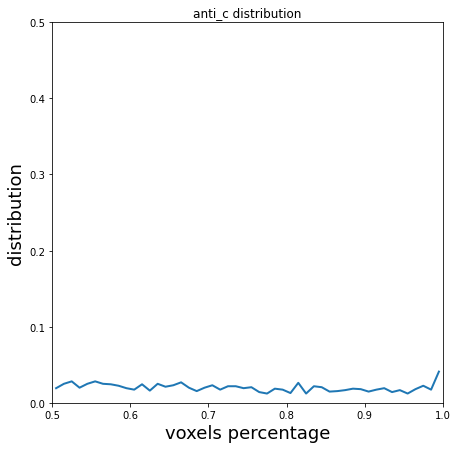

<Figure size 432x288 with 0 Axes>

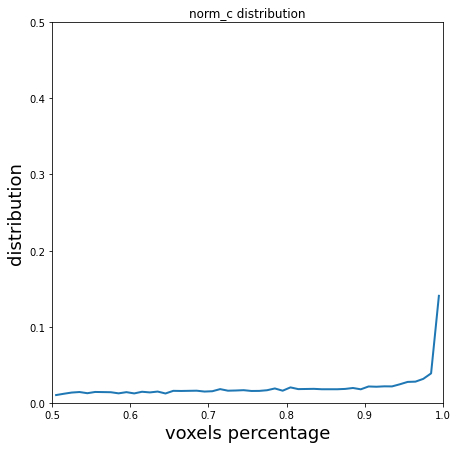

In [10]:
    # voxels information in anti-c GBs --- Yes I think it can be confidence!!!!!!
    bin_interval = 0.01
    x_lim = [0.5,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    Antic_voxel_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2
    
    antic_voxel_num_bin = np.zeros(bin_number)
    normc_voxel_num_bin = np.zeros(bin_number)
    for index in range(len(GB_antic_list_dV_normD_list)):
        antic_voxel_num_bin[int((GB_antic_list_dV_antiD_list[index]/(GB_antic_list_dV_normD_list[index]+GB_antic_list_dV_antiD_list[index])-x_lim[0])//bin_interval)] += 1
    for index in range(len(GB_normc_list_dV_normD_list)):
        normc_voxel_num_bin[int((GB_normc_list_dV_normD_list[index]/(GB_normc_list_dV_normD_list[index]+GB_normc_list_dV_antiD_list[index])-x_lim[0])//bin_interval)] += 1
    # plot
    figure_name_all_bin = f"figures/2D_antic_voxel_distribution_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.5,1.0])
    plt.ylim([0,0.5])
    plt.title("anti_c distribution")
    plt.plot(Antic_voxel_coordinate, antic_voxel_num_bin/np.sum(antic_voxel_num_bin),'-', linewidth=2)
    plt.xlabel("voxels percentage", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    figure_name_all_bin = f"figures/2D_normc_voxel_distribution_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.5,1.0])
    plt.ylim([0,0.5])
    plt.title("norm_c distribution")
    plt.plot(Antic_voxel_coordinate, normc_voxel_num_bin/np.sum(normc_voxel_num_bin),'-', linewidth=2)
    plt.xlabel("voxels percentage", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
        
    confidence_factor = 0.99
    
    update_GB_antic_list_velocity_AllList = []
    update_GB_antic_list_curvature_AllList = []
    update_GB_antic_list_GBenergy_AllList = []
    update_GB_antic_list_anticNum_AllList = []
    update_GB_antic_list_area_AllList = []
    update_GB_antic_list_dV_normD_AllList = []
    update_GB_antic_list_dV_antiD_AllList = []
    
    update_GB_antic_list_velocity_list = []
    update_GB_antic_list_curvature_list = []
    update_GB_antic_list_GBenergy_list = []
    update_GB_antic_list_anticNum_list = []
    update_GB_antic_list_area_list = []
    update_GB_antic_list_dV_normD_list = []
    update_GB_antic_list_dV_antiD_list = []
    for index in range(len(GB_antic_list_velocity_list)):
        if GB_antic_list_dV_antiD_list[index]/(GB_antic_list_dV_normD_list[index]+GB_antic_list_dV_antiD_list[index]) > confidence_factor:
            update_GB_antic_list_velocity_list.append(GB_antic_list_velocity_list[index])
            update_GB_antic_list_curvature_list.append(GB_antic_list_curvature_list[index])
            update_GB_antic_list_GBenergy_list.append(GB_antic_list_GBenergy_list[index])
            update_GB_antic_list_anticNum_list.append(GB_antic_list_anticNum_list[index])
            update_GB_antic_list_area_list.append(GB_antic_list_area_list[index])
            update_GB_antic_list_dV_normD_list.append(GB_antic_list_dV_normD_list[index])
            update_GB_antic_list_dV_antiD_list.append(GB_antic_list_dV_antiD_list[index])
    for index_i in range(len(update_GB_antic_list_velocity_AllList)):
        tmp_update_GB_antic_list_velocity_AllList =[]
        tmp_update_GB_antic_list_curvature_AllList =[]
        tmp_update_GB_antic_list_GBenergy_AllList = []
        tmp_update_GB_antic_list_anticNum_AllList = []
        tmp_update_GB_antic_list_area_AllList = []
        tmp_update_GB_antic_list_dV_normD_AllList = []
        tmp_update_GB_antic_list_dV_antiD_AllList = []
        for index_j in range(len(update_GB_antic_list_velocity_AllList[index_i])):
            if GB_antic_list_dV_antiD_AllList[index_i][index_j]/(GB_antic_list_dV_normD_AllList[index_i][index_j]+GB_antic_list_dV_antiD_AllList[index_i][index_j]) > confidence_factor:
                tmp_update_GB_antic_list_velocity_AllList.append(GB_antic_list_velocity_AllList[index_i][index_j])
                tmp_update_GB_antic_list_curvature_AllList.append(GB_antic_list_curvature_AllList[index_i][index_j])
                tmp_update_GB_antic_list_GBenergy_AllList.append(GB_antic_list_GBenergy_AllList[index_i][index_j])
                tmp_update_GB_antic_list_anticNum_AllList.append(GB_antic_list_anticNum_AllList[index_i][index_j])
                tmp_update_GB_antic_list_area_AllList.append(GB_antic_list_area_AllList[index_i][index_j])
                tmp_update_GB_antic_list_dV_normD_AllList.append(GB_antic_list_dV_normD_AllList[index_i][index_j])
                tmp_update_GB_antic_list_dV_antiD_AllList.append(GB_antic_list_dV_antiD_AllList[index_i][index_j])
        update_GB_antic_list_velocity_AllList.append(tmp_update_GB_antic_list_velocity_AllList)
        update_GB_antic_list_curvature_AllList.append(tmp_update_GB_antic_list_curvature_AllList)
        update_GB_antic_list_GBenergy_AllList.append(tmp_update_GB_antic_list_GBenergy_AllList)
        update_GB_antic_list_anticNum_AllList.append(tmp_update_GB_antic_list_anticNum_AllList)
        update_GB_antic_list_area_AllList.append(tmp_update_GB_antic_list_area_AllList)
        update_GB_antic_list_dV_normD_AllList.append(tmp_update_GB_antic_list_dV_normD_AllList)
        update_GB_antic_list_dV_antiD_AllList.append(tmp_update_GB_antic_list_dV_antiD_AllList)
        
        
    update_GB_normc_list_velocity_AllList = []
    update_GB_normc_list_curvature_AllList = []
    update_GB_normc_list_GBenergy_AllList = []
    update_GB_normc_list_area_AllList = []
    update_GB_normc_list_dV_normD_AllList = []
    update_GB_normc_list_dV_antiD_AllList = []
    
    update_GB_normc_list_velocity_list = []
    update_GB_normc_list_curvature_list = []
    update_GB_normc_list_GBenergy_list = []
    update_GB_normc_list_area_list = []
    update_GB_normc_list_dV_normD_list = []
    update_GB_normc_list_dV_antiD_list = []
    for index in range(len(GB_normc_list_velocity_list)):
        if GB_normc_list_dV_normD_list[index]/(GB_normc_list_dV_normD_list[index]+GB_normc_list_dV_antiD_list[index]) > confidence_factor:
            update_GB_normc_list_velocity_list.append(GB_normc_list_velocity_list[index])
            update_GB_normc_list_curvature_list.append(GB_normc_list_curvature_list[index])
            update_GB_normc_list_GBenergy_list.append(GB_normc_list_GBenergy_list[index])
            update_GB_normc_list_area_list.append(GB_normc_list_area_list[index])
            update_GB_normc_list_dV_normD_list.append(GB_normc_list_dV_normD_list[index])
            update_GB_normc_list_dV_antiD_list.append(GB_normc_list_dV_antiD_list[index])
    for index_i in range(len(update_GB_normc_list_velocity_AllList)):
        tmp_update_GB_normc_list_velocity_AllList =[]
        tmp_update_GB_normc_list_curvature_AllList =[]
        tmp_update_GB_normc_list_GBenergy_AllList = []
        tmp_update_GB_normc_list_area_AllList = []
        tmp_update_GB_normc_list_dV_normD_AllList = []
        tmp_update_GB_normc_list_dV_antiD_AllList = []
        for index_j in range(len(update_GB_normc_list_velocity_AllList[index_i])):
            if GB_normc_list_dV_normD_AllList[index_i][index_j]/(GB_normc_list_dV_normD_AllList[index_i][index_j]+GB_normc_list_dV_antiD_AllList[index_i][index_j]) > confidence_factor:
                tmp_update_GB_normc_list_velocity_AllList.append(GB_normc_list_velocity_AllList[index_i][index_j])
                tmp_update_GB_normc_list_curvature_AllList.append(GB_normc_list_curvature_AllList[index_i][index_j])
                tmp_update_GB_normc_list_GBenergy_AllList.append(GB_normc_list_GBenergy_AllList[index_i][index_j])
                tmp_update_GB_normc_list_area_AllList.append(GB_normc_list_area_AllList[index_i][index_j])
                tmp_update_GB_normc_list_dV_normD_AllList.append(GB_normc_list_dV_normD_AllList[index_i][index_j])
                tmp_update_GB_normc_list_dV_antiD_AllList.append(GB_normc_list_dV_antiD_AllList[index_i][index_j])
        update_GB_normc_list_velocity_AllList.append(tmp_update_GB_normc_list_velocity_AllList)
        update_GB_normc_list_curvature_AllList.append(tmp_update_GB_normc_list_curvature_AllList)
        update_GB_normc_list_GBenergy_AllList.append(tmp_update_GB_normc_list_GBenergy_AllList)
        update_GB_normc_list_area_AllList.append(tmp_update_GB_normc_list_area_AllList)
        update_GB_normc_list_dV_normD_AllList.append(tmp_update_GB_normc_list_dV_normD_AllList)
        update_GB_normc_list_dV_antiD_AllList.append(tmp_update_GB_normc_list_dV_antiD_AllList)
        
            
    

In [11]:
    print("Voxels on anti-c GBs")
    normal_growth_voxel = 0
    antic_growth_voxel = 0
    # calculate anti-c voxels fraction
    normal_growth_voxel = np.sum(update_GB_antic_list_dV_normD_list)
    antic_growth_voxel = np.sum(update_GB_antic_list_dV_antiD_list)
    print(f"The number of the normal voxels and antic voxels during whole simulations are {normal_growth_voxel} and {antic_growth_voxel}")
    print(f"The ratio of anti-curvature voxels during whole simulations is {antic_growth_voxel/(antic_growth_voxel+normal_growth_voxel)*100}% in {antic_growth_voxel+normal_growth_voxel} voxels")
    print()
    print("Voxels on norm-c GBs")
    normal_growth_voxel = 0
    antic_growth_voxel = 0
    # calculate anti-c voxels fraction
    normal_growth_voxel = np.sum(update_GB_normc_list_dV_normD_list)
    antic_growth_voxel = np.sum(update_GB_normc_list_dV_antiD_list)
    print(f"The number of the normal voxels and antic voxels during whole simulations are {normal_growth_voxel} and {antic_growth_voxel}")
    print(f"The ratio of norm-curvature voxels during whole simulations is {normal_growth_voxel/(antic_growth_voxel+normal_growth_voxel)*100}% in {antic_growth_voxel+normal_growth_voxel} voxels")
    print()

    print("anti-c GB before removing low fraction")
    total_GB_num = 0
    for time_step in range(step_num):
        step_GB = GB_infomation_dict_list[time_step].keys()
        total_GB_num += len(step_GB)
        
    total_GB_num_real = len(GB_antic_list_velocity_list) + len(GB_normc_list_velocity_list)

    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(GB_antic_list_dV_normD_list)}")
    print(f"The ratio of anti-curvature and norm GBs during whole simulations is {len(GB_antic_list_dV_normD_list)/total_GB_num_real*100}% and {len(GB_normc_list_dV_normD_list)/total_GB_num_real*100}% in {total_GB_num_real} GBs")
    print()
    
    print("anti-c GB after removing low fraction")

    # number of GB woth high anti-c fraction (99%)
    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(update_GB_antic_list_dV_antiD_list)}")
    print(f"The ratio of anti-curvature and norm GBs during whole simulations is {len(update_GB_antic_list_dV_antiD_list)/total_GB_num_real*100}% and {len(update_GB_normc_list_dV_antiD_list)/total_GB_num_real*100}% in {total_GB_num_real} GBs")
    print()
    
    print(f"The ratio of anti-curvature and norm GBs during whole simulations is (original GBs number) {len(update_GB_antic_list_dV_antiD_list)/total_GB_num*100}% and {len(update_GB_normc_list_dV_antiD_list)/total_GB_num*100}% in {total_GB_num} GBs")
    print()
    
    

Voxels on anti-c GBs
The number of the normal voxels and antic voxels during whole simulations are 53 and 15737
The ratio of anti-curvature voxels during whole simulations is 99.66434452184927% in 15790 voxels

Voxels on norm-c GBs
The number of the normal voxels and antic voxels during whole simulations are 419201 and 693
The ratio of norm-curvature voxels during whole simulations is 99.83495834663034% in 419894 voxels

anti-c GB before removing low fraction
The number of the GBs showing anti-curvature during whole simulations is 1562
The ratio of anti-curvature and norm GBs during whole simulations is 11.94920440636475% and 88.05079559363526% in 13072 GBs

anti-c GB after removing low fraction
The number of the GBs showing anti-curvature during whole simulations is 64
The ratio of anti-curvature and norm GBs during whole simulations is 0.4895960832313341% and 12.377600979192167% in 13072 GBs

The ratio of anti-curvature and norm GBs during whole simulations is (original GBs number) 0

3.3027637084729817


Text(0, 0.5, 'velocity (voxel/step)')

<Figure size 432x288 with 0 Axes>

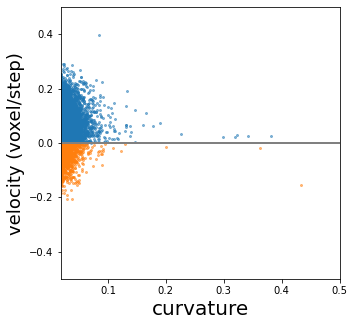

<Figure size 432x288 with 0 Axes>

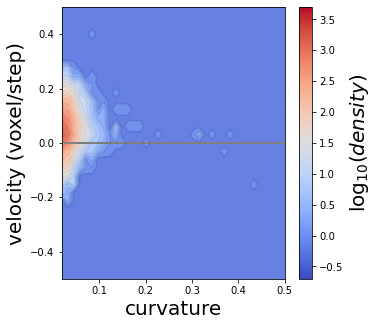

<Figure size 432x288 with 0 Axes>

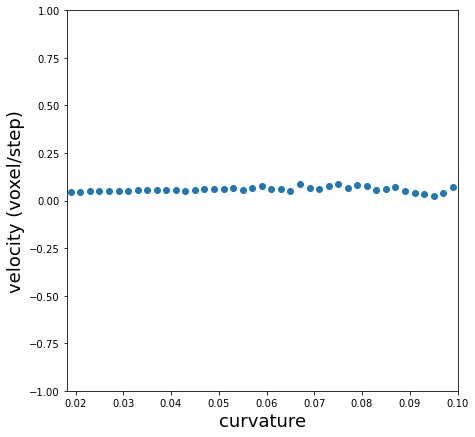

In [12]:
    # All in 1 figrue
    figure_name_all = f"figures/2D_velocity_signedcurvature_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.5],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(GB_normc_list_curvature_list, GB_normc_list_velocity_list,s=4,alpha=0.5)
    plt.scatter(GB_antic_list_curvature_list, GB_antic_list_velocity_list,s=4,alpha=0.5,color='C01')
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([curvature_limit,0.5])
    plt.ylim([-0.5,0.5])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # hot figure
    # Create a 2D histogram to approximate density
    x_bins = np.linspace( 0, 0.505, 40)  # X-axis bins (adjust based on your data)
    y_bins = np.linspace(-0.6, 0.6, 40)  # Y-axis bins (adjust based on your data)
    hist, x_edges, y_edges = np.histogram2d(GB_normc_list_curvature_list+GB_antic_list_curvature_list, GB_normc_list_velocity_list+GB_antic_list_velocity_list, bins=[x_bins, y_bins])
    # Compute the bin centers
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    
    figure_name_all = f"figures/2D_velocity_signedcurvature_hot_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.5],[0,0],'-',color='grey',linewidth=2)
    X, Y = np.meshgrid(x_centers, y_centers)
    hist.T[hist.T==0] = 0.5
    plt.contour(X, Y, np.log10(hist.T), levels=20, cmap='gray', alpha=0.1)
    ax2 = plt.contourf(X, Y, np.log10(hist.T), levels=20, cmap='coolwarm', alpha=0.9,vmin=-0.7,vmax=3.7)
    sm = plt.cm.ScalarMappable(cmap='coolwarm',norm=plt.Normalize(vmin=-0.7,vmax=3.7))
    cbar = plt.colorbar(sm)
    cbar.set_label(u"$\log_{10}(density)$", fontsize=20)
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=20)
    plt.xlim([curvature_limit,0.5])
    plt.ylim([-0.5,0.5])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    print(np.max(np.log10(hist.T)))
    
    # plot velocity VS averaged curvature
    bin_interval = 0.002
    x_lim = [0,0.5]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    curvature_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    new_curvature_1Dlist_remove_0step = GB_normc_list_curvature_list + GB_antic_list_curvature_list
    new_velocity_1Dlist_remove_0step = GB_normc_list_velocity_list + GB_antic_list_velocity_list
    new_area_1Dlist_remove_0step = GB_normc_list_area_list+GB_antic_list_area_list
    new_GBenergy_1Dlist_remove_0step = GB_normc_list_GBenergy_list+GB_antic_list_GBenergy_list
    for index in range(len(new_curvature_1Dlist_remove_0step)):
        if abs(new_curvature_1Dlist_remove_0step[index])>=x_lim[1] or abs(new_curvature_1Dlist_remove_0step[index])<=x_lim[0]: continue
        curvature_bin[int((new_curvature_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((new_curvature_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += new_velocity_1Dlist_remove_0step[index]
    for i in range(bin_number): 
        if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
    # plot
    figure_name_all_bin = f"figures/2D_velocity_signedcurvature_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([curvature_limit,0.1])
    plt.ylim([-1,1])
    plt.plot(curvature_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("curvature", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')

Text(0, 0.5, 'velocity (voxel/step)')

<Figure size 432x288 with 0 Axes>

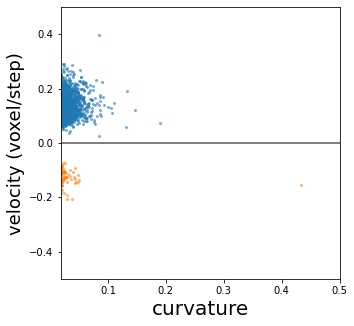

<Figure size 432x288 with 0 Axes>

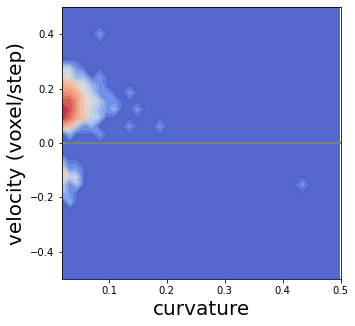

<Figure size 432x288 with 0 Axes>

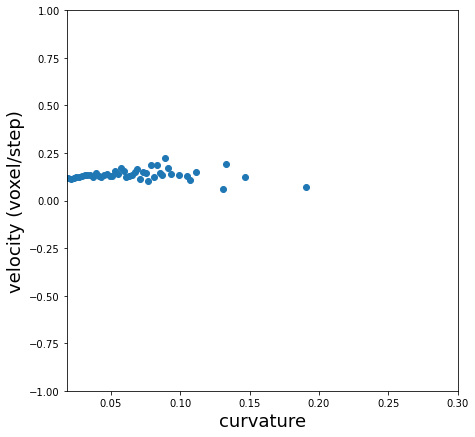

In [13]:
    # All in 1 figrue
    figure_name_all = f"figures/2D_velocity_signedcurvature_confi_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.5],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(update_GB_normc_list_curvature_list, update_GB_normc_list_velocity_list,s=4,alpha=0.5)
    plt.scatter(update_GB_antic_list_curvature_list, update_GB_antic_list_velocity_list,s=4,alpha=0.5,color='C01')
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([curvature_limit,0.5])
    plt.ylim([-0.5,0.5])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # hot figure
    # Create a 2D histogram to approximate density
    x_bins = np.linspace( 0, 0.505, 40)  # X-axis bins (adjust based on your data)
    y_bins = np.linspace(-0.6, 0.6, 40)  # Y-axis bins (adjust based on your data)
    hist, x_edges, y_edges = np.histogram2d(update_GB_normc_list_curvature_list+update_GB_antic_list_curvature_list, update_GB_normc_list_velocity_list+update_GB_antic_list_velocity_list, bins=[x_bins, y_bins])
    # Compute the bin centers
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    
    figure_name_all = f"figures/2D_velocity_signedcurvature_confi_hot_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.5],[0,0],'-',color='grey',linewidth=2)
    X, Y = np.meshgrid(x_centers, y_centers)
    hist.T[hist.T==0] = 0.5
    plt.contourf(X, Y, np.log10(hist.T), levels=20, cmap='coolwarm', alpha=0.9)
    plt.contour(X, Y, np.log10(hist.T), levels=20, cmap='gray', alpha=0.1)
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=20)
    plt.xlim([curvature_limit,0.5])
    plt.ylim([-0.5,0.5])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged curvature
    bin_interval = 0.002
    x_lim = [0.0,0.5]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    curvature_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    new_curvature_1Dlist_remove_0step = update_GB_normc_list_curvature_list + update_GB_antic_list_curvature_list
    new_velocity_1Dlist_remove_0step = update_GB_normc_list_velocity_list + update_GB_antic_list_velocity_list
    new_area_1Dlist_remove_0step = update_GB_normc_list_area_list+update_GB_antic_list_area_list
    new_GBenergy_1Dlist_remove_0step = update_GB_normc_list_GBenergy_list+update_GB_antic_list_GBenergy_list
    for index in range(len(new_curvature_1Dlist_remove_0step)):
        if abs(new_curvature_1Dlist_remove_0step[index])>=x_lim[1] or abs(new_curvature_1Dlist_remove_0step[index])<=x_lim[0]: continue
        curvature_bin[int((new_curvature_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((new_curvature_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += new_velocity_1Dlist_remove_0step[index]
    for i in range(bin_number): 
        if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
    # plot
    figure_name_all_bin = f"figures/2D_velocity_signedcurvature_confi_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([curvature_limit,0.3])
    plt.ylim([-1,1])
    plt.plot(curvature_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("curvature", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')

Text(0, 0.5, 'area')

<Figure size 432x288 with 0 Axes>

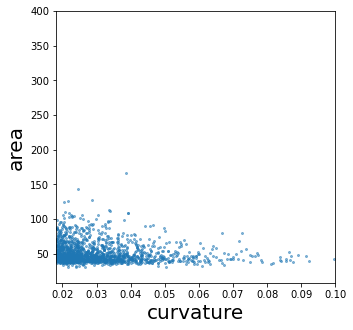

<Figure size 432x288 with 0 Axes>

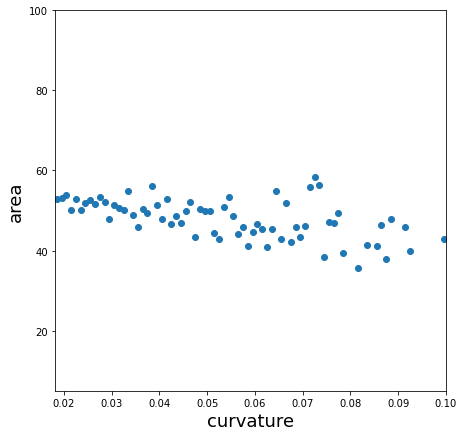

In [14]:
    # curvature VS area
    figure_name_all = f"figures/2D_signedcurvature_area_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.1],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(new_curvature_1Dlist_remove_0step, new_area_1Dlist_remove_0step,s=4,alpha=0.5)
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("area", fontsize=20)
    plt.xlim([curvature_limit,0.1])
    plt.ylim([8,400])
    # plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot area VS averaged curvature
    bin_interval = 0.001
    x_lim = [0.0,0.1]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    curvature_bin = np.zeros(bin_number)
    area_bin = np.zeros(bin_number)
    for index in range(len(new_curvature_1Dlist_remove_0step)):
        if abs(new_curvature_1Dlist_remove_0step[index])>0.1: continue
        curvature_bin[int((new_curvature_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        area_bin[int((new_curvature_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += new_area_1Dlist_remove_0step[index]
    for i in range(bin_number): 
        if curvature_bin[i]>0: area_bin[i] = area_bin[i]/curvature_bin[i]
    # plot
    figure_name_all_bin = f"figures/2D_signedcurvature_area_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([curvature_limit,0.1])
    plt.ylim([5,100])
    plt.plot(curvature_coordinate[area_bin!=0], area_bin[area_bin!=0],'o', linewidth=2)
    plt.xlabel("curvature", fontsize=18)
    plt.ylabel("area", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')

Text(0, 0.5, 'velocity (voxel/step)')

<Figure size 432x288 with 0 Axes>

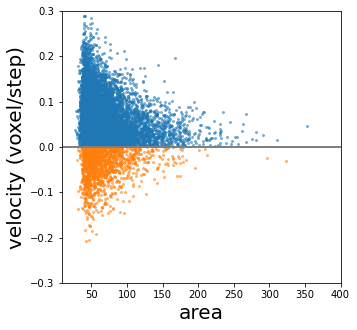

<Figure size 432x288 with 0 Axes>

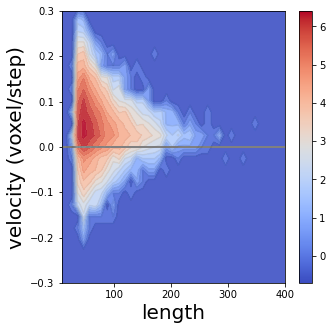

<Figure size 432x288 with 0 Axes>

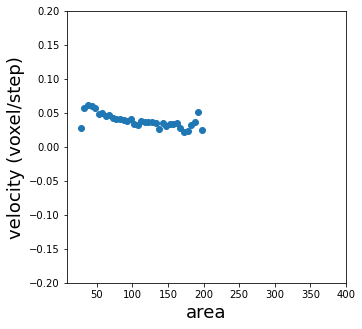

In [15]:
    velocity_1Dlist_remove_0step = GB_normc_list_velocity_list + GB_antic_list_velocity_list
    area_1Dlist_remove_0step = GB_normc_list_area_list+ GB_antic_list_area_list
    
    # velocity VS area
    figure_name_all = f"figures/2D_velocity_area_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([0,400],[0,0],'-',color='grey',linewidth=2)
    # plt.scatter(area_1Dlist_remove_0step, velocity_1Dlist_remove_0step,s=4,alpha=0.5)
    plt.scatter(GB_normc_list_area_list, GB_normc_list_velocity_list,s=4,alpha=0.5)
    plt.scatter(GB_antic_list_area_list, GB_antic_list_velocity_list,s=4,alpha=0.5,color='C01')
    plt.xlabel("area", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=20)
    plt.xlim([8,400])
    plt.ylim([-0.3,0.3])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    
    # hot figure
    # Create a 2D histogram to approximate density
    x_bins = np.linspace( 0, 405, 40)  # X-axis bins (adjust based on your data)
    y_bins = np.linspace(-0.5, 0.5, 40)  # Y-axis bins (adjust based on your data)
    hist, x_edges, y_edges = np.histogram2d(area_1Dlist_remove_0step, velocity_1Dlist_remove_0step, bins=[x_bins, y_bins])
    # Compute the bin centers
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    
    figure_name_all = f"figures/2D_velocity_area_hot_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([8,400],[0,0],'-',color='grey',linewidth=2)
    X, Y = np.meshgrid(x_centers, y_centers)
    hist.T[hist.T==0] = 0.5
    plt.contour(X, Y, np.log(hist.T), levels=20, cmap='gray', alpha=0.1)
    plt.contourf(X, Y, np.log(hist.T), levels=20, cmap='coolwarm', alpha=0.9,vmin=-0.7,vmax=6.4)
    sm = plt.cm.ScalarMappable(cmap='coolwarm',norm=plt.Normalize(vmin=-0.7,vmax=6.4))
    cbar = plt.colorbar(sm)
    plt.xlabel("length", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=20)
    plt.xlim([8,400])
    plt.ylim([-0.3,0.3])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS area
    bin_interval = 5
    x_lim = [5,200]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    area_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    area_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    for index in range(len(area_1Dlist_remove_0step)):
        if abs(area_1Dlist_remove_0step[index])>=x_lim[1] or abs(area_1Dlist_remove_0step[index])<=x_lim[0]: continue
        area_bin[int((area_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((area_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_remove_0step[index]
        if velocity_1Dlist_remove_0step[index] < 0: antic_num_bin[int((area_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
    for i in range(bin_number): 
        if area_bin[i]>0: velocity_bin[i] = velocity_bin[i]/area_bin[i]
    # plot
    figure_name_all_bin = f"figures/2D_velocity_area_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.xlim([8,400])
    plt.ylim([-0.2,0.2])
    plt.plot(area_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("area", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    

average area is 64.2234164626683


<Figure size 432x288 with 0 Axes>

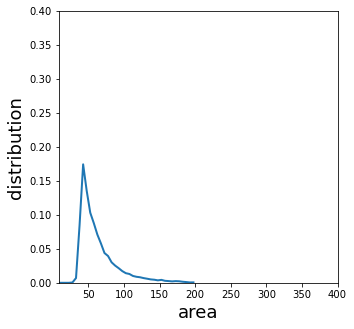

<Figure size 432x288 with 0 Axes>

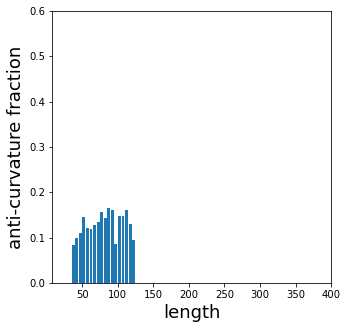

In [16]:
    # anti-c fraction VS area bin
    figure_name_all = f"figures/2D_area_distribution_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.xlim([8,400])
    plt.ylim([0,0.4])
    plt.plot(area_coordinate, area_bin/np.sum(area_bin),'-', linewidth=2)
    plt.xlabel("area", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(area_bin)):
        if area_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/area_bin[bin_i]
    figure_name_all = f"figures/2D_antic_area_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.xlim([8,400])
    plt.ylim([0,0.6])
    # plt.plot(area_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.bar(area_coordinate[area_bin>100], antic_ratio_bin[area_bin>100], width=bin_interval*0.8, color=f'C0')
    plt.xlabel("length", fontsize=18)
    plt.ylabel("anti-curvature fraction", fontsize=18)
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    print(f"average area is {np.mean(area_1Dlist_remove_0step)}")
    


Text(0, 0.5, 'velocity (voxel/step)')

<Figure size 432x288 with 0 Axes>

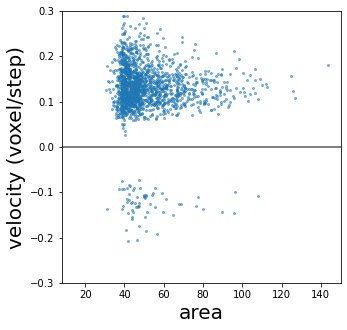

<Figure size 432x288 with 0 Axes>

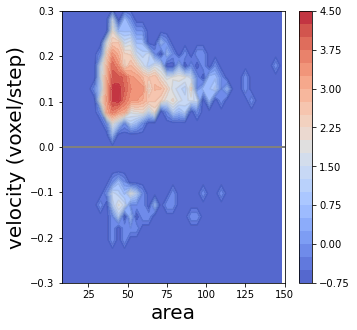

<Figure size 432x288 with 0 Axes>

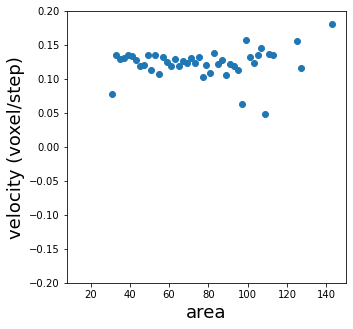

In [17]:
    # velocity VS area
    figure_name_all = f"figures/2D_velocity_area_confi_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([0,400],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(new_area_1Dlist_remove_0step, new_velocity_1Dlist_remove_0step,s=4,alpha=0.5)
    plt.xlabel("area", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=20)
    plt.xlim([8,150])
    plt.ylim([-0.3,0.3])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    
    # hot figure
    # Create a 2D histogram to approximate density
    x_bins = np.linspace( 0, 150, 40)  # X-axis bins (adjust based on your data)
    y_bins = np.linspace(-0.5, 0.5, 40)  # Y-axis bins (adjust based on your data)
    hist, x_edges, y_edges = np.histogram2d(new_area_1Dlist_remove_0step, new_velocity_1Dlist_remove_0step, bins=[x_bins, y_bins])
    # Compute the bin centers
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    
    figure_name_all = f"figures/2D_velocity_area_confi_hot_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([8,150],[0,0],'-',color='grey',linewidth=2)
    X, Y = np.meshgrid(x_centers, y_centers)
    hist.T[hist.T==0] = 0.5
    plt.contour(X, Y, np.log(hist.T), levels=20, cmap='gray', alpha=0.1)
    plt.contourf(X, Y, np.log(hist.T), levels=20, cmap='coolwarm', alpha=0.9)
    plt.xlabel("area", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=20)
    plt.xlim([8,150])
    plt.ylim([-0.3,0.3])
    plt.colorbar()
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS area
    bin_interval = 2
    x_lim = [8,150]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    area_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    area_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    for index in range(len(new_area_1Dlist_remove_0step)):
        if abs(new_area_1Dlist_remove_0step[index])>=x_lim[1] or abs(new_area_1Dlist_remove_0step[index])<=x_lim[0]: continue
        area_bin[int((new_area_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((new_area_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += new_velocity_1Dlist_remove_0step[index]
        if new_velocity_1Dlist_remove_0step[index] < 0: antic_num_bin[int((new_area_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
    for i in range(bin_number): 
        if area_bin[i]>0: velocity_bin[i] = velocity_bin[i]/area_bin[i]
    # plot
    figure_name_all_bin = f"figures/2D_velocity_area_confi_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.xlim([8,150])
    plt.ylim([-0.2,0.2])
    plt.plot(area_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("area", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    

average area is 51.10047562425684


<Figure size 432x288 with 0 Axes>

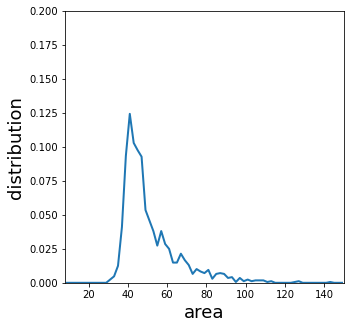

<Figure size 432x288 with 0 Axes>

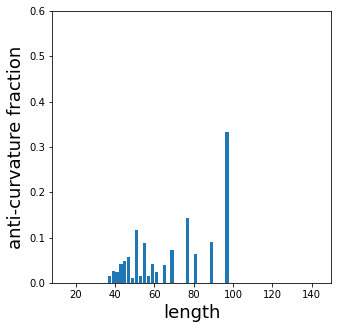

In [18]:
    # anti-c fraction VS area bin
    figure_name_all = f"figures/2D_area_distribution_confi_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.xlim([8,150])
    plt.ylim([0,0.2])
    plt.plot(area_coordinate, area_bin/np.sum(area_bin),'-', linewidth=2)
    plt.xlabel("area", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(area_bin)):
        if area_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/area_bin[bin_i]
    figure_name_all = f"figures/2D_antic_area_confi_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.xlim([8,150])
    plt.ylim([0,0.6])
    # plt.plot(area_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.bar(area_coordinate[area_bin>5], antic_ratio_bin[area_bin>5], width=bin_interval*0.8, color=f'C0')
    plt.xlabel("length", fontsize=18)
    plt.ylabel("anti-curvature fraction", fontsize=18)
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    print(f"average area is {np.mean(new_area_1Dlist_remove_0step)}")
    


Text(0, 0.5, 'GB energy')

<Figure size 432x288 with 0 Axes>

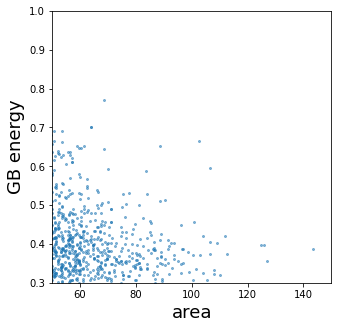

<Figure size 432x288 with 0 Axes>

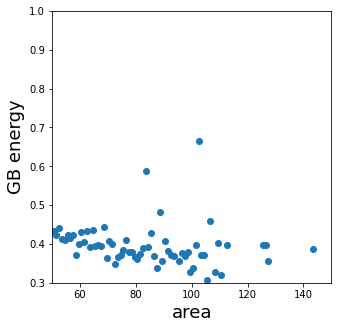

In [19]:
    # GB_energy VS area
    figure_name_all = f"figures/2D_GBenergy_area_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.scatter(new_area_1Dlist_remove_0step, new_GBenergy_1Dlist_remove_0step,s=4,alpha=0.5)
    plt.xlabel("area", fontsize=18)
    plt.ylabel("GB energy", fontsize=18)
    plt.xlim([50,150])
    plt.ylim([0.3,1.0])
    # plt.legend(fontsize=18)
    # plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot GB energy VS area
    bin_interval = 1
    x_lim = [50,150]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    area_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    GBenergy_bin = np.zeros(bin_number)
    area_bin = np.zeros(bin_number)
    for index in range(len(new_area_1Dlist_remove_0step)):
        if abs(new_area_1Dlist_remove_0step[index])>=x_lim[1] or abs(new_area_1Dlist_remove_0step[index])<=x_lim[0]: continue
        area_bin[int((new_area_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        GBenergy_bin[int((new_area_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += new_GBenergy_1Dlist_remove_0step[index]
    for i in range(bin_number): 
        if area_bin[i]>0: GBenergy_bin[i] = GBenergy_bin[i]/area_bin[i]
    # plot
    figure_name_all_bin = f"figures/2D_GBenergy_area_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.xlim([50,150])
    plt.ylim([0.3,1.0])
    plt.plot(area_coordinate[GBenergy_bin!=0],GBenergy_bin[GBenergy_bin!=0],'o', linewidth=2)
    plt.xlabel("area", fontsize=18)
    plt.ylabel("GB energy", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    
    

<Figure size 432x288 with 0 Axes>

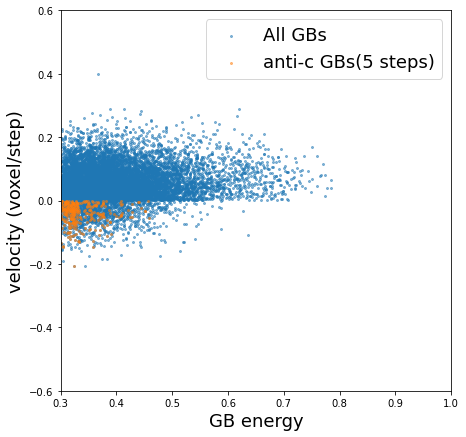

<Figure size 432x288 with 0 Axes>

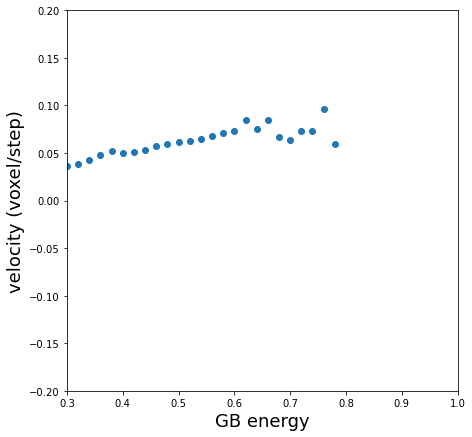

<Figure size 432x288 with 0 Axes>

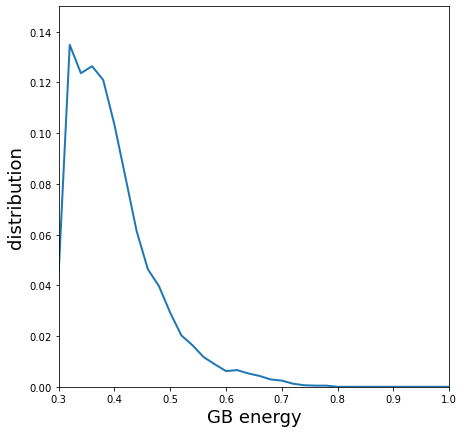

<Figure size 432x288 with 0 Axes>

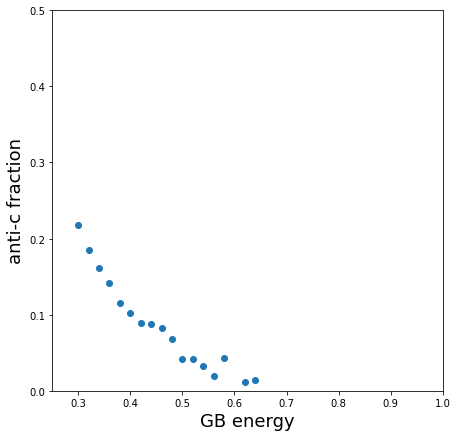

In [20]:

    GBenergy_1Dlist_remove_0step = GB_normc_list_GBenergy_list+ list(GB_antic_list_GBenergy_list)
    
    figure_name_all = f"figures/2D_velocity_GBenergy_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(GBenergy_1Dlist_remove_0step, velocity_1Dlist_remove_0step,s=4,alpha=0.5,label='All GBs')
    GB_antic_list_GBenergy_list = np.array(GB_antic_list_GBenergy_list)
    GB_antic_list_velocity_list = np.array(GB_antic_list_velocity_list)
    GB_antic_list_anticNum_list = np.array(GB_antic_list_anticNum_list)
    plt.scatter(GB_antic_list_GBenergy_list[GB_antic_list_anticNum_list>=5], GB_antic_list_velocity_list[GB_antic_list_anticNum_list>=5],s=4,alpha=0.5,label='anti-c GBs(5 steps)')
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0.3,1.0])
    plt.ylim([-0.6,0.6])
    plt.legend(fontsize=18)
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged GBenergy
    bin_interval = 0.02
    x_lim = [0.25,1.01]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    GBenergy_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    for index in range(len(GBenergy_1Dlist_remove_0step)):
        if abs(GBenergy_1Dlist_remove_0step[index])>=x_lim[1] or abs(GBenergy_1Dlist_remove_0step[index])<=x_lim[0]: continue
        GBenergy_bin[int((GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_remove_0step[index]
        if velocity_1Dlist_remove_0step[index] < 0: 
            antic_num_bin[int((GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        if int((GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)<0: print(GBenergy_1Dlist_remove_0step[index])
    for i in range(bin_number): 
        if GBenergy_bin[i]>0: velocity_bin[i] = velocity_bin[i]/GBenergy_bin[i]
    # plot
    figure_name_all_bin = f"figures/2D_velocity_GBenergy_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(GBenergy_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([0.3,1.0])
    plt.ylim([-0.2,0.2])
    plt.plot(GBenergy_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(GBenergy_bin)):
        if GBenergy_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/GBenergy_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.25,1.0])
    plt.ylim([0,0.5])
    plt.plot(GBenergy_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("anti-c fraction", fontsize=18)
    
    anti_c_data_file_name = f"data/2D_antic_data_{case_name}"
    np.savez(anti_c_data_file_name,antic_ratio_bin=antic_ratio_bin,GBenergy_bin=GBenergy_bin)
    
        

<Figure size 432x288 with 0 Axes>

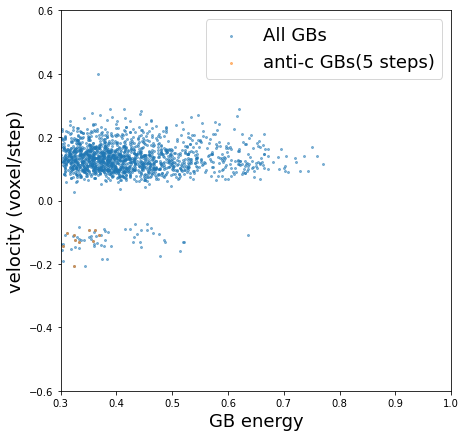

<Figure size 432x288 with 0 Axes>

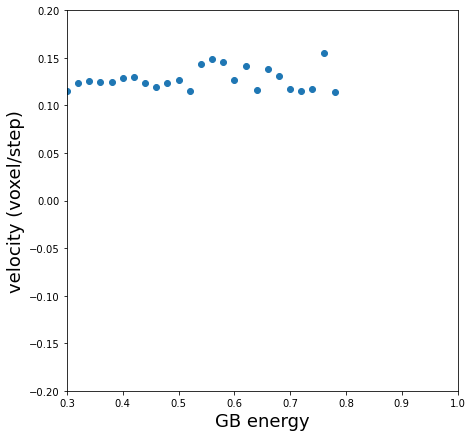

<Figure size 432x288 with 0 Axes>

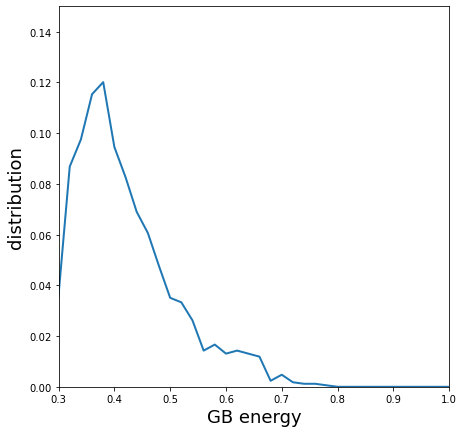

<Figure size 432x288 with 0 Axes>

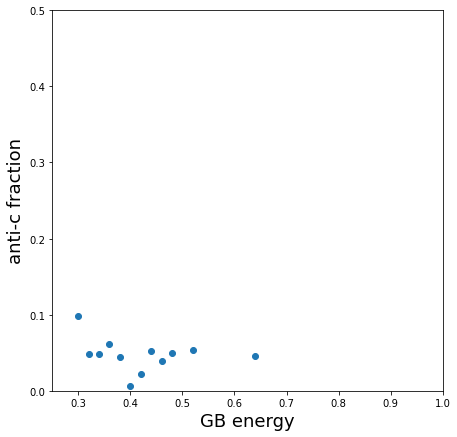

In [21]:

    figure_name_all = f"figures/2D_velocity_GBenergy_confi_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(new_GBenergy_1Dlist_remove_0step, new_velocity_1Dlist_remove_0step,s=4,alpha=0.5,label='All GBs')
    update_GB_antic_list_GBenergy_list = np.array(update_GB_antic_list_GBenergy_list)
    update_GB_antic_list_velocity_list = np.array(update_GB_antic_list_velocity_list)
    update_GB_antic_list_anticNum_list = np.array(update_GB_antic_list_anticNum_list)
    plt.scatter(update_GB_antic_list_GBenergy_list[update_GB_antic_list_anticNum_list>=5], update_GB_antic_list_velocity_list[update_GB_antic_list_anticNum_list>=5],s=4,alpha=0.5,label='anti-c GBs(5 steps)')
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0.3,1.0])
    plt.ylim([-0.6,0.6])
    plt.legend(fontsize=18)
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged GBenergy
    bin_interval = 0.02
    x_lim = [0.25,1.01]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    GBenergy_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    for index in range(len(new_GBenergy_1Dlist_remove_0step)):
        if abs(new_GBenergy_1Dlist_remove_0step[index])>=x_lim[1] or abs(new_GBenergy_1Dlist_remove_0step[index])<=x_lim[0]: continue
        GBenergy_bin[int((new_GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((new_GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += new_velocity_1Dlist_remove_0step[index]
        if new_velocity_1Dlist_remove_0step[index] < 0: antic_num_bin[int((new_GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        if int((new_GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)<0: print(new_GBenergy_1Dlist_remove_0step[index])
    for i in range(bin_number): 
        if GBenergy_bin[i]>0: velocity_bin[i] = velocity_bin[i]/GBenergy_bin[i]
    # plot
    figure_name_all_bin = f"figures/2D_velocity_GBenergy_confi_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(GBenergy_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([0.3,1.0])
    plt.ylim([-0.2,0.2])
    plt.plot(GBenergy_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(GBenergy_bin)):
        if GBenergy_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/GBenergy_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.25,1.0])
    plt.ylim([0,0.5])
    plt.plot(GBenergy_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("anti-c fraction", fontsize=18)
    
    anti_c_data_file_name = f"data/2D_antic_data_confi_{case_name}"
    np.savez(anti_c_data_file_name,antic_ratio_bin=antic_ratio_bin,GBenergy_bin=GBenergy_bin)
    
#     GBenergy_coordinate_larger0 = GBenergy_coordinate[antic_ratio_bin>0]
#     delta_n = -0.66*np.log(antic_ratio_bin[antic_ratio_bin>0])/GBenergy_coordinate[antic_ratio_bin>0]
#     mean_delta_n = np.mean(delta_n)
#     mean_delta_n_2 = np.sum(delta_n*GBenergy_bin[antic_ratio_bin>0]/np.sum(GBenergy_bin[antic_ratio_bin>0]))
#     print(mean_delta_n_2)
#     plt.figure()
#     fig = plt.figure(figsize=(7, 7))
#     plt.xlim([0.3,1.0])
#     plt.ylim([0,5])
#     plt.plot(GBenergy_coordinate_larger0, delta_n,'o', linewidth=2, label = 'results')
#     plt.plot(GBenergy_coordinate_larger0, mean_delta_n*np.ones(len(GBenergy_coordinate_larger0)),'--',linewidth=2,color='gray',label=f'mean-{round(mean_delta_n,2)}')
#     plt.legend(fontsize=18)
#     plt.xlabel("GB energy", fontsize=18)
#     plt.ylabel("num of site", fontsize=18)
        

<Figure size 432x288 with 0 Axes>

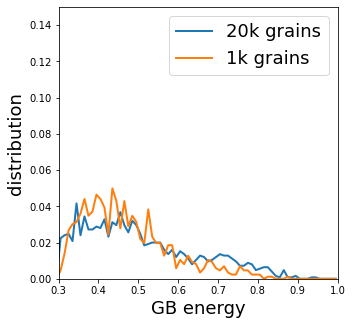

<Figure size 432x288 with 0 Axes>

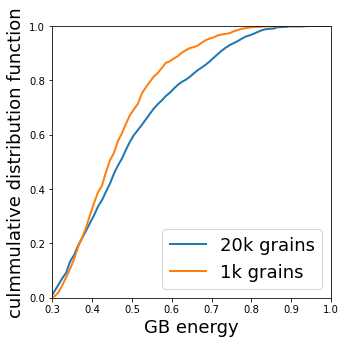

In [9]:
    # distribution for init and end
    bin_interval = 0.01
    x_lim = [0.25,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2
    
    figure_name_distri = f"figures/2D_one_step_distribution_{case_name}.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    first_step = 0
    second_step = step_1000grains
    bin_interval = 0.01
    x_lim = [0.25,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_bin_first = np.zeros(bin_number)
    for index in range(len(GB_list_GBenergy_list[first_step])):
        if abs(GB_list_GBenergy_list[first_step][index])>=1.0: continue
        GBenergy_bin_first[int((GB_list_GBenergy_list[first_step][index]-x_lim[0])//bin_interval)] += 1
    GBenergy_bin_second = np.zeros(bin_number)
    for index in range(len(GB_list_GBenergy_list[second_step])):
        if abs(GB_list_GBenergy_list[second_step][index])>=1.0: continue
        GBenergy_bin_second[int((GB_list_GBenergy_list[second_step][index]-x_lim[0])//bin_interval)] += 1
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin_first/np.sum(GBenergy_bin_first),'-', linewidth=2,label="20k grains")
    plt.plot(GBenergy_coordinate, GBenergy_bin_second/np.sum(GBenergy_bin_second),'-', linewidth=2,label=f"1k grains")
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    plt.savefig(figure_name_distri, dpi=400,bbox_inches='tight')
    
    # distribution for init and end
    figure_name_distri = f"figures/2D_culmmulative_distribution_function_{case_name}.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    first_step = 0
    second_step = step_1000grains
    GBenergy_bin_first = np.zeros(bin_number)
    for index in range(len(GB_list_GBenergy_list[first_step])):
        if abs(GB_list_GBenergy_list[first_step][index])>=1.0: continue
        GBenergy_bin_first[int((GB_list_GBenergy_list[first_step][index]-x_lim[0])//bin_interval)] += 1
    GBenergy_bin_first = GBenergy_bin_first/np.sum(GBenergy_bin_first)
    for index in range(len(GB_list_GBenergy_list[second_step])):
        if abs(GB_list_GBenergy_list[second_step][index])>=1.0: continue
        GBenergy_bin_second[int((GB_list_GBenergy_list[second_step][index]-x_lim[0])//bin_interval)] += 1
    GBenergy_bin_second = GBenergy_bin_second/np.sum(GBenergy_bin_second)
    culmmulative_GBenergy_bin_first = np.zeros(bin_number) 
    culmmulative_GBenergy_bin_second = np.zeros(bin_number) 
    for i in range(bin_number):
        culmmulative_GBenergy_bin_first[i] = np.sum(GBenergy_bin_first[:i+1])
        culmmulative_GBenergy_bin_second[i] = np.sum(GBenergy_bin_second[:i+1])
    plt.xlim([0.3,1.0])
    plt.ylim([0,1.0])
    plt.plot(GBenergy_coordinate, culmmulative_GBenergy_bin_first,'-', linewidth=2,label="20k grains")
    plt.plot(GBenergy_coordinate, culmmulative_GBenergy_bin_second,'-', linewidth=2,label=f"1k grains")
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("culmmulative distribution function", fontsize=18)
    plt.savefig(figure_name_distri, dpi=400,bbox_inches='tight')


Text(0, 0.5, 'curvature fraction')

<Figure size 432x288 with 0 Axes>

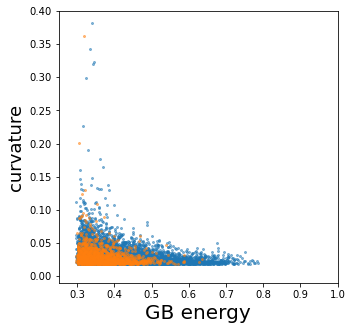

<Figure size 432x288 with 0 Axes>

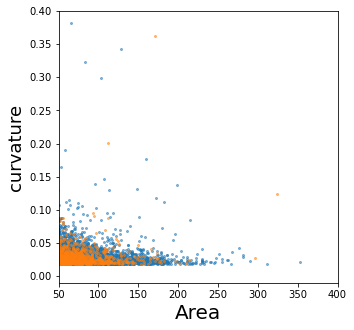

<Figure size 432x288 with 0 Axes>

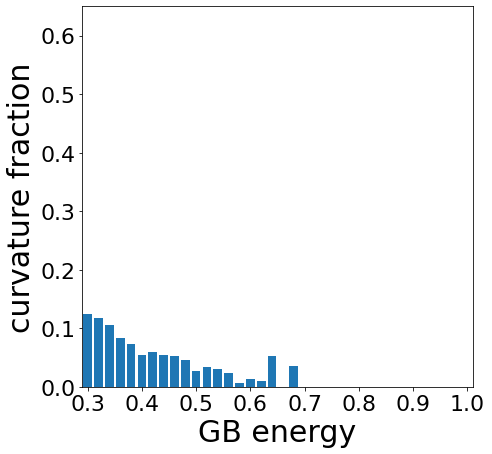

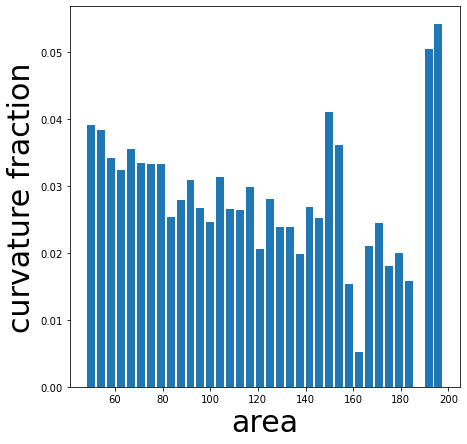

In [24]:
    # curvature VS GB energy
            
    figure_name_all = f"figures/2D_signedcurvature_GBenergy_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    # plt.plot([0.3,1.0],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(GB_normc_list_GBenergy_list, GB_normc_list_curvature_list, s=4,alpha=0.5)
    plt.scatter(GB_antic_list_GBenergy_list, GB_antic_list_curvature_list, s=4,alpha=0.5,color='C01')
    plt.xlabel("GB energy", fontsize=20)
    plt.ylabel("curvature", fontsize=18)
    plt.xlim([0.25,1.0])
    plt.ylim([-0.01,0.4])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.scatter(GB_normc_list_area_list, GB_normc_list_curvature_list, s=4,alpha=0.5)
    plt.scatter(GB_antic_list_area_list, GB_antic_list_curvature_list, s=4,alpha=0.5,color='C01')
    plt.xlabel("Area", fontsize=20)
    plt.ylabel("curvature", fontsize=18)
    plt.xlim([50,400])
    plt.ylim([-0.01,0.4])
    
    # plot signedcurvature VS GBenergy
    bin_interval = 0.02
    x_lim = [0.29,1.01] # GB energy
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval) + bin_interval/2
    y_lim = [50,200] # area
    y_bin_interval = (y_lim[1]-y_lim[0])/bin_number
    area_coordinate = np.arange(y_lim[0],y_lim[1],y_bin_interval) + bin_interval/2

    curvature_bin = np.zeros(bin_number)
    curvature_fraction_energy_bin = np.zeros(bin_number)
    curvature_fraction_area_bin = np.zeros(bin_number)
    curvature_fraction_matrix = np.zeros((bin_number,bin_number))
    GBenergy_distribution_bin = np.zeros(bin_number)
    area_distribution_bin = np.zeros(bin_number)
    distribution_matrix_bin = np.zeros((bin_number,bin_number))
    new_curvature_1Dlist_remove_0step = GB_normc_list_curvature_list + list(GB_antic_list_curvature_list)
    new_GBenergy_1Dlist_remove_0step = GB_normc_list_GBenergy_list + list(GB_antic_list_GBenergy_list)
    new_area_1Dlist_remove_0step = GB_normc_list_area_list + GB_antic_list_area_list
    for index in range(len(new_GBenergy_1Dlist_remove_0step)):
        # prefactor: avoid GB energy larger 1 and get coordinate index
        if abs(new_GBenergy_1Dlist_remove_0step[index]) >= x_lim[1] or abs(new_GBenergy_1Dlist_remove_0step[index]) <= x_lim[0]: continue
        if abs(new_area_1Dlist_remove_0step[index]) >= y_lim[1] or abs(new_area_1Dlist_remove_0step[index]) <= y_lim[0]: continue
        GB_energy_index = int((new_GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)
        area_index = int((new_area_1Dlist_remove_0step[index]-y_lim[0])//y_bin_interval)
        # distribution
        GBenergy_distribution_bin[GB_energy_index] += 1
        area_distribution_bin[area_index] += 1
        distribution_matrix_bin[GB_energy_index,area_index] += 1
        # averaged curvature
        curvature_bin[GB_energy_index] += new_curvature_1Dlist_remove_0step[index]
        # calculate high curvature fraction vs GB energy or vs energy-area matrix
        if new_curvature_1Dlist_remove_0step[index] > 0.03:
            curvature_fraction_energy_bin[GB_energy_index] += 1  # calculate high curvature fraction vs GB energy
            curvature_fraction_area_bin[area_index] += 1  # calculate high curvature fraction vs area
            curvature_fraction_matrix[GB_energy_index,area_index] += 1 # calculate high curvature fraction vs energy-area matrix
    # normalized
    curvature_bin[GBenergy_distribution_bin>0] /= GBenergy_distribution_bin[GBenergy_distribution_bin>0]
    curvature_fraction_energy_bin[GBenergy_distribution_bin>0] /= GBenergy_distribution_bin[GBenergy_distribution_bin>0]
    curvature_fraction_energy_bin /= np.sum(curvature_fraction_energy_bin)
    curvature_fraction_area_bin[area_distribution_bin>0] /= area_distribution_bin[area_distribution_bin>0]
    curvature_fraction_area_bin /= np.sum(curvature_fraction_area_bin)
    curvature_fraction_matrix[distribution_matrix_bin>0] /= distribution_matrix_bin[distribution_matrix_bin>0]
    curvature_fraction_matrix /= np.sum(curvature_fraction_matrix)
    # plot
    figure_name_all_bin = f"figures/2D_signedcurvature_GBenergy_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim(x_lim)
    plt.ylim([0,0.65])
    plt.bar(GBenergy_coordinate[GBenergy_distribution_bin>5], curvature_fraction_energy_bin[GBenergy_distribution_bin>5], width=bin_interval*0.8, color=f'C0', label='MI_cos')
    # plt.plot(GBenergy_coordinate, velocity_bin,'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=30)
    plt.ylabel("curvature fraction", fontsize=30)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    fig = plt.figure(figsize=(7, 7))
    # plt.xlim(x_lim)
    # plt.ylim([0,0.11])
    plt.bar(area_coordinate[area_distribution_bin>0], curvature_fraction_area_bin[area_distribution_bin>0], width=y_bin_interval*0.8, color=f'C0', label='MI_cos')
    # plt.plot(area_coordinate, curvature_fraction_area_bin, linewidth=2)
    plt.xlabel("area", fontsize=30)
    plt.ylabel("curvature fraction", fontsize=30)


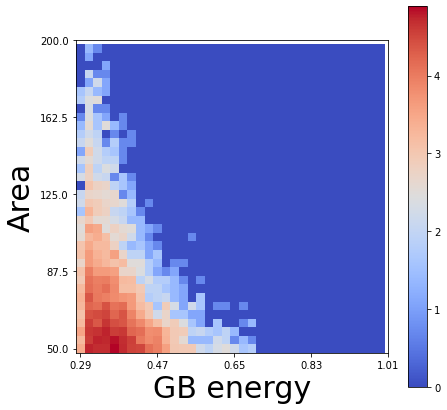

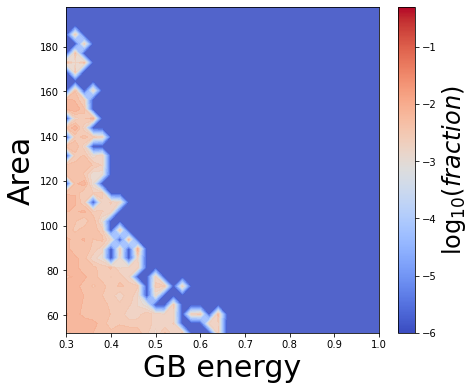

In [23]:
    # matrix distribution
    fig = plt.figure(figsize=(7,7))
    distribution_matrix_bin[distribution_matrix_bin==0]=1
    plt.imshow(np.log(distribution_matrix_bin.T),cmap='coolwarm')
    plt.xlabel("GB energy", fontsize=30)
    plt.ylabel("Area", fontsize=30)
    cbar = plt.colorbar()
    plt.xticks(np.linspace(0,bin_number,5),np.round(np.linspace(x_lim[0],x_lim[1],5),2))
    plt.yticks(np.linspace(0,bin_number,5),np.round(np.linspace(y_lim[0],y_lim[1],5),2))
    plt.gca().invert_yaxis()
    
    
    x_bins = np.linspace( x_lim[0], x_lim[1], bin_number+1)  # X-axis bins (adjust based on your data)
    y_bins = np.linspace( y_lim[0], y_lim[1], bin_number+1)  # Y-axis bins (adjust based on your data)
    hist, x_edges, y_edges = np.histogram2d(new_GBenergy_1Dlist_remove_0step, new_area_1Dlist_remove_0step, bins=[x_bins, y_bins])
    # Compute the bin centers
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    X, Y = np.meshgrid(x_centers, y_centers)
    
    figure_name_all = f"figures/2D_GBenergy_area_hotUpdate_{case_name}_5d.png"
    fig = plt.figure(figsize=(7,6))
    # curvature_fraction_matrix[curvature_fraction_matrix==0]=1
    # plt.imshow(curvature_fraction_matrix.T,cmap='coolwarm',vmax=0.01)
    curvature_fraction_matrix[curvature_fraction_matrix==0]=1e-6
    curvature_fraction_matrix[distribution_matrix_bin<=5]=1e-6
    plt.contourf(X, Y, np.log10(curvature_fraction_matrix.T), levels=20, cmap='coolwarm', alpha=0.9, vmin=-6,vmax=-0.3)
    sm = plt.cm.ScalarMappable(cmap='coolwarm',norm=plt.Normalize(vmin=-6,vmax=-0.3))
    cbar = plt.colorbar(sm)
    cbar.set_label(u"$\log_{10}(fraction)$", fontsize=24)
    plt.xlabel("GB energy", fontsize=30)
    plt.ylabel("Area", fontsize=30)
    # plt.xlim([50,5000])
    # plt.ylim([-5.0,5.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    

## One time step

  5%|▌         | 11/201 [00:20<05:50,  1.84s/it]


<Figure size 432x288 with 0 Axes>

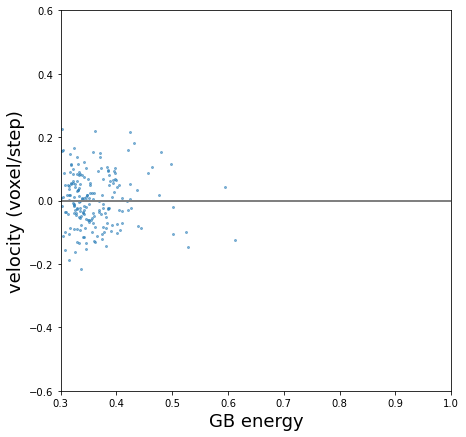

<Figure size 432x288 with 0 Axes>

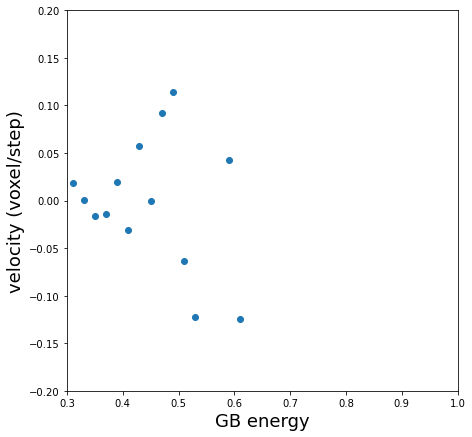

<Figure size 432x288 with 0 Axes>

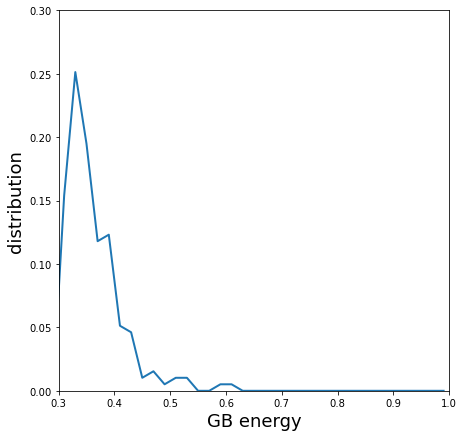

<Figure size 432x288 with 0 Axes>

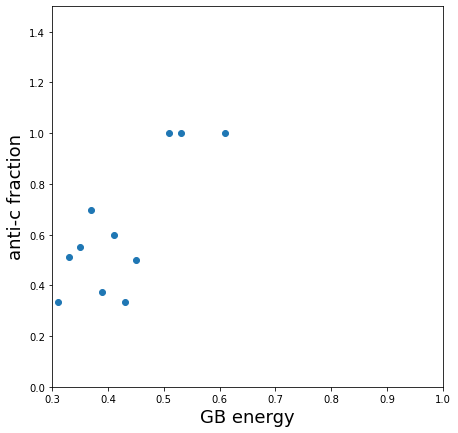

In [13]:
#     # For one specific time steps with 1000 grains

#     # get expected time step
#     expected_grain_num = 5000
#     grain_num_array = np.zeros(npy_file_aniso.shape[0])
#     # Calculate the number of grains
#     for i in tqdm(range(npy_file_aniso.shape[0])):
#         grain_num = len(np.unique(npy_file_aniso[i,:]))
#         grain_num_array[i] = grain_num
#         if grain_num < expected_grain_num/2: break
#     expected_time_step = int(np.argmin(abs(grain_num_array - expected_grain_num)))

#     # get all data on specific grain step
#     expected_step_curvature_list = GB_list_curvature_list[expected_time_step]
#     expected_step_velocity_list = GB_list_velocity_list[expected_time_step]
#     expected_step_GBenergy_list = GB_list_GBenergy_list[expected_time_step]
#     expected_step_curvature_list_exrandom = GB_list_curvature_list_exrandom[expected_time_step]
#     expected_step_velocity_list_exrandom = GB_list_velocity_list_exrandom[expected_time_step]
#     expected_step_GBenergy_list_exrandom = GB_list_GBenergy_list_exrandom[expected_time_step]

#     # plot
#     figure_name_all = f"figures/2D_velocity_GBenergy_{case_name}_5d_grain{expected_grain_num}.png"
#     plt.figure()
#     fig = plt.figure(figsize=(7, 7))
#     plt.scatter(expected_step_GBenergy_list_exrandom, expected_step_velocity_list_exrandom,s=4,alpha=0.5,label='All GBs')
#     # GB_antic_list_GBenergy_list = np.array(GB_antic_list_GBenergy_list)
#     # GB_antic_list_velocity_list = np.array(GB_antic_list_velocity_list)
#     # GB_antic_list_anticNum_array = np.array(GB_antic_list_anticNum_list)
#     # plt.scatter(GB_antic_list_GBenergy_list[GB_antic_list_anticNum_array>=5], GB_antic_list_velocity_list[GB_antic_list_anticNum_array>=5],s=4,alpha=0.5,label='anti-c GBs(5 steps)')
#     plt.plot([0.3,1.0],[0,0],'-',color='grey',linewidth=2)
#     plt.xlabel("GB energy", fontsize=18)
#     plt.ylabel("velocity (voxel/step)", fontsize=18)
#     plt.xlim([0.3,1.0])
#     plt.ylim([-0.6,0.6])
#     # plt.legend(fontsize=18)
#     plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
#     # plot velocity VS averaged GBenergy
#     bin_interval = 0.02
#     x_lim = [0.20,1.0]
#     bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
#     GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2
    
    
#     GBenergy_bin = np.zeros(bin_number)
#     velocity_bin = np.zeros(bin_number)
#     antic_num_bin = np.zeros(bin_number)
#     for index in range(len(expected_step_GBenergy_list_exrandom)):
#         if abs(expected_step_GBenergy_list_exrandom[index])>=1.01: continue
#         GBenergy_bin[int((expected_step_GBenergy_list_exrandom[index]-x_lim[0])//bin_interval)] += 1
#         velocity_bin[int((expected_step_GBenergy_list_exrandom[index]-x_lim[0])//bin_interval)] += expected_step_velocity_list_exrandom[index]
#         if expected_step_velocity_list_exrandom[index] < 0: antic_num_bin[int((expected_step_GBenergy_list_exrandom[index]-x_lim[0])//bin_interval)] += 1
#         if int((expected_step_GBenergy_list_exrandom[index]-x_lim[0])//bin_interval)<0: print(expected_step_GBenergy_list_exrandom[index])
#     for i in range(bin_number): 
#         if GBenergy_bin[i]>0: velocity_bin[i] = velocity_bin[i]/GBenergy_bin[i]
#     # plot
#     figure_name_all_bin = f"figures/2D_velocity_GBenergy_{case_name}_5d_afterBin_grain{expected_grain_num}.png"
#     plt.figure()
#     fig = plt.figure(figsize=(7, 7))
#     # plt.scatter(GBenergy_coordinate, velocity_bin,s=4,alpha=0.5)
#     plt.xlim([0.3,1.0])
#     plt.ylim([-0.2,0.2])
#     plt.plot(GBenergy_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
#     plt.xlabel("GB energy", fontsize=18)
#     plt.ylabel("velocity (voxel/step)", fontsize=18)
#     plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')

#     plt.figure()
#     fig = plt.figure(figsize=(7, 7))
#     plt.xlim([0.3,1.0])
#     plt.ylim([0,0.3])
#     plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
#     plt.xlabel("GB energy", fontsize=18)
#     plt.ylabel("distribution", fontsize=18)

#     antic_ratio_bin = np.zeros(bin_number)
#     for bin_i in range(len(GBenergy_bin)):
#         if GBenergy_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/GBenergy_bin[bin_i]
#     plt.figure()
#     fig = plt.figure(figsize=(7, 7))
#     plt.xlim([0.3,1.0])
#     plt.ylim([0,1.5])
#     plt.plot(GBenergy_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
#     plt.xlabel("GB energy", fontsize=18)
#     plt.ylabel("anti-c fraction", fontsize=18)

#     anti_c_data_file_name = f"data/2D_antic_data_{case_name}_grain{expected_grain_num}"
#     np.savez(anti_c_data_file_name,antic_ratio_bin=antic_ratio_bin,GBenergy_bin=GBenergy_bin)



# Waiting updated

The theta is 1.7639639639639642 rads or 101.06769034830198
The radius is 1.85636344617276 and curvature is 0.5386876164049054


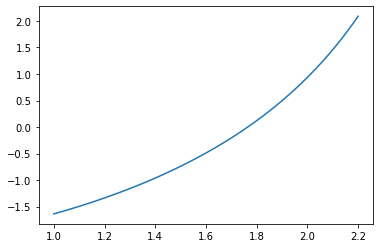

In [15]:
def equation(theta):
    return 4.5/np.sin(theta)*(1-np.cos(theta)) + 2.25/(np.sin(theta)**2)*(np.sin(theta)*np.cos(theta)-theta)

def equation2(theta,delta_site=2.6):
    diff = (9-delta_site)/2
    return 2.25/((1+np.cos(theta))**2)*(np.pi-theta+np.sin(theta)*np.cos(theta))-diff

x_list = np.linspace(1,2.2,1000)
y_list = np.zeros(100)

y_list = equation2(x_list,0.8)

plt.plot(x_list,y_list)
theta_expect = x_list[np.argmin(abs(y_list))]
print(f"The theta is {theta_expect} rads or {theta_expect/np.pi*180}")
print(f"The radius is {1.5/(1+np.cos(theta_expect))} and curvature is {(1+np.cos(theta_expect))/1.5}")

In [94]:
    # Plot relationship for each time steps
    for time_step in range(0,len(GB_list_velocity_list),10):
        figure_name = f"figures/2D_velocity_signedcurvature_MI_step{time_step}_{case_name}.png"
        plt.figure()
        fig = plt.figure(figsize=(7, 7))
        plt.scatter(GB_list_curvature_list[time_step], GB_list_velocity_list[time_step],s=4,alpha=0.5)
        plt.xlabel("curvature", fontsize=18)
        plt.ylabel("velocity (voxel/step)", fontsize=18)
        plt.xlim([-0.6,0.6])
        plt.ylim([-10,10])
        # plt.savefig(figure_name, dpi=400,bbox_inches='tight')
        
        # plot velocity VS averaged curvature
        bin_interval = 0.001
        bin_number = int(1.2/bin_interval)
        curvature_coordinate = np.arange(-0.6,0.6,bin_interval)+bin_interval/2

        curvature_bin = np.zeros(bin_number)
        velocity_bin = np.zeros(bin_number)
        for index in range(len(GB_list_curvature_list[time_step])):
            if abs(GB_list_curvature_list[time_step][index])>0.6: continue
            curvature_bin[int((GB_list_curvature_list[time_step][index]+0.6)//bin_interval)] += 1
            velocity_bin[int((GB_list_curvature_list[time_step][index]+0.6)//bin_interval)] += GB_list_velocity_list[time_step][index]
        for i in range(bin_number): 
            if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
        # plot
        figure_name_all_bin = f"figures/2D_velocity_signedcurvature_step{time_step}_{case_name}_afterBin.png"
        plt.figure()
        fig = plt.figure(figsize=(7, 7))
        # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
        plt.plot(curvature_coordinate, velocity_bin,'o', linewidth=2)
        plt.xlabel("curvature", fontsize=18)
        plt.ylabel("velocity (voxel/step)", fontsize=18)
        plt.xlim([-0.6,0.6])
        plt.ylim([-5,5])
        # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')

In [74]:
for key in GB_id_focus:
    if GB_id_focus[key] > 3:
        print(f"{key}: {GB_id_focus_detail[key]}")
        for time_step in GB_id_focus_detail[key]:
            if key_focus in GB_infomation_dict_list[time_step]:
                # Calculate dV
                pair_id_pair_focus = GB_infomation_dict_list[time_step][key_focus][6:8]
                growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair_focus[0])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[1])
                growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair_focus[1])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[0])
                dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
                # Calculate velocity
                velocity = dV/time_interval/(GB_infomation_dict_list[time_step][key_focus][5]/2)
                current_curvature_value = GB_infomation_dict_list[time_step][key_focus][4]
                # print(f">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> {time_step}: k {current_curvature_value} v {velocity}")
                
                # filter
                if abs(current_curvature_value) > 0.02:
                    print(f">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> {time_step}: k {current_curvature_value} v {velocity}")


60888545: [2, 4, 6, 7, 78, 80]
109693155: [3, 4, 8, 10]
93849979: [3, 4, 5, 7, 13, 14, 84, 86]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 84: k -0.026294891530899006 v -0.006578947368421052
30800140: [3, 5, 13, 14, 16]
6703376: [4, 6, 11, 13, 14]
99751854: [5, 7, 8, 41, 43]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 43: k 0.02120586195503531 v 0.06491885143570536
163809019: [5, 6, 8, 9]
85455519: [27, 28, 31, 33, 34, 35]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 31: k 0.020661086028804728 v -0.14027777777777778
191769608: [5, 7, 8, 10]
19800604: [5, 7, 63, 65]
48496731: [5, 7, 9, 10]
77851679: [8, 9, 14, 15]
119258745: [6, 7, 11, 13]
148113622: [38, 39, 87, 89]
178052944: [59, 61, 63, 71, 73]
136756953: [35, 36, 67, 69, 73, 75]
43252148: [30, 31, 43, 44]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 31: k 0.020661086028804728 v -0.14027777777777778
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 43: k 0.02120586195503531 v 0.06491885143570536
82082574: [7, 8, 20, 22]
50114269: [7, 8, 65, 66, 74, 76, 77, 78]

The anti-curvature step 32 has velocity - -0.035 and curvature - 0.005.
The anti-curvature step 35 has velocity - -0.001 and curvature - 0.012.
The anti-curvature step 36 has velocity - 0.055 and curvature - -0.01.
The anti-curvature step 37 has velocity - 0.013 and curvature - -0.013.
The anti-curvature step 39 has velocity - 0.052 and curvature - -0.008.
The anti-curvature step 40 has velocity - 0.065 and curvature - -0.003.
The anti-curvature step 49 has velocity - 0.032 and curvature - -0.006.
The anti-curvature step 51 has velocity - -0.007 and curvature - 0.004.
The anti-curvature step 57 has velocity - 0.017 and curvature - -0.005.
The anti-curvature step 58 has velocity - 0.01 and curvature - -0.016.
The anti-curvature step 62 has velocity - 0.047 and curvature - -0.01.
The anti-curvature step 63 has velocity - -0.042 and curvature - 0.001.
The anti-curvature step 64 has velocity - 0.049 and curvature - -0.001.
The anti-curvature step 65 has velocity - 0.059 and curvature - -0.

Text(0.5, 1.0, 'GBid 183489282 step all')

<Figure size 432x288 with 0 Axes>

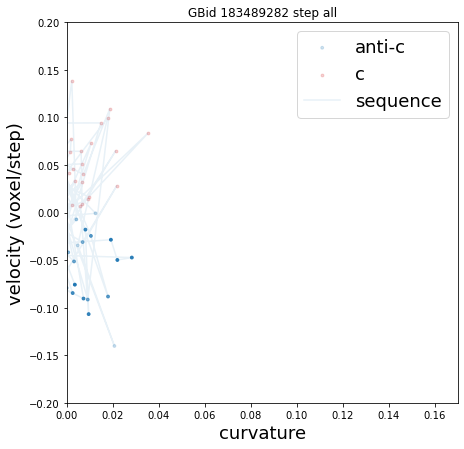

In [45]:
# Get more information for a focus GB

# key_focus = 0
# for key in GB_id_focus:
#     if GB_id_focus[key] == 19: 
#         print(f"The longest anti-curvature behavior is {key} with steps {GB_id_focus[key]}")
#         key_focus = key
#         # break
        
key_focus = 183489282

v_focus = []
c_focus = []
for time_step in range(0,step_num):
    if key_focus in GB_infomation_dict_list[time_step]:
        # Calculate dV
        pair_id_pair_focus = GB_infomation_dict_list[time_step][key_focus][6:8]
        growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair_focus[0])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[1])
        growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair_focus[1])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[0])
        dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
        # Calculate velocity
        velocity = dV/time_interval/(GB_infomation_dict_list[time_step][key_focus][5]/2)
        current_curvature_value = GB_infomation_dict_list[time_step][key_focus][4]
        
        # make curvature always opposite
        # if current_curvature_value<0: 
        #     current_curvature_value = -current_curvature_value
        #     velocity = -velocity
        
        # store v-c for a focus GB
        v_focus.append(velocity)
        c_focus.append(current_curvature_value)
        
        if current_curvature_value*velocity<-0.00 and GB_infomation_dict_list[time_step][key_focus][5]>=100: 
            print(f"The anti-curvature step {time_step} has velocity - {round(velocity,3)} and curvature - {round(current_curvature_value,3)}.")
        
        

v_focus = np.array(v_focus)
c_focus = np.array(c_focus)
# plot v-c for a focus GB
wanted_steps = v_focus<0
alpha_list = np.linspace(0.2,1,np.sum(wanted_steps))

figure_name_one_GB = f"figures/2D_velocity_signedcurvature_{case_name}_GB{key_focus}_5d.png"
plt.figure()
fig = plt.figure(figsize=(7, 7))
import matplotlib as mpl
cmap = mpl.colormaps['tab20']
colors = cmap(np.linspace(0, 1, 20))
plt.scatter(c_focus[wanted_steps], v_focus[wanted_steps],s=8,alpha=alpha_list,color=colors[0])
plt.scatter(c_focus[~wanted_steps], v_focus[~wanted_steps],s=8,alpha=0.2,color=colors[6])
plt.plot(c_focus,v_focus,alpha=0.1)
plt.xlabel("curvature", fontsize=18)
plt.ylabel("velocity (voxel/step)", fontsize=18)
plt.xlim([0,0.17])
plt.ylim([-0.2,0.2])
plt.legend(["anti-c", "c", "sequence"],fontsize=18)
plt.title(f"GBid {key_focus} step all")
# plt.savefig(figure_name_one_GB, dpi=400,bbox_inches='tight')






In [212]:
import os
os.system(f'ffmpeg -framerate 10 -i /home/lin.yang/projects/VECTOR/examples/GB_velocity/anti_curvature_figures/Detail_2D_microstructure_key145919744_step.%04d._M_20k.png \
                    -c:v libx264 -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" -pix_fmt yuv420p \
                    anti_curvature_figures/Detail_2D_microstructure_key145919744_M_20k.mp4')

ffmpeg version 4.3.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.3.0 (GCC)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1645955405450/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1645955405450/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1645955405450/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  l

0

The id pairs are [5335, 18523]


100%|██████████| 12/12 [00:00<00:00, 12.59it/s]


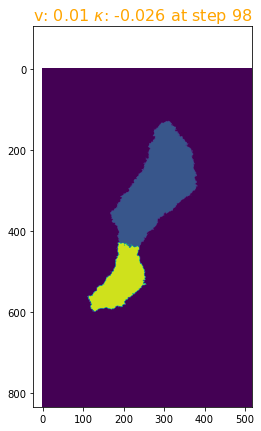

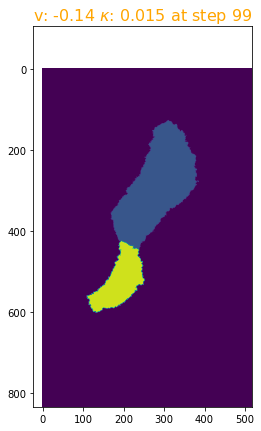

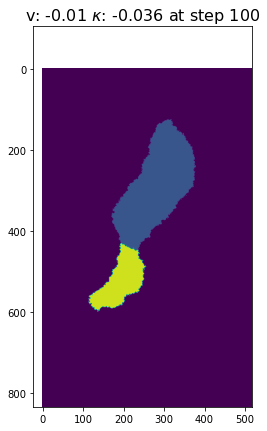

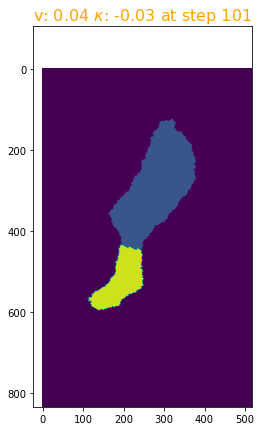

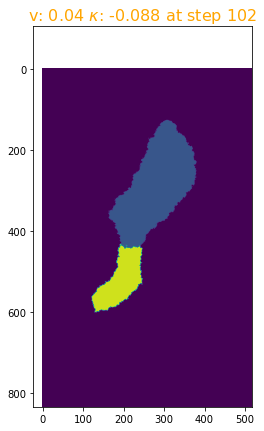

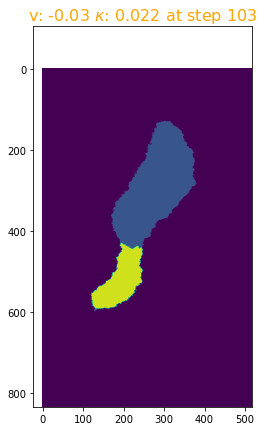

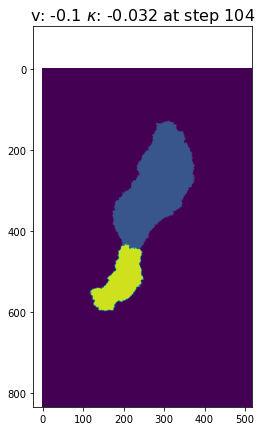

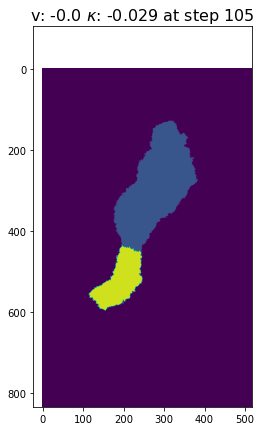

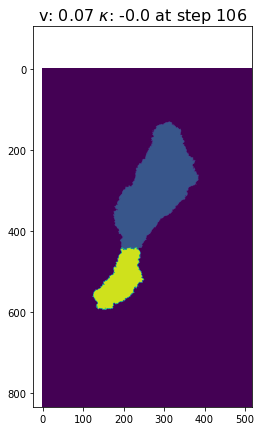

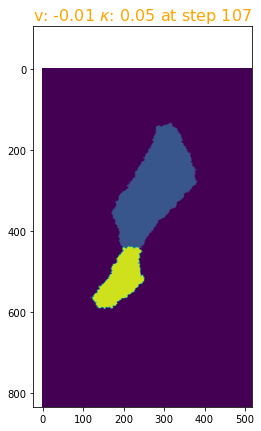

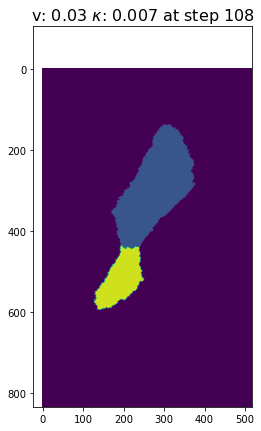

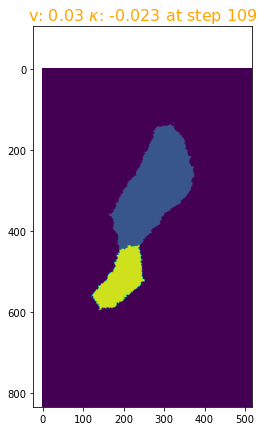

In [44]:
# 197673737
# 47836998
# fully 88634987
# fully 161070774
# fully 30685022
# 145919744
# Find the exaxt grain id and time steps
GB_id = 171546838
for time_step in range(40,step_num):
    if GB_id not in GB_infomation_dict_list[time_step]: continue
    pair_id_pair_focus = GB_infomation_dict_list[time_step][GB_id][6:8]
    break
print(f"The id pairs are {list(map(int,pair_id_pair_focus))}")

time_step_init, time_step_end = 98, 110
check_edge = 0
ss = 0
for time_step in tqdm(range(time_step_init,time_step_end)):
    current_microstructure_focus = npy_file_aniso[time_step,:,:,0]
    grain_location_focus = (current_microstructure_focus==pair_id_pair_focus[0]) + (current_microstructure_focus==pair_id_pair_focus[1])
    if check_edge ==0:
        x_info = np.arange(0,2400,1)[np.sum(grain_location_focus,0)*np.arange(0,2400,1)>0]
        x_len = np.sum(x_info>0)
        x_lim_max = int(np.max(x_info)+(x_len/2))
        x_lim_min = int(np.min(x_info)-(x_len/2))
        y_info = np.arange(0,2400,1)[np.sum(grain_location_focus,1)*np.arange(0,2400,1)>0]
        y_len = np.sum(y_info>0)
        y_lim_max = int(np.max(y_info)+y_len/2)
        y_lim_min = int(np.min(y_info)-y_len/2)
        check_edge+=1
    if np.sum(grain_location_focus)==0: continue
    current_microstructure_focus_updated = current_microstructure_focus*grain_location_focus
    
    if GB_id in GB_infomation_dict_list[time_step]:
        # Calculate velocity
        growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair_focus[0])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[1])
        growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair_focus[1])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[0])
        dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
        # Calculate velocity
        velocity = dV/time_interval/(GB_infomation_dict_list[time_step][GB_id][5]/2)
        current_curvature_value = GB_infomation_dict_list[time_step][GB_id][4]
    else:
        velocity = 0
        current_curvature_value = 0
    
    if ss<10:
        ss_char = f'0{ss}'
    else:
        ss_char = f'{ss}'
    ss+=1
    figure_name_anti_curvature_detail = figure_name_anti_curvature = f"anti_curvature_figures/Detail_2D_microstructure_key{GB_id}_step.00{ss_char}._{case_name}.png"
    plt.figure(figsize=(7,7))
    plt.imshow(current_microstructure_focus_updated,vmin=0,vmax=20000)
    plt.xlim([x_lim_min, x_lim_max])
    plt.ylim([y_lim_max, y_lim_min])
    if round(velocity,2)*round(current_curvature_value,3)<0:
        plt.title(rf"v: {round(velocity,2)} $\kappa$: {round(current_curvature_value,3)} at step {time_step}", color='orange', fontsize=16)
    else:
        plt.title(rf"v: {round(velocity,2)} $\kappa$: {round(current_curvature_value,3)} at step {time_step}", fontsize=16)
    # plt.axis("off")
    # plt.savefig(figure_name_anti_curvature_detail, dpi=400,bbox_inches='tight')

In [80]:

def energy_function_m_axis(m_polar_angle, m_azimuth_angle):
    return abs(np.cos(m_azimuth_angle)) * m_polar_angle / np.pi

def energy_function_m_axis_new(m_polar_angle, m_azimuth_angle):
    # ss = abs(np.cos(m_azimuth_angle/2)) + abs(np.cos(m_polar_angle))
    
    ss = (abs(np.cos(m_azimuth_angle/2))**0.4 + abs(np.cos(m_polar_angle))**0.4)
    if ss > 1: return 1
    else: return ss
    
    # if abs(m_azimuth_angle-np.pi) < np.pi/18 and abs(m_polar_angle - np.pi/2) < np.pi/36: return 0.0
    # else: return 1.0
    
    # return (abs(np.cos(m_azimuth_angle/2))**1.0 + abs(np.cos(m_polar_angle))**1.0)

def energy_function_m(m_polar_angle, m_azimuth_angle, m_angle):
    max_m_angle = 10/180*np.pi
    if m_angle == 0: return 0
    if m_angle>max_m_angle: m_angle=max_m_angle-0.00001
    m_angle_impact = m_angle/max_m_angle*(1-np.log(m_angle/max_m_angle))
    return energy_function_m_axis_new(m_polar_angle, m_azimuth_angle)*m_angle_impact

def energy_function_i_axis(i_polar_angle, i_azimuth_angle):
    return 0.3 + abs(np.cos(i_azimuth_angle)) * (0.7 + i_polar_angle / (np.pi/2) * (0.3 - 0.7))

def energy_function_final(m_polar_angle, m_azimuth_angle, m_angle, i_polar_angle, i_azimuth_angle):
    
    if i_polar_angle>np.pi/2: i_polar_angle = np.pi-i_polar_angle
    m_energy_impact = energy_function_m(m_polar_angle, m_azimuth_angle, m_angle)
    return 0.3 + abs(np.cos(i_azimuth_angle)) * (0.7*m_energy_impact + i_polar_angle / (np.pi/2) * (0.3*m_energy_impact - 0.7*m_energy_impact))


def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

In [79]:
# # Plot The change of inclination or misorientation in one specific GB

# # Misorientation
# init_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_multiCoreCompare/IC/"
# init_file_name = f"Case4.init"
# # misorientation calculation preparation
# grain_nums = 20000
# Osym = 24
# symm2quat_matrix, quartAngle = post_processing.pre_operation_misorientation(grain_nums, init_file_folder + init_file_name, Osym)
# print("> Pre-work done")

# misorientation = post_processing.multiP_calM(list(map(int,pair_id_pair_focus)), quartAngle, symm2quat_matrix, Osym)
# misorientation_angle = misorientation[0] # miso angle in randians
# misorientation_axis = misorientation[1:]

# # misorientation energy
# m_polar_angle = math.acos(round(misorientation_axis[2],3))
# m_azimuth_angle = math.atan2(misorientation_axis[1], misorientation_axis[0]) + np.pi
# print(f"The m-angle: {misorientation_angle/np.pi*180}, m_polar_angle: {m_polar_angle/np.pi*180}, m_azimuth_angle: {m_azimuth_angle/np.pi*180}")
# print(f"The misorientation energy: {energy_function_m(m_polar_angle, m_azimuth_angle, misorientation_angle)}")



In [78]:
# # inclination
# GB_infomation_inc_dict_list = []
# for time_step in tqdm(range(step_num)):
#     data_file_name = f"GB_velocity_data/2D_inclination_velocity_data_{case_name}_step{time_step}.npz"
#     if os.path.exists(data_file_folder + data_file_name):
#         npz_file = np.load(data_file_folder + data_file_name,allow_pickle=True)
#         GB_infomation_inc_dict = npz_file["GB_infomation_dict"]
#         GB_infomation_inc_dict_list.append(GB_infomation_inc_dict.item())
#     else:
#         print(f"Please run inclination-velocity analysis for {case_name}")
#         break

# time_interval = 30
# GB_inclination_energy_list = []
# GB_final_energy_list = []
# GB_velocity_list = []
# for time_step in range(step_num):
#     if time_step+1 >= step_num: continue
#     if key_focus not in GB_infomation_inc_dict_list[time_step]: continue
#     if GB_infomation_inc_dict_list[time_step+1].get(key_focus) is None: continue
#     # Calculate volumn change
#     growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair_focus[0])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[1])
#     growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair_focus[1])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[0])
#     dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
#     # Calculate velocity
#     velocity = dV/time_interval/(GB_infomation_inc_dict_list[time_step][key_focus][6]/2)
#     # change velocity sign with curvature
#     current_curvature_value = GB_infomation_dict_list[time_step][key_focus][4]
#     # make curvature always opposite
#     if current_curvature_value<0: 
#         current_curvature_value = -current_curvature_value
#         velocity = -velocity
    
#     GB_velocity_list.append(velocity)

#     # Get inclination
#     DX, DY = GB_infomation_inc_dict_list[time_step][key_focus][4:6]
#     vec_len = np.sqrt(DX**2+DY**2)
#     if vec_len==0: dx, dy = 0, 0
#     else: dx, dy = -DX/vec_len, DY/vec_len # the process just repeated get_grad(P,i,j) in myInput.py 
#     dz = 0
#     dy = -dy # Update the issue in VECTOR
#     inclination = np.array([dx,dy,dz])
#     # Get misorientation
#     # rotate misorientation axis to z axis, and incliantion to final vector
#     z_axis = np.array([0,0,1])
#     rotation_matrix_m_axis_to_z_axis = rotation_matrix_from_vectors(misorientation_axis, z_axis)
#     incliantion_refer_m_axis = rotation_matrix_m_axis_to_z_axis.dot(inclination)
#     # Get polar and azimuth dsitribution
#     i_polar_angle = math.acos(round(incliantion_refer_m_axis[2],3))
#     i_azimuth_angle = math.atan2(incliantion_refer_m_axis[1], incliantion_refer_m_axis[0]) + np.pi
    
#     # inclination energy
#     inclination_energy = energy_function_i_axis(i_polar_angle, i_azimuth_angle)
#     final_energy = energy_function_final(m_polar_angle, m_azimuth_angle, misorientation_angle, i_polar_angle, i_azimuth_angle)
#     GB_inclination_energy_list.append(inclination_energy)
#     GB_final_energy_list.append(final_energy)
#     # print(inclination_energy)
#     # print(final_energy)
#     # print()




In [77]:

# GB_inclination_energy_list = np.array(GB_inclination_energy_list)
# GB_velocity_list = np.array(GB_velocity_list)
# GB_final_energy_list = np.array(GB_final_energy_list)

# wanted_steps = GB_velocity_list<0
# alpha_list = np.linspace(0.2,1,np.sum(wanted_steps))
# figure_name_one_GB = f"figures/2D_velocity_inclinationE_{case_name}_GB{key_focus}_5d.png"
# plt.figure()
# fig = plt.figure(figsize=(7, 7))
# import matplotlib as mpl
# cmap = mpl.colormaps['tab20']
# colors = cmap(np.linspace(0, 1, 20))
# plt.scatter(GB_inclination_energy_list[wanted_steps], GB_velocity_list[wanted_steps],s=8,alpha=alpha_list,c=colors[0])
# plt.scatter(GB_inclination_energy_list[~wanted_steps], GB_velocity_list[~wanted_steps],s=8,alpha=0.2,c=colors[6])
# plt.plot(GB_inclination_energy_list,GB_velocity_list,alpha=0.1)
# plt.xlabel("inclination energy", fontsize=18)
# plt.ylabel("velocity (voxel/step)", fontsize=18)
# # plt.xlim([0.334,0.35])
# plt.ylim([-0.2,0.2])
# plt.legend(["anti-c", "c", "sequence"],fontsize=18)
# plt.title(f"GBid {key_focus} step all")
# # plt.savefig(figure_name_one_GB, dpi=400,bbox_inches='tight')

## TJ study


In [13]:
    # GB_id_unfocus_lowE_detail and GB_id_focus_detail
    
    # reorginaize the data structure for GB_id_unfocus_lowE_detail and GB_id_focus_detail
    GB_id_unfocus_lowE_detail_time = dict()
    GB_id_focus_detail_time = dict()
    for key in GB_id_unfocus_lowE_detail:
        for key_time in GB_id_unfocus_lowE_detail[key]:
            if key_time in GB_id_unfocus_lowE_detail_time:
                GB_id_unfocus_lowE_detail_time[key_time].append(key)
            else: 
                GB_id_unfocus_lowE_detail_time[key_time] = [key]
                
    for key in GB_id_focus_detail:
        for key_time in GB_id_focus_detail[key]:
            if key_time in GB_id_focus_detail_time:
                GB_id_focus_detail_time[key_time].append(key)
            else:
                GB_id_focus_detail_time[key_time] = [key]

In [15]:
#     # GB_id_unfocus_lowE_detail and GB_id_focus_detail
    
#     # reorginaize the data structure for GB_id_unfocus_lowE_detail and GB_id_focus_detail
#     GB_id_unfocus_lowE_detail_time = dict()
#     GB_id_focus_detail_time = dict()
#     for key in GB_id_unfocus_lowE_detail:
#         for key_time in GB_id_unfocus_lowE_detail[key]:
#             if key_time in GB_id_unfocus_lowE_detail_time:
#                 GB_id_unfocus_lowE_detail_time[key_time].append(key)
#             else: 
#                 GB_id_unfocus_lowE_detail_time[key_time] = [key]
                
#     for key in GB_id_focus_detail:
#         for key_time in GB_id_focus_detail[key]:
#             if key_time in GB_id_focus_detail_time:
#                 GB_id_focus_detail_time[key_time].append(key)
#             else:
#                 GB_id_focus_detail_time[key_time] = [key]
            
            
#     # find the TJ around GB with anti-c behavior or low energy c behavior 
#     site_energy_per_unit_focus_list = []
#     site_energy_per_unit_unfocus_list = []
#     for time_step in tqdm(range(step_num)):
        
#         if time_step not in GB_id_focus_detail_time: current_focus_GB_id = []
#         else: current_focus_GB_id = GB_id_focus_detail_time[time_step]
#         if time_step not in GB_id_unfocus_lowE_detail_time: current_unfocus_GB_id = []
#         else: current_unfocus_GB_id = GB_id_unfocus_lowE_detail_time[time_step]
#         if len(current_focus_GB_id) == 0 and len(current_unfocus_GB_id) == 0: continue
#         # current_GB_id = []
#         # current_GB_id.extend(current_focus_GB_id)
#         # current_GB_id.extend(current_unfocus_GB_id)
#         current_microstructure = npy_file_aniso[time_step]
#         current_energy = npy_file_aniso_energy[time_step]
        
        

        
#         size_x, size_y = npy_file_aniso[time_step].shape[0:2]
#         k=0
#         for i in range(size_x):
#             for j in range(size_y):

#                 ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
#                 # find window and jump over GB and grain bulk
#                 neighboring_sites_full_list = np.array([current_microstructure[i,j,k], current_microstructure[ip,jp,k], current_microstructure[ip,j,k], current_microstructure[ip,jm,k], current_microstructure[i,jp,k], current_microstructure[i,jm,k], current_microstructure[im,jp,k], current_microstructure[im,j,k], current_microstructure[im,jm,k]]).astype(int)
#                 grain_id_num_in_window = np.unique(neighboring_sites_full_list)
#                 if len(grain_id_num_in_window) < 3: continue
                
#                 # 
#                 do_you_find = 0
#                 for current_key in current_focus_GB_id:
#                     pair_id_pair_focus = GB_infomation_dict_list[time_step][current_key][6:8]
#                     if pair_id_pair_focus[0] in grain_id_num_in_window and pair_id_pair_focus[0] in grain_id_num_in_window:
#                         # do 
#                         site_energy = current_energy[i,j,k]
#                         num_nei = 0
#                         for nei in neighboring_sites_full_list[1:]:
#                             if neighboring_sites_full_list[0] != nei: num_nei += 1
#                         site_energy_per_unit_focus_list.append(site_energy/num_nei)
#                         do_you_find += 1
#                         break
#                 if do_you_find > 0: continue
#                 for current_key in current_unfocus_GB_id:
#                     pair_id_pair_focus = GB_infomation_dict_list[time_step][current_key][6:8]
#                     if pair_id_pair_focus[0] in grain_id_num_in_window and pair_id_pair_focus[0] in grain_id_num_in_window:
#                         # do 
#                         site_energy = current_energy[i,j,k]
#                         num_nei = 0
#                         for nei in neighboring_sites_full_list[1:]:
#                             if neighboring_sites_full_list[0] != nei: num_nei += 1
#                         site_energy_per_unit_unfocus_list.append(site_energy/num_nei)
#                         break
                        
                
#     xLim = [0,2.0]
#     binValue = 0.01001
#     binNum = round((abs(xLim[0])+abs(xLim[1]))/binValue)
#     xCor = np.linspace((xLim[0]+binValue/2),(xLim[1]-binValue/2),binNum)
#     freqArray_focus = np.zeros(binNum)
#     freqArray_unfocus = np.zeros(binNum)

#     for i in range(len(site_energy_per_unit_focus_list)): freqArray_focus[int((site_energy_per_unit_focus_list[i] - xCor[0]) / binValue)] += 1
#     for i in range(len(site_energy_per_unit_unfocus_list)): freqArray_unfocus[int((site_energy_per_unit_unfocus_list[i] - xCor[0]) / binValue)] += 1
        
            
            
            

In [ ]:
#     freqArray_focus = freqArray_focus/np.sum(freqArray_focus)
#     freqArray_unfocus = freqArray_unfocus/np.sum(freqArray_unfocus)

#     plt.figure(figsize=(7,7))
#     plt.plot(xCor, freqArray_focus, label='anti-c')
#     plt.plot(xCor, freqArray_unfocus, label='c')
#     plt.xlim([0.25,1.05])
#     # plt.ylim([-0.15,0.15])
#     plt.xlabel("GB energy", fontsize=18)
#     plt.ylabel("Frequency", fontsize=18)
#     plt.legend(fontsize=18)
#     # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')


## TJ movement

In [14]:
    # GB_id_unfocus_lowE_detail and GB_id_focus_detail
    # Compare the TJ movement around anti-c GBs and all TJ movement
            
    # TJ information
    step_num = 121
    TJ_information_dict_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name_TJ = f"GB_velocity_data/2D_TJ_information_data_{case_name}_step{time_step}.npz"
        
        if os.path.exists(data_file_folder + data_file_name_TJ):
            npz_file = np.load(data_file_folder + data_file_name_TJ,allow_pickle=True)
            TJ_information_dict = npz_file["TJ_information_dict"]
            TJ_information_dict_list.append(TJ_information_dict.item())
        else:
            TJ_information_dict = dict()
            current_microstructure = npy_file_aniso[time_step]
            current_energy = npy_file_aniso_energy[time_step]

            size_x, size_y = npy_file_aniso[time_step].shape[0:2]
            k=0
            for i in range(size_x):
                for j in range(size_y):
                    ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                    # find window and jump over GB and grain bulk
                    neighboring_sites_full_list = np.array([current_microstructure[i,j,k], current_microstructure[ip,jp,k], current_microstructure[ip,j,k], current_microstructure[ip,jm,k], current_microstructure[i,jp,k], current_microstructure[i,jm,k], current_microstructure[im,jp,k], current_microstructure[im,j,k], current_microstructure[im,jm,k]]).astype(int)
                    # neighboring_sites_full_list = np.array([current_microstructure[i,j,k], current_microstructure[ip,jp,k], current_microstructure[ip,j,k], current_microstructure[i,jp,k]]).astype(int)
                    grain_id_num_in_window = np.unique(neighboring_sites_full_list) # the result is in order [1,2,3]
                    TJ_key_tuple = tuple(grain_id_num_in_window)
                    if len(grain_id_num_in_window) != 3: continue # jump over GBs and bulks and QJs

                    # keep TJ information
                    if TJ_key_tuple in TJ_information_dict:
                        # take the voxel on the edge into account
                        known_location = TJ_information_dict[TJ_key_tuple][:3]/TJ_information_dict[TJ_key_tuple][4]
                        current_location = np.array([i,j,k])
                        location_distance = known_location-current_location
                        location_distance_bool = abs(location_distance)>size_x/2
                        if np.sum(location_distance_bool)>0: 
                            i_new,j_new,k_new = current_location + (location_distance*location_distance_bool>0)*size_x+(location_distance*location_distance_bool<0)*-size_x
                            TJ_information_dict[TJ_key_tuple] += np.array([i_new,j_new,k_new, current_energy[i,j,k], 1])
                        else: 
                            TJ_information_dict[TJ_key_tuple] += np.array([i,j,k, current_energy[i,j,k], 1])
                    else:
                        TJ_information_dict[TJ_key_tuple] = np.array([i,j,k, current_energy[i,j,k], 1]) # i,j,k,TJenergy,TJnum
            # finish the normalize
            for TJ_key in TJ_information_dict:
                TJ_information_dict[TJ_key][:4] = TJ_information_dict[TJ_key][:4]/TJ_information_dict[TJ_key][4]
                if np.sum(TJ_information_dict[TJ_key][:3] < 0):
                    TJ_information_dict[TJ_key][:3] = TJ_information_dict[TJ_key][:3] + (TJ_information_dict[TJ_key][:3] < 0)*size_x
                elif np.sum(TJ_information_dict[TJ_key][:3] >size_x):
                    TJ_information_dict[TJ_key][:3] = TJ_information_dict[TJ_key][:3] + (TJ_information_dict[TJ_key][:3] < 0)*-size_x
            
            print(f"TJs in {time_step} step is {len(TJ_information_dict)}")
            wierd_TJ = 0
            for TJ_info in TJ_information_dict.values():
                if TJ_info[4] < 4: wierd_TJ+=1
            print(f"Weird TJs is {wierd_TJ}")
            # save information
            np.savez(data_file_folder + data_file_name_TJ, TJ_information_dict=TJ_information_dict)
            TJ_information_dict_list.append(TJ_information_dict)

            

100%|██████████| 121/121 [00:24<00:00,  4.85it/s]


In [15]:
    # extract TJ velocity
    time_interval = 30
    TJ_velocity_list = []
    TJ_velocity_1Dlist = []
    TJ_focus_velocity_list = []
    TJ_focus_velocity_1Dlist = []
    TJ_energy_list = []
    TJ_energy_1Dlist = []
    TJ_focus_energy_list = []
    TJ_focus_energy_1Dlist = []
    TJ_GBenergy_list = []
    TJ_GBenergy_1Dlist = []
    TJ_GBenergy_1Dlist_three = [[],[],[]]
    TJ_GBenergy_1Dlist_diff_three = [[],[],[]]
    TJ_focus_GBenergy_list = []
    TJ_focus_GBenergy_1Dlist = []
    TJ_focus_GBenergy_1Dlist_three = [[],[],[]]
    TJ_focus_GBenergy_1Dlist_diff_three = [[],[],[]]
    # dict for GB
    GB_with_four_GBenergy_diff = dict()
    GB_focus_with_four_GBenergy_diff = dict()
    for time_step in range(step_num):
        if time_step + 1 >= step_num: continue
        TJ_velocity_list_tmp = []
        TJ_energy_list_tmp = []
        TJ_focus_velocity_list_tmp = []
        TJ_focus_energy_list_tmp = []
        TJ_GBenergy_list_tmp = []
        TJ_GBenergy_list_three_tmp = []
        TJ_focus_GBenergy_list_tmp = []
        TJ_focus_GBenergy_list_three_tmp = []
        for TJ_key in tqdm(TJ_information_dict_list[time_step]):
            if TJ_information_dict_list[time_step+1].get(TJ_key) is None: continue
            edge_matrix = np.array([[size_x,0,0],[-size_x,0,0],[0,size_y,0],[0,-size_y,0],[size_x,size_y,0],[-size_x,-size_y,0],[-size_x,size_y,0],[size_x,-size_y,0]])
            
            # calculate three GB energy
            GB_key1_at_TJ = post_processing.get_line(TJ_key[0],TJ_key[1])
            GB_key2_at_TJ = post_processing.get_line(TJ_key[0],TJ_key[2])
            GB_key3_at_TJ = post_processing.get_line(TJ_key[1],TJ_key[2])
            if (GB_key1_at_TJ in GBenergy_information_dict_list[time_step] and
                GB_key2_at_TJ in GBenergy_information_dict_list[time_step] and
                GB_key3_at_TJ in GBenergy_information_dict_list[time_step]):
                
                GB_key1_energy = GBenergy_information_dict_list[time_step][GB_key1_at_TJ][4]
                GB_key2_energy = GBenergy_information_dict_list[time_step][GB_key2_at_TJ][4]
                GB_key3_energy = GBenergy_information_dict_list[time_step][GB_key3_at_TJ][4]
                GB_3keys_energy = [GB_key1_energy,GB_key2_energy,GB_key3_energy]
                GB_3keys_energy_left = [GB_key2_energy,GB_key3_energy,GB_key1_energy]
                GB_3keys_energy.sort()
                TJ_GBenergy_list_tmp.extend(GB_3keys_energy)
                TJ_GBenergy_1Dlist_three[0].append(GB_3keys_energy[0])
                TJ_GBenergy_1Dlist_three[1].append(GB_3keys_energy[1])
                TJ_GBenergy_1Dlist_three[2].append(GB_3keys_energy[2])
                GB_3diff_energy = abs(np.array(GB_3keys_energy_left) - np.array(GB_3keys_energy))
                TJ_GBenergy_1Dlist_diff_three[0].append(np.mean(GB_3diff_energy)) # ave
                TJ_GBenergy_1Dlist_diff_three[1].append(np.min(GB_3diff_energy)) # min
                TJ_GBenergy_1Dlist_diff_three[2].append(np.max(GB_3diff_energy)) # max
                
                # keep four GB energy diff for each GB
                for current_index, current_GB_key in enumerate([GB_key1_at_TJ,GB_key2_at_TJ,GB_key3_at_TJ]):
                    keep_energy_three = abs(np.array(GB_3keys_energy)-GB_3keys_energy[current_index])
                    keep_energy_two = np.delete(keep_energy_three, [current_index])
                    if (time_step,current_GB_key) in GB_with_four_GBenergy_diff:
                        GB_with_four_GBenergy_diff[(time_step,current_GB_key)].extend(list(keep_energy_two))
                        GB_with_four_GBenergy_diff[(time_step,current_GB_key)].extend([abs(keep_energy_two[1]-keep_energy_two[0])]) # add the third value for GB specific
                    else: 
                        GB_with_four_GBenergy_diff[(time_step,current_GB_key)] = list(keep_energy_two)
                        GB_with_four_GBenergy_diff[(time_step,current_GB_key)].extend([abs(keep_energy_two[1]-keep_energy_two[0])]) # add the third value for GB specific
                
                
            
            # get two points location
            location_next_step = TJ_information_dict_list[time_step+1][TJ_key][:3]
            location_current = TJ_information_dict_list[time_step][TJ_key][:3]
            # get distance between two points, "not in edge" and "in edge" cases
            if np.linalg.norm(location_next_step-location_current) < size_x/10:
                distance = np.linalg.norm(location_next_step-location_current)
            else:
                difference_8points = np.tile(location_next_step,(8,1)) + edge_matrix - np.tile(location_current,(8,1))
                distance_8points = np.linalg.norm(difference_8points,axis=1)
                distance = np.min(distance_8points)
            # calculate velocity
            velocity = distance / time_interval
            TJ_velocity_list_tmp.append(velocity)
            # TJ averaged energy
            TJ_energy = TJ_information_dict_list[time_step][TJ_key][3]
            TJ_energy_list_tmp.append(TJ_energy)
            
            # consider the TJ around the anti-c GB
            if time_step not in GB_id_focus_detail_time: continue
            else: current_focus_GB_id = GB_id_focus_detail_time[time_step]
            for GB_key in current_focus_GB_id:
                pair_id_pair_focus = GB_infomation_dict_list[time_step][GB_key][6:8]
                # We take the difference of two other GB and anti-c GB into account
                
#                 if pair_id_pair_focus[0] in TJ_key and pair_id_pair_focus[1] in TJ_key:
#                     # current TJ is around anti-c GB
#                     TJ_focus_velocity_list_tmp.append(velocity)
#                     TJ_focus_energy_list_tmp.append(TJ_energy)
                    
#                     # get the third grain id
#                     for grain_id in TJ_key:
#                         if grain_id not in pair_id_pair_focus:
#                             grain_id_third_grain = grain_id
                    
#                     # get the velocity direction
#                     growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair_focus[0])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[1])
#                     growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair_focus[1])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[0])
#                     dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
#                     velocity = dV/time_interval/(GB_infomation_dict_list[time_step][GB_key][5]/2) # 1 direction get negative, 0 get positive
#                     # Get the GB key same as velocity direction and opposite to v direciton
#                     if velocity>0:
#                         GB_key_positive_velocity = post_processing.get_line(pair_id_pair_focus[0],grain_id_third_grain)
#                         GB_key_negative_velocity = post_processing.get_line(pair_id_pair_focus[1],grain_id_third_grain)
#                     else:
#                         GB_key_positive_velocity = post_processing.get_line(pair_id_pair_focus[1],grain_id_third_grain)
#                         GB_key_negative_velocity = post_processing.get_line(pair_id_pair_focus[0],grain_id_third_grain)
                        
#                     if (GB_key_positive_velocity in GBenergy_information_dict_list[time_step] and
#                         GB_key_negative_velocity in GBenergy_information_dict_list[time_step] and
#                         GB_key in GBenergy_information_dict_list[time_step]):    
#                         TJ_focus_GBenergy_list_tmp.extend(GB_3keys_energy) # old information
                    
#                         # get the energy for the two GB keys
#                         GB_key_pv_energy = GBenergy_information_dict_list[time_step][GB_key_positive_velocity][4]
#                         GB_key_nv_energy = GBenergy_information_dict_list[time_step][GB_key_negative_velocity][4]
#                         GB_antic_energy = GBenergy_information_dict_list[time_step][GB_key][4]
#                         # keep
#                         TJ_focus_GBenergy_1Dlist_two[0].append(GB_key_pv_energy-GB_antic_energy)
#                         TJ_focus_GBenergy_1Dlist_two[1].append(GB_key_nv_energy-GB_antic_energy)
                    
#                     break # because each TJ will have maximum of one anti-c GB
                
                
                
                if pair_id_pair_focus[0] in TJ_key and pair_id_pair_focus[1] in TJ_key:
                    # current TJ is around anti-c GB
                    TJ_focus_velocity_list_tmp.append(velocity)
                    TJ_focus_energy_list_tmp.append(TJ_energy)
                    # calculate three GB energy
                    if (GB_key1_at_TJ in GBenergy_information_dict_list[time_step] and
                        GB_key2_at_TJ in GBenergy_information_dict_list[time_step] and
                        GB_key3_at_TJ in GBenergy_information_dict_list[time_step]):
                        TJ_focus_GBenergy_list_tmp.extend(GB_3keys_energy)
                        TJ_focus_GBenergy_1Dlist_three[0].append(GB_3keys_energy[0])
                        TJ_focus_GBenergy_1Dlist_three[1].append(GB_3keys_energy[1])
                        TJ_focus_GBenergy_1Dlist_three[2].append(GB_3keys_energy[2])
                        TJ_focus_GBenergy_1Dlist_diff_three[0].append(np.mean(GB_3diff_energy)) # ave
                        TJ_focus_GBenergy_1Dlist_diff_three[1].append(np.min(GB_3diff_energy)) # min
                        TJ_focus_GBenergy_1Dlist_diff_three[2].append(np.max(GB_3diff_energy)) # max
                        
                        # keep four GB energy difference on anti-c GB
                        GB_focus_with_four_GBenergy_diff[(time_step,GB_key)] = GB_with_four_GBenergy_diff[(time_step,GB_key)]
                    break
            
        
        print(f"All TJs in {time_step} step is {len(TJ_velocity_list_tmp)}, focused TJs is {len(TJ_focus_velocity_list_tmp)}")
        TJ_velocity_list.append(TJ_velocity_list_tmp)
        TJ_velocity_1Dlist.extend(TJ_velocity_list_tmp)
        TJ_focus_velocity_list.append(TJ_focus_velocity_list_tmp)
        TJ_focus_velocity_1Dlist.extend(TJ_focus_velocity_list_tmp)
        TJ_energy_list.append(TJ_energy_list_tmp)
        TJ_energy_1Dlist.extend(TJ_energy_list_tmp)
        TJ_focus_energy_list.append(TJ_focus_energy_list_tmp)
        TJ_focus_energy_1Dlist.extend(TJ_focus_energy_list_tmp)
        TJ_GBenergy_list.append(TJ_GBenergy_list_tmp)
        TJ_GBenergy_1Dlist.extend(TJ_GBenergy_list_tmp)
        TJ_focus_GBenergy_list.append(TJ_focus_GBenergy_list_tmp)
        TJ_focus_GBenergy_1Dlist.extend(TJ_focus_GBenergy_list_tmp)
        
    # clean the data for four GB energy on GB object
    GB_four_GBenergy_values = list(GB_with_four_GBenergy_diff.values())
    GB_focus_four_GBenergy_values = list(GB_focus_with_four_GBenergy_diff.values())
    GB_four_GBenergy_values_update = []
    GB_focus_four_GBenergy_values_update = []
    for i in range(len(GB_four_GBenergy_values)):
        if len(GB_four_GBenergy_values[i]) == 6: GB_four_GBenergy_values_update.append(GB_four_GBenergy_values[i])
    for i in range(len(GB_focus_four_GBenergy_values)):
        if len(GB_focus_four_GBenergy_values[i]) == 6: GB_focus_four_GBenergy_values_update.append(GB_focus_four_GBenergy_values[i])
    # only keep ave min max for it
    TJ_GBenergy_1Dlist_diff_four = [[],[],[]]
    TJ_GBenergy_1Dlist_diff_four_all = []
    TJ_focus_GBenergy_1Dlist_diff_four = [[],[],[]]
    TJ_focus_GBenergy_1Dlist_diff_four_all = []
    for i in range(len(GB_four_GBenergy_values_update)):
        TJ_GBenergy_1Dlist_diff_four[0].append(np.mean(GB_four_GBenergy_values_update[i]))
        TJ_GBenergy_1Dlist_diff_four[1].append(np.min(GB_four_GBenergy_values_update[i]))
        TJ_GBenergy_1Dlist_diff_four[2].append(np.max(GB_four_GBenergy_values_update[i]))
        TJ_GBenergy_1Dlist_diff_four_all.extend(GB_four_GBenergy_values_update[i])
    for i in range(len(GB_focus_four_GBenergy_values_update)):
        TJ_focus_GBenergy_1Dlist_diff_four[0].append(np.mean(GB_focus_four_GBenergy_values_update[i]))
        TJ_focus_GBenergy_1Dlist_diff_four[1].append(np.min(GB_focus_four_GBenergy_values_update[i]))
        TJ_focus_GBenergy_1Dlist_diff_four[2].append(np.max(GB_focus_four_GBenergy_values_update[i]))
        TJ_focus_GBenergy_1Dlist_diff_four_all.extend(GB_focus_four_GBenergy_values_update[i])
    


        

100%|██████████| 41448/41448 [00:00<00:00, 147396.66it/s]


All TJs in 0 step is 11563, focused TJs is 0


100%|██████████| 27217/27217 [00:00<00:00, 79347.61it/s]


All TJs in 1 step is 9291, focused TJs is 0


100%|██████████| 18768/18768 [00:00<00:00, 47784.70it/s]


All TJs in 2 step is 8544, focused TJs is 3


100%|██████████| 14209/14209 [00:00<00:00, 26185.33it/s]


All TJs in 3 step is 7757, focused TJs is 16


100%|██████████| 11461/11461 [00:00<00:00, 24033.06it/s]


All TJs in 4 step is 6722, focused TJs is 25


100%|██████████| 9538/9538 [00:00<00:00, 18708.74it/s]


All TJs in 5 step is 6116, focused TJs is 45


100%|██████████| 8145/8145 [00:00<00:00, 16677.63it/s]


All TJs in 6 step is 5675, focused TJs is 52


100%|██████████| 7179/7179 [00:00<00:00, 15186.54it/s]


All TJs in 7 step is 5204, focused TJs is 60


100%|██████████| 6409/6409 [00:00<00:00, 13865.17it/s]


All TJs in 8 step is 4820, focused TJs is 63


100%|██████████| 5813/5813 [00:00<00:00, 12018.79it/s]


All TJs in 9 step is 4400, focused TJs is 49


100%|██████████| 5274/5274 [00:00<00:00, 13488.68it/s]


All TJs in 10 step is 4177, focused TJs is 37


100%|██████████| 4857/4857 [00:00<00:00, 13020.27it/s]


All TJs in 11 step is 3890, focused TJs is 47


100%|██████████| 4484/4484 [00:00<00:00, 13180.25it/s]


All TJs in 12 step is 3658, focused TJs is 34


100%|██████████| 4189/4189 [00:00<00:00, 12489.14it/s]


All TJs in 13 step is 3461, focused TJs is 38


100%|██████████| 3896/3896 [00:00<00:00, 13221.27it/s]


All TJs in 14 step is 3255, focused TJs is 41


100%|██████████| 3665/3665 [00:00<00:00, 12551.24it/s]


All TJs in 15 step is 3112, focused TJs is 38


100%|██████████| 3449/3449 [00:00<00:00, 12647.30it/s]


All TJs in 16 step is 2983, focused TJs is 33


100%|██████████| 3293/3293 [00:00<00:00, 12154.69it/s]


All TJs in 17 step is 2781, focused TJs is 45


100%|██████████| 3116/3116 [00:00<00:00, 11966.04it/s]


All TJs in 18 step is 2671, focused TJs is 39


100%|██████████| 2950/2950 [00:00<00:00, 11777.39it/s]


All TJs in 19 step is 2593, focused TJs is 37


100%|██████████| 2829/2829 [00:00<00:00, 8057.98it/s]


All TJs in 20 step is 2476, focused TJs is 47


100%|██████████| 2699/2699 [00:00<00:00, 11489.14it/s]


All TJs in 21 step is 2374, focused TJs is 46


100%|██████████| 2594/2594 [00:00<00:00, 10576.58it/s]


All TJs in 22 step is 2272, focused TJs is 63


100%|██████████| 2473/2473 [00:00<00:00, 10700.05it/s]


All TJs in 23 step is 2241, focused TJs is 54


100%|██████████| 2401/2401 [00:00<00:00, 10937.23it/s]


All TJs in 24 step is 2119, focused TJs is 54


100%|██████████| 2307/2307 [00:00<00:00, 11213.33it/s]


All TJs in 25 step is 2070, focused TJs is 46


100%|██████████| 2229/2229 [00:00<00:00, 11051.28it/s]


All TJs in 26 step is 1988, focused TJs is 39


100%|██████████| 2157/2157 [00:00<00:00, 11351.32it/s]


All TJs in 27 step is 1933, focused TJs is 42


100%|██████████| 2084/2084 [00:00<00:00, 11561.89it/s]


All TJs in 28 step is 1846, focused TJs is 36


100%|██████████| 2000/2000 [00:00<00:00, 10792.32it/s]


All TJs in 29 step is 1803, focused TJs is 38


100%|██████████| 1921/1921 [00:00<00:00, 10234.44it/s]


All TJs in 30 step is 1758, focused TJs is 45


100%|██████████| 1874/1874 [00:00<00:00, 11459.26it/s]


All TJs in 31 step is 1686, focused TJs is 32


100%|██████████| 1800/1800 [00:00<00:00, 11403.19it/s]


All TJs in 32 step is 1650, focused TJs is 32


100%|██████████| 1749/1749 [00:00<00:00, 11486.66it/s]


All TJs in 33 step is 1588, focused TJs is 25


100%|██████████| 1703/1703 [00:00<00:00, 10769.30it/s]


All TJs in 34 step is 1579, focused TJs is 33


100%|██████████| 1679/1679 [00:00<00:00, 10663.35it/s]


All TJs in 35 step is 1566, focused TJs is 26


100%|██████████| 1648/1648 [00:00<00:00, 11120.14it/s]


All TJs in 36 step is 1516, focused TJs is 24


100%|██████████| 1598/1598 [00:00<00:00, 11459.51it/s]


All TJs in 37 step is 1479, focused TJs is 26


100%|██████████| 1565/1565 [00:00<00:00, 10934.62it/s]


All TJs in 38 step is 1442, focused TJs is 25


100%|██████████| 1520/1520 [00:00<00:00, 10459.42it/s]


All TJs in 39 step is 1399, focused TJs is 32


100%|██████████| 1473/1473 [00:00<00:00, 10146.59it/s]


All TJs in 40 step is 1361, focused TJs is 38


100%|██████████| 1441/1441 [00:00<00:00, 10589.65it/s]


All TJs in 41 step is 1341, focused TJs is 33


100%|██████████| 1409/1409 [00:00<00:00, 5514.89it/s]


All TJs in 42 step is 1290, focused TJs is 26


100%|██████████| 1379/1379 [00:00<00:00, 10953.90it/s]


All TJs in 43 step is 1289, focused TJs is 27


100%|██████████| 1354/1354 [00:00<00:00, 10689.85it/s]


All TJs in 44 step is 1256, focused TJs is 21


100%|██████████| 1324/1324 [00:00<00:00, 10479.67it/s]


All TJs in 45 step is 1253, focused TJs is 24


100%|██████████| 1299/1299 [00:00<00:00, 10688.25it/s]


All TJs in 46 step is 1225, focused TJs is 20


100%|██████████| 1279/1279 [00:00<00:00, 10224.57it/s]


All TJs in 47 step is 1195, focused TJs is 25


100%|██████████| 1252/1252 [00:00<00:00, 10782.21it/s]


All TJs in 48 step is 1179, focused TJs is 21


100%|██████████| 1230/1230 [00:00<00:00, 10669.13it/s]


All TJs in 49 step is 1153, focused TJs is 26


100%|██████████| 1205/1205 [00:00<00:00, 10841.90it/s]


All TJs in 50 step is 1140, focused TJs is 22


100%|██████████| 1185/1185 [00:00<00:00, 10944.36it/s]


All TJs in 51 step is 1134, focused TJs is 16


100%|██████████| 1178/1178 [00:00<00:00, 10889.13it/s]


All TJs in 52 step is 1098, focused TJs is 20


100%|██████████| 1146/1146 [00:00<00:00, 11580.42it/s]


All TJs in 53 step is 1078, focused TJs is 18


100%|██████████| 1130/1130 [00:00<00:00, 10884.91it/s]


All TJs in 54 step is 1047, focused TJs is 18


100%|██████████| 1103/1103 [00:00<00:00, 12539.31it/s]


All TJs in 55 step is 1041, focused TJs is 8


100%|██████████| 1083/1083 [00:00<00:00, 11373.22it/s]


All TJs in 56 step is 1019, focused TJs is 20


100%|██████████| 1064/1064 [00:00<00:00, 11396.60it/s]


All TJs in 57 step is 1026, focused TJs is 10


100%|██████████| 1055/1055 [00:00<00:00, 10813.89it/s]


All TJs in 58 step is 1004, focused TJs is 18


100%|██████████| 1038/1038 [00:00<00:00, 10046.35it/s]


All TJs in 59 step is 978, focused TJs is 24


100%|██████████| 1021/1021 [00:00<00:00, 10355.96it/s]


All TJs in 60 step is 963, focused TJs is 19


100%|██████████| 1007/1007 [00:00<00:00, 10305.44it/s]


All TJs in 61 step is 941, focused TJs is 22


100%|██████████| 985/985 [00:00<00:00, 10433.93it/s]


All TJs in 62 step is 915, focused TJs is 23


100%|██████████| 959/959 [00:00<00:00, 10054.36it/s]


All TJs in 63 step is 940, focused TJs is 28


100%|██████████| 954/954 [00:00<00:00, 11504.13it/s]


All TJs in 64 step is 916, focused TJs is 18


100%|██████████| 942/942 [00:00<00:00, 10359.78it/s]


All TJs in 65 step is 896, focused TJs is 24


100%|██████████| 931/931 [00:00<00:00, 10886.19it/s]


All TJs in 66 step is 890, focused TJs is 8


100%|██████████| 915/915 [00:00<00:00, 10522.44it/s]


All TJs in 67 step is 877, focused TJs is 15


100%|██████████| 905/905 [00:00<00:00, 11607.38it/s]


All TJs in 68 step is 848, focused TJs is 8


100%|██████████| 886/886 [00:00<00:00, 10956.48it/s]


All TJs in 69 step is 835, focused TJs is 10


100%|██████████| 869/869 [00:00<00:00, 10873.04it/s]


All TJs in 70 step is 838, focused TJs is 6


100%|██████████| 860/860 [00:00<00:00, 10950.22it/s]


All TJs in 71 step is 825, focused TJs is 14


100%|██████████| 847/847 [00:00<00:00, 11187.42it/s]


All TJs in 72 step is 809, focused TJs is 12


100%|██████████| 835/835 [00:00<00:00, 10704.76it/s]


All TJs in 73 step is 808, focused TJs is 10


100%|██████████| 826/826 [00:00<00:00, 10607.15it/s]


All TJs in 74 step is 784, focused TJs is 18


100%|██████████| 813/813 [00:00<00:00, 11307.09it/s]


All TJs in 75 step is 769, focused TJs is 17


100%|██████████| 796/796 [00:00<00:00, 11254.64it/s]


All TJs in 76 step is 753, focused TJs is 18


100%|██████████| 779/779 [00:00<00:00, 10785.72it/s]


All TJs in 77 step is 745, focused TJs is 12


100%|██████████| 772/772 [00:00<00:00, 11025.20it/s]


All TJs in 78 step is 729, focused TJs is 10


100%|██████████| 758/758 [00:00<00:00, 11659.35it/s]


All TJs in 79 step is 730, focused TJs is 8


100%|██████████| 753/753 [00:00<00:00, 10555.89it/s]


All TJs in 80 step is 729, focused TJs is 14


100%|██████████| 746/746 [00:00<00:00, 10981.13it/s]


All TJs in 81 step is 705, focused TJs is 6


100%|██████████| 734/734 [00:00<00:00, 10462.60it/s]


All TJs in 82 step is 695, focused TJs is 12


100%|██████████| 727/727 [00:00<00:00, 11493.41it/s]


All TJs in 83 step is 685, focused TJs is 8


100%|██████████| 713/713 [00:00<00:00, 10820.82it/s]


All TJs in 84 step is 685, focused TJs is 9


100%|██████████| 701/701 [00:00<00:00, 11317.41it/s]


All TJs in 85 step is 675, focused TJs is 2


100%|██████████| 696/696 [00:00<00:00, 10802.82it/s]


All TJs in 86 step is 666, focused TJs is 10


100%|██████████| 688/688 [00:00<00:00, 10768.79it/s]


All TJs in 87 step is 665, focused TJs is 8


100%|██████████| 676/676 [00:00<00:00, 10437.32it/s]


All TJs in 88 step is 655, focused TJs is 6


100%|██████████| 670/670 [00:00<00:00, 9921.35it/s]


All TJs in 89 step is 659, focused TJs is 15


100%|██████████| 666/666 [00:00<00:00, 11113.48it/s]


All TJs in 90 step is 648, focused TJs is 7


100%|██████████| 660/660 [00:00<00:00, 10430.17it/s]


All TJs in 91 step is 641, focused TJs is 6


100%|██████████| 654/654 [00:00<00:00, 10389.65it/s]


All TJs in 92 step is 635, focused TJs is 10


100%|██████████| 647/647 [00:00<00:00, 10574.80it/s]


All TJs in 93 step is 625, focused TJs is 8


100%|██████████| 638/638 [00:00<00:00, 10286.60it/s]


All TJs in 94 step is 621, focused TJs is 8


100%|██████████| 630/630 [00:00<00:00, 10499.18it/s]


All TJs in 95 step is 604, focused TJs is 5


100%|██████████| 622/622 [00:00<00:00, 10633.94it/s]


All TJs in 96 step is 604, focused TJs is 10


100%|██████████| 613/613 [00:00<00:00, 10814.29it/s]


All TJs in 97 step is 593, focused TJs is 6


100%|██████████| 606/606 [00:00<00:00, 2839.22it/s]


All TJs in 98 step is 588, focused TJs is 6


100%|██████████| 598/598 [00:00<00:00, 10695.33it/s]


All TJs in 99 step is 581, focused TJs is 6


100%|██████████| 596/596 [00:00<00:00, 10954.59it/s]


All TJs in 100 step is 570, focused TJs is 2


100%|██████████| 587/587 [00:00<00:00, 10491.21it/s]


All TJs in 101 step is 559, focused TJs is 8


100%|██████████| 575/575 [00:00<00:00, 10267.33it/s]


All TJs in 102 step is 565, focused TJs is 4


100%|██████████| 572/572 [00:00<00:00, 10002.26it/s]


All TJs in 103 step is 558, focused TJs is 15


100%|██████████| 568/568 [00:00<00:00, 10107.74it/s]


All TJs in 104 step is 557, focused TJs is 8


100%|██████████| 566/566 [00:00<00:00, 9970.50it/s]


All TJs in 105 step is 557, focused TJs is 12


100%|██████████| 562/562 [00:00<00:00, 10432.85it/s]


All TJs in 106 step is 541, focused TJs is 8


100%|██████████| 555/555 [00:00<00:00, 10994.69it/s]


All TJs in 107 step is 542, focused TJs is 6


100%|██████████| 554/554 [00:00<00:00, 10329.60it/s]


All TJs in 108 step is 540, focused TJs is 9


100%|██████████| 556/556 [00:00<00:00, 10500.35it/s]


All TJs in 109 step is 531, focused TJs is 15


100%|██████████| 545/545 [00:00<00:00, 10216.07it/s]


All TJs in 110 step is 536, focused TJs is 19


100%|██████████| 540/540 [00:00<00:00, 10720.16it/s]


All TJs in 111 step is 527, focused TJs is 4


100%|██████████| 536/536 [00:00<00:00, 10941.22it/s]


All TJs in 112 step is 525, focused TJs is 10


100%|██████████| 534/534 [00:00<00:00, 10332.23it/s]


All TJs in 113 step is 518, focused TJs is 10


100%|██████████| 531/531 [00:00<00:00, 10811.16it/s]


All TJs in 114 step is 518, focused TJs is 10


100%|██████████| 529/529 [00:00<00:00, 10423.25it/s]


All TJs in 115 step is 512, focused TJs is 12


100%|██████████| 521/521 [00:00<00:00, 10099.66it/s]


All TJs in 116 step is 507, focused TJs is 14


100%|██████████| 519/519 [00:00<00:00, 10455.94it/s]


All TJs in 117 step is 502, focused TJs is 8


100%|██████████| 512/512 [00:00<00:00, 11040.48it/s]


All TJs in 118 step is 493, focused TJs is 0


100%|██████████| 502/502 [00:00<00:00, 10920.97it/s]


All TJs in 119 step is 493, focused TJs is 0


Text(0.5, 1.0, 'ave')

<Figure size 432x288 with 0 Axes>

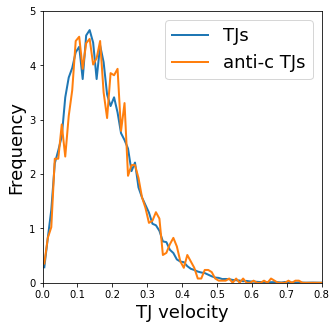

<Figure size 432x288 with 0 Axes>

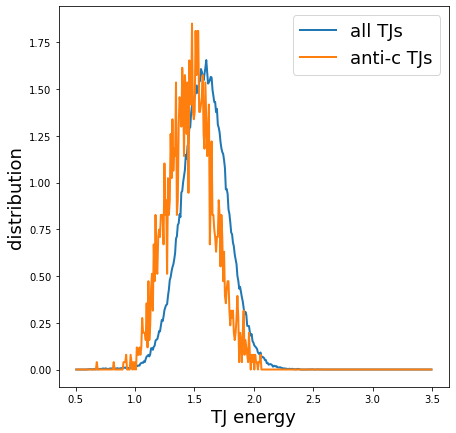

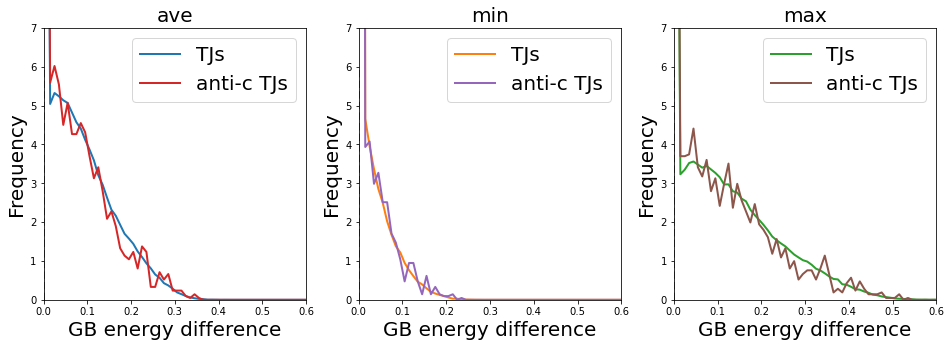

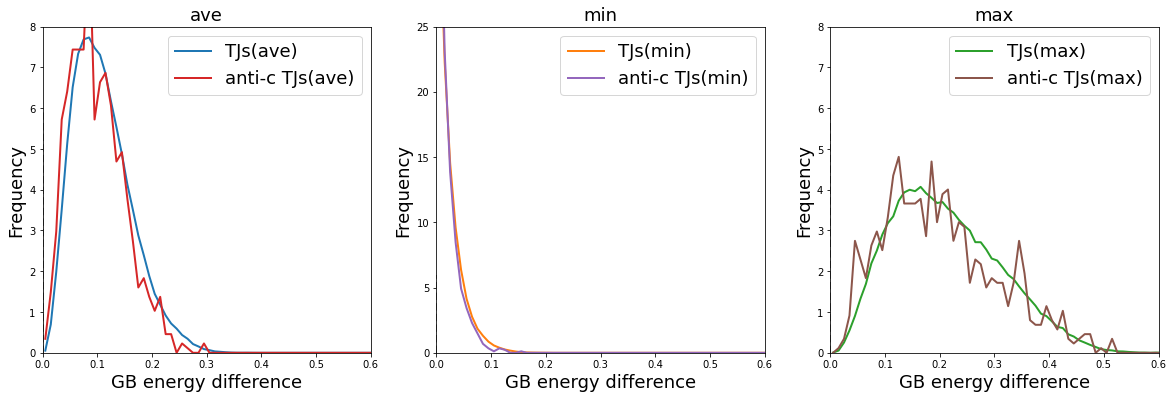

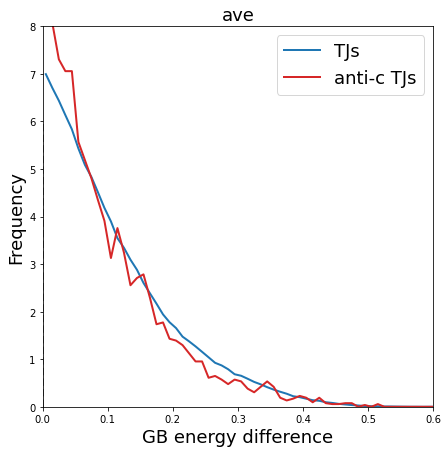

In [16]:

    xLim = [0,2.1]
    binValue = 0.01001
    binNum = round((abs(xLim[0])+abs(xLim[1]))/binValue)
    xCor = np.linspace((xLim[0]+binValue/2),(xLim[1]-binValue/2),binNum)
    xLim_energy = [0.5,3.5]
    binNum_energy = round((abs(xLim_energy[0])+abs(xLim_energy[1]))/binValue)
    xCor_energy = np.linspace((xLim_energy[0]+binValue/2),(xLim_energy[1]-binValue/2),binNum_energy)
    xLim_GBenergy = [0.0,1.2]
    binNum_GBenergy = round((abs(xLim_GBenergy[0])+abs(xLim_GBenergy[1]))/binValue)
    xCor_GBenergy = np.linspace((xLim_GBenergy[0]+binValue/2),(xLim_GBenergy[1]-binValue/2),binNum_GBenergy)
    xLim_GBDiffenergy = [-0.6,1.0]
    binNum_GBDiffenergy = round((abs(xLim_GBDiffenergy[0])+abs(xLim_GBDiffenergy[1]))/binValue)
    xCor_GBenergy_diff = np.linspace((xLim_GBDiffenergy[0]+binValue/2),(xLim_GBDiffenergy[1]-binValue/2),binNum_GBenergy)
    freqArray_velocity = np.zeros(binNum)
    freqArray_velocity_focus = np.zeros(binNum)
    freqArray_energy = np.zeros(binNum_energy)
    freqArray_energy_focus = np.zeros(binNum_energy)
    freqArray_GBenergy = np.zeros(binNum_GBenergy)
    freqArray_GBenergy_diff_three = np.zeros((3,binNum_GBenergy))
    freqArray_GBenergy_diff_four = np.zeros((3,binNum_GBenergy))
    freqArray_GBenergy_diff_four_all = np.zeros(binNum_GBenergy)
    freqArray_GBenergy_focus = np.zeros(binNum_GBenergy)
    freqArray_GBenergy_focus_diff_three = np.zeros((3,binNum_GBenergy))
    freqArray_GBenergy_focus_diff_four = np.zeros((3,binNum_GBenergy))
    freqArray_GBenergy_focus_diff_four_all = np.zeros(binNum_GBenergy)
    
    
    for site_i in range(len(TJ_velocity_1Dlist)):
        velocity = TJ_velocity_1Dlist[site_i]
        freqArray_velocity[int((velocity-xLim[0])//binValue)] += 1
        energy = TJ_energy_1Dlist[site_i]
        freqArray_energy[int((energy-xLim_energy[0])//binValue)] += 1
    freqArray_velocity = freqArray_velocity/np.sum(freqArray_velocity*binValue)
    freqArray_energy = freqArray_energy/np.sum(freqArray_energy*binValue)
    for site_i in range(len(TJ_focus_velocity_1Dlist)):
        velocity = TJ_focus_velocity_1Dlist[site_i]
        freqArray_velocity_focus[int((velocity-xLim[0])//binValue)] += 1
        energy = TJ_focus_energy_1Dlist[site_i]
        freqArray_energy_focus[int((energy-xLim_energy[0])//binValue)] += 1
    freqArray_velocity_focus = freqArray_velocity_focus/np.sum(freqArray_velocity_focus*binValue)
    freqArray_energy_focus = freqArray_energy_focus/np.sum(freqArray_energy_focus*binValue)
    for site_i in range(len(TJ_GBenergy_1Dlist)):
        GBenergy = TJ_GBenergy_1Dlist[site_i]
        freqArray_GBenergy[int((GBenergy-xLim_GBenergy[0])//binValue)] += 1
    freqArray_GBenergy = freqArray_GBenergy/np.sum(freqArray_GBenergy*binValue)
    for site_i in range(len(TJ_focus_GBenergy_1Dlist)):
        GBenergy = TJ_focus_GBenergy_1Dlist[site_i]
        freqArray_GBenergy_focus[int((GBenergy-xLim_GBenergy[0])//binValue)] += 1
    freqArray_GBenergy_focus = freqArray_GBenergy_focus/np.sum(freqArray_GBenergy_focus*binValue)
    for site_i in range(len(TJ_GBenergy_1Dlist_diff_three[0])):
        GBenergy0 = TJ_GBenergy_1Dlist_diff_three[0][site_i]
        GBenergy1 = TJ_GBenergy_1Dlist_diff_three[1][site_i]
        GBenergy2 = TJ_GBenergy_1Dlist_diff_three[2][site_i]
        freqArray_GBenergy_diff_three[0][int((GBenergy0-xLim_GBenergy[0])//binValue)] += 1
        freqArray_GBenergy_diff_three[1][int((GBenergy1-xLim_GBenergy[0])//binValue)] += 1
        freqArray_GBenergy_diff_three[2][int((GBenergy2-xLim_GBenergy[0])//binValue)] += 1
    freqArray_GBenergy_diff_three[0] = freqArray_GBenergy_diff_three[0]/np.sum(freqArray_GBenergy_diff_three[0]*binValue)
    freqArray_GBenergy_diff_three[1] = freqArray_GBenergy_diff_three[1]/np.sum(freqArray_GBenergy_diff_three[1]*binValue)
    freqArray_GBenergy_diff_three[2] = freqArray_GBenergy_diff_three[2]/np.sum(freqArray_GBenergy_diff_three[2]*binValue)
    for site_i in range(len(TJ_focus_GBenergy_1Dlist_diff_three[0])):
        GBenergy0 = TJ_focus_GBenergy_1Dlist_diff_three[0][site_i]
        GBenergy1 = TJ_focus_GBenergy_1Dlist_diff_three[1][site_i]
        GBenergy2 = TJ_focus_GBenergy_1Dlist_diff_three[2][site_i]
        freqArray_GBenergy_focus_diff_three[0][int((GBenergy0-xLim_GBenergy[0])//binValue)] += 1
        freqArray_GBenergy_focus_diff_three[1][int((GBenergy1-xLim_GBenergy[0])//binValue)] += 1
        freqArray_GBenergy_focus_diff_three[2][int((GBenergy2-xLim_GBenergy[0])//binValue)] += 1
    freqArray_GBenergy_focus_diff_three[0] = freqArray_GBenergy_focus_diff_three[0]/np.sum(freqArray_GBenergy_focus_diff_three[0]*binValue)
    freqArray_GBenergy_focus_diff_three[1] = freqArray_GBenergy_focus_diff_three[1]/np.sum(freqArray_GBenergy_focus_diff_three[1]*binValue)
    freqArray_GBenergy_focus_diff_three[2] = freqArray_GBenergy_focus_diff_three[2]/np.sum(freqArray_GBenergy_focus_diff_three[2]*binValue)
    # four GB energy
    for site_i in range(len(TJ_GBenergy_1Dlist_diff_four[0])):
        GBenergy0 = TJ_GBenergy_1Dlist_diff_four[0][site_i]
        GBenergy1 = TJ_GBenergy_1Dlist_diff_four[1][site_i]
        GBenergy2 = TJ_GBenergy_1Dlist_diff_four[2][site_i]
        freqArray_GBenergy_diff_four[0][int((GBenergy0-xLim_GBenergy[0])//binValue)] += 1
        freqArray_GBenergy_diff_four[1][int((GBenergy1-xLim_GBenergy[0])//binValue)] += 1
        freqArray_GBenergy_diff_four[2][int((GBenergy2-xLim_GBenergy[0])//binValue)] += 1
    freqArray_GBenergy_diff_four[0] = freqArray_GBenergy_diff_four[0]/np.sum(freqArray_GBenergy_diff_four[0]*binValue)
    freqArray_GBenergy_diff_four[1] = freqArray_GBenergy_diff_four[1]/np.sum(freqArray_GBenergy_diff_four[1]*binValue)
    freqArray_GBenergy_diff_four[2] = freqArray_GBenergy_diff_four[2]/np.sum(freqArray_GBenergy_diff_four[2]*binValue)
    for site_i in range(len(TJ_focus_GBenergy_1Dlist_diff_four[0])):
        GBenergy0 = TJ_focus_GBenergy_1Dlist_diff_four[0][site_i]
        GBenergy1 = TJ_focus_GBenergy_1Dlist_diff_four[1][site_i]
        GBenergy2 = TJ_focus_GBenergy_1Dlist_diff_four[2][site_i]
        freqArray_GBenergy_focus_diff_four[0][int((GBenergy0-xLim_GBenergy[0])//binValue)] += 1
        freqArray_GBenergy_focus_diff_four[1][int((GBenergy1-xLim_GBenergy[0])//binValue)] += 1
        freqArray_GBenergy_focus_diff_four[2][int((GBenergy2-xLim_GBenergy[0])//binValue)] += 1
    freqArray_GBenergy_focus_diff_four[0] = freqArray_GBenergy_focus_diff_four[0]/np.sum(freqArray_GBenergy_focus_diff_four[0]*binValue)
    freqArray_GBenergy_focus_diff_four[1] = freqArray_GBenergy_focus_diff_four[1]/np.sum(freqArray_GBenergy_focus_diff_four[1]*binValue)
    freqArray_GBenergy_focus_diff_four[2] = freqArray_GBenergy_focus_diff_four[2]/np.sum(freqArray_GBenergy_focus_diff_four[2]*binValue)
    # for all four enenrgy
    for site_i in range(len(TJ_GBenergy_1Dlist_diff_four_all)):
        GBenergy = TJ_GBenergy_1Dlist_diff_four_all[site_i]
        freqArray_GBenergy_diff_four_all[int((GBenergy-xLim_GBenergy[0])//binValue)] += 1
    freqArray_GBenergy_diff_four_all = freqArray_GBenergy_diff_four_all/np.sum(freqArray_GBenergy_diff_four_all*binValue)
    for site_i in range(len(TJ_focus_GBenergy_1Dlist_diff_four_all)):
        GBenergy = TJ_focus_GBenergy_1Dlist_diff_four_all[site_i]
        freqArray_GBenergy_focus_diff_four_all[int((GBenergy-xLim_GBenergy[0])//binValue)] += 1
    freqArray_GBenergy_focus_diff_four_all = freqArray_GBenergy_focus_diff_four_all/np.sum(freqArray_GBenergy_focus_diff_four_all*binValue)

    
    # plot
    figure_name_TJvelocity = f"figures/2D_TJ_velocity_{case_name}_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.xlim([0,0.8])
    plt.ylim([0,5.0])
    plt.plot(xCor, freqArray_velocity,'-', linewidth=2,label='TJs')
    plt.plot(xCor, freqArray_velocity_focus,'-', linewidth=2, label='anti-c TJs')
    plt.xlabel("TJ velocity", fontsize=18)
    plt.ylabel("Frequency", fontsize=18)
    plt.legend(fontsize=18)
    plt.savefig(figure_name_TJvelocity, dpi=400,bbox_inches='tight')
    
    # plot
    figure_name_TJenergy = f"figures/2D_TJ_energy_{case_name}_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.xlim([0,0.8])
    # plt.ylim([0,0.05])
    plt.plot(xCor_energy, freqArray_energy,'-', linewidth=2,label='all TJs')
    plt.plot(xCor_energy, freqArray_energy_focus,'-', linewidth=2, label='anti-c TJs')
    plt.xlabel("TJ energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    plt.legend(fontsize=18)
    # plt.savefig(figure_name_TJenergy, dpi=400,bbox_inches='tight')
    
    # plot
    figure_name_TJ_GBenergy = f"figures/2D_TJ_GBenergy_{case_name}_afterBin.png"
    plt.figure(figsize=(16,5))
    plt.subplot(131)
    plt.plot(xCor_GBenergy, freqArray_GBenergy_diff_three[0],'-', linewidth=2, label='TJs',color='C0')
    plt.plot(xCor_GBenergy, freqArray_GBenergy_focus_diff_three[0],'-', linewidth=2, label='anti-c TJs',color='C3')
    plt.plot([0,0],[0,6],'--', linewidth=2,color='grey')
    plt.xlim([0,0.6])
    plt.ylim([0,7])
    plt.xlabel("GB energy difference", fontsize=20)
    plt.ylabel("Frequency", fontsize=20)
    plt.legend(fontsize=20)
    plt.title('ave',fontsize=20)
    plt.subplot(132)
    plt.plot(xCor_GBenergy, freqArray_GBenergy_diff_three[1],'-', linewidth=2, label='TJs',color='C1')
    plt.plot(xCor_GBenergy, freqArray_GBenergy_focus_diff_three[1],'-', linewidth=2, label='anti-c TJs',color='C4')
    plt.plot([0,0],[0,6],'--', linewidth=2,color='grey')
    plt.xlim([0,0.6])
    plt.ylim([0,7])
    plt.xlabel("GB energy difference", fontsize=20)
    plt.ylabel("Frequency", fontsize=20)
    plt.legend(fontsize=20)
    plt.title('min',fontsize=20)
    plt.subplot(133)
    plt.plot(xCor_GBenergy, freqArray_GBenergy_diff_three[2],'-', linewidth=2, label='TJs',color='C2')
    plt.plot(xCor_GBenergy, freqArray_GBenergy_focus_diff_three[2],'-', linewidth=2, label='anti-c TJs',color='C5')
    plt.plot([0,0],[0,6],'--', linewidth=2,color='grey')
    plt.xlim([0,0.6])
    plt.ylim([0,7])
    plt.xlabel("GB energy difference", fontsize=20)
    plt.ylabel("Frequency", fontsize=20)
    plt.legend(fontsize=20)
    plt.title('max',fontsize=20)
    # print(f"The total is {len(TJ_GBenergy_1Dlist)}, the focus is {len(TJ_focus_GBenergy_1Dlist)}, the unfocus is {len(TJ_unfocus_GBenergy_1Dlist)}")
    plt.savefig(figure_name_TJ_GBenergy, dpi=400,bbox_inches='tight')
    
    # plot focus on four GB energy
    figure_name_TJ_GBenergy = f"figures/2D_TJ_GBenergy_four_{case_name}_afterBin.png"
    plt.figure(figsize=(20,6))
    plt.subplot(131)
    plt.plot(xCor_GBenergy, freqArray_GBenergy_diff_four[0],'-', linewidth=2, label='TJs(ave)',color='C0')
    plt.plot(xCor_GBenergy, freqArray_GBenergy_focus_diff_four[0],'-', linewidth=2, label='anti-c TJs(ave)',color='C3')
    plt.plot([0,0],[0,6],'--', linewidth=2,color='grey')
    plt.xlim([0,0.6])
    plt.ylim([0,8])
    plt.xlabel("GB energy difference", fontsize=18)
    plt.ylabel("Frequency", fontsize=18)
    plt.legend(fontsize=18)
    plt.title('ave',fontsize=18)
    plt.subplot(132)
    plt.plot(xCor_GBenergy, freqArray_GBenergy_diff_four[1],'-', linewidth=2, label='TJs(min)',color='C1')
    plt.plot(xCor_GBenergy, freqArray_GBenergy_focus_diff_four[1],'-', linewidth=2, label='anti-c TJs(min)',color='C4')
    plt.plot([0,0],[0,6],'--', linewidth=2,color='grey')
    plt.xlim([0,0.6])
    plt.ylim([0,25])
    plt.xlabel("GB energy difference", fontsize=18)
    plt.ylabel("Frequency", fontsize=18)
    plt.legend(fontsize=18)
    plt.title('min',fontsize=18)
    plt.subplot(133)
    plt.plot(xCor_GBenergy, freqArray_GBenergy_diff_four[2],'-', linewidth=2, label='TJs(max)',color='C2')
    plt.plot(xCor_GBenergy, freqArray_GBenergy_focus_diff_four[2],'-', linewidth=2, label='anti-c TJs(max)',color='C5')
    plt.plot([0,0],[0,6],'--', linewidth=2,color='grey')
    plt.xlim([0,0.6])
    plt.ylim([0,8])
    plt.xlabel("GB energy difference", fontsize=18)
    plt.ylabel("Frequency", fontsize=18)
    plt.legend(fontsize=18)
    plt.title('max',fontsize=18)
    # print(f"The total is {len(TJ_GBenergy_1Dlist)}, the focus is {len(TJ_focus_GBenergy_1Dlist)}, the unfocus is {len(TJ_unfocus_GBenergy_1Dlist)}")
    # plt.savefig(figure_name_TJ_GBenergy, dpi=400,bbox_inches='tight')
    
    # plot all energy difference
    figure_name_TJ_GBenergy = f"figures/2D_TJ_GBenergy_four_all_{case_name}_afterBin.png"
    plt.figure(figsize=(7,7))
    plt.plot(xCor_GBenergy, freqArray_GBenergy_diff_four_all,'-', linewidth=2, label='TJs',color='C0')
    plt.plot(xCor_GBenergy, freqArray_GBenergy_focus_diff_four_all,'-', linewidth=2, label='anti-c TJs',color='C3')
    plt.plot([0,0],[0,6],'--', linewidth=2,color='grey')
    plt.xlim([0,0.6])
    plt.ylim([0,8])
    plt.xlabel("GB energy difference", fontsize=18)
    plt.ylabel("Frequency", fontsize=18)
    plt.legend(fontsize=18)
    plt.title('ave',fontsize=18)
    # print(f"The total is {len(TJ_GBenergy_1Dlist)}, the focus is {len(TJ_focus_GBenergy_1Dlist)}, the unfocus is {len(TJ_unfocus_GBenergy_1Dlist)}")
    # plt.savefig(figure_name_TJ_GBenergy, dpi=400,bbox_inches='tight')
    
    


In [17]:
    # extract TJ average velocity 
    time_interval = 30
    edge_matrix = np.array([[0,0,0],[size_x,0,0],[-size_x,0,0],[0,size_y,0],[0,-size_y,0],[size_x,size_y,0],[-size_x,-size_y,0],[-size_x,size_y,0],[size_x,-size_y,0]])
    
    init_TJ_keys = dict()
    mean_velocity_TJs = dict()
    for TJ_key in TJ_information_dict_list[0]: init_TJ_keys[TJ_key] = 0 # add all TJs in 0 step as init
    for time_step in range(1, step_num):
        
        for TJ_key in TJ_information_dict_list[time_step]:
            if TJ_key in init_TJ_keys: # know the init step
                if time_step==step_num-1 or TJ_key not in TJ_information_dict_list[time_step+1]: # last step for current TJs
                    # calculate velocity and keep it
                    init_step = init_TJ_keys[TJ_key]
                    location_init_step = TJ_information_dict_list[init_step][TJ_key][:3]
                    location_end_step = TJ_information_dict_list[time_step][TJ_key][:3]
                    difference_9points = np.tile(location_end_step,(9,1)) + edge_matrix - np.tile(location_init_step,(9,1))
                    distance_9points = np.linalg.norm(difference_9points,axis=1)
                    distance = np.min(distance_9points)
                    # calculate velocity
                    mean_velocity = distance / (time_interval*(time_step-init_step))
                    mean_velocity_TJs[TJ_key] = mean_velocity
            else: # don't know the init step
                init_TJ_keys[TJ_key] = time_step
    TJ_mean_velocity_1Dlist = list(mean_velocity_TJs.values())
    
    mean_velocity_focus_TJs = dict()
    for GB_key in tqdm(GB_id_focus_detail):
        if len(GB_id_focus_detail[GB_key]) < 2: continue
        init_step = GB_id_focus_detail[GB_key][0]
        end_step = GB_id_focus_detail[GB_key][-1]
        pair_id_pair_focus = GB_infomation_dict_list[init_step][GB_key][6:8]
        
        for TJ_key in TJ_information_dict_list[init_step]:
            if pair_id_pair_focus[0] in TJ_key and pair_id_pair_focus[1] in TJ_key:
                location_init_step = TJ_information_dict_list[init_step][TJ_key][:3]
                if TJ_key not in TJ_information_dict_list[end_step]: continue
                
                location_end_step = TJ_information_dict_list[end_step][TJ_key][:3]
                difference_9points = np.tile(location_end_step,(9,1)) + edge_matrix - np.tile(location_init_step,(9,1))
                distance_9points = np.linalg.norm(difference_9points,axis=1)
                distance = np.min(distance_9points)
                # calculate velocity
                mean_velocity = distance / (time_interval*(end_step-init_step))
                mean_velocity_focus_TJs[TJ_key] = mean_velocity
                
        
        # location_init_step = TJ_information_dict_list[init_step][TJ_key][:3]
        # location_end_step = TJ_information_dict_list[end_step][TJ_key][:3]
        # difference_9points = np.tile(location_end_step,(9,1)) + edge_matrix - np.tile(location_init_step,(9,1))
        # distance_9points = np.linalg.norm(difference_9points,axis=1)
        # distance = np.min(distance_9points)
        # # calculate velocity
        # mean_velocity = distance / (time_interval*(time_step-init_step))
        # mean_velocity_focus_TJs[TJ_key] = mean_velocity
    TJ_focus_mean_velocity_1Dlist = list(mean_velocity_focus_TJs.values())
    
        

100%|██████████| 520/520 [00:00<00:00, 658.18it/s]


<Figure size 432x288 with 0 Axes>

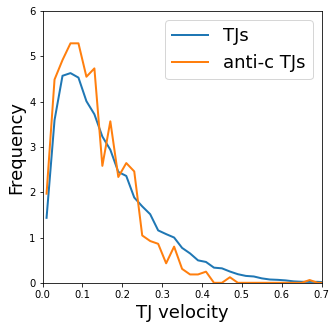

In [18]:

    xLim = [0,2.1]
    binValue = 0.02001
    binNum = round((abs(xLim[0])+abs(xLim[1]))/binValue)
    xCor = np.linspace((xLim[0]+binValue/2),(xLim[1]-binValue/2),binNum)
    freqArray_mean_velocity = np.zeros(binNum)
    freqArray_mean_velocity_focus = np.zeros(binNum)
    
    for site_i in range(len(TJ_mean_velocity_1Dlist)):
        mean_velocity = TJ_mean_velocity_1Dlist[site_i]
        freqArray_mean_velocity[int((mean_velocity-xLim[0])//binValue)] += 1
    freqArray_mean_velocity = freqArray_mean_velocity/np.sum(freqArray_mean_velocity*binValue)
    for site_i in range(len(TJ_focus_mean_velocity_1Dlist)):
        mean_velocity = TJ_focus_mean_velocity_1Dlist[site_i]
        freqArray_mean_velocity_focus[int((mean_velocity-xLim[0])//binValue)] += 1
    freqArray_mean_velocity_focus = freqArray_mean_velocity_focus/np.sum(freqArray_mean_velocity_focus*binValue)
    
    # plot
    figure_name_TJmeanvelocity = f"figures/2D_TJ_mean_velocity_{case_name}_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.xlim([0,0.7])
    plt.ylim([0,6])
    plt.plot(xCor, freqArray_mean_velocity,'-', linewidth=2,label='TJs')
    plt.plot(xCor, freqArray_mean_velocity_focus,'-', linewidth=2, label='anti-c TJs')
    plt.xlabel("TJ velocity", fontsize=18)
    plt.ylabel("Frequency", fontsize=18)
    plt.legend(fontsize=18)
    plt.savefig(figure_name_TJmeanvelocity, dpi=400,bbox_inches='tight')
    


1640